# Notebook 3.1 - Procesamiento de datos: Dataset covid/covid - v1

***
## Acabado
***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# conda install scipy -> versión 3.12 de Python, Scipy no funciona con la 3.13
from scipy.stats import skew

# conda install -c conda-forge scikit-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import pickle

import time
import sys
import gc
from math import ceil

from datetime import datetime

In [2]:
# directorio con los dataframes
dataframe_path = "..//data//dataframes"

In [3]:
# nombre del fichero del dataframe
dataframe_file = "covid__covid_2025-07-01"

In [4]:
# versión de Python
print(f"{sys.version_info.major}.{sys.version_info.minor}")

3.12


## Funciones auxiliares

<b>1. Mostrar información dataframe</b>

In [5]:
def show_dataframe(df):
    """
    Muestra características principales del dataframe.

    Args:
        df: dataframe de Pandas
    """
    print("Shape:", df.shape)
    print("-" * 50)
    print(df.info())
    print("-" * 50)
    display(df.head())
    print("-" * 50)
    print("Filas duplicadas:", df.shape[0] - df.drop_duplicates().shape[0])
    print("-" * 50)

    print("Filas con todos sus valores nulos:", df.isnull().all(axis=1).sum())
    print("-" * 50)
    
    print("Columnas:")
    display(df.columns)

In [6]:
def show_column(df, col):
    """
    Muestra una descripción de la columna del Dataframe recibido.

    Args:
        df: Dataframe de Pandas
        col: str, nombre de la columna
    """
    display(df[[col]].describe())
    print("-" * 50)
    display(df[[col]])

    print("-" * 15, "Frecuencia de valores", "-" * 15)
    print(f"{df[[col]].value_counts()}")
    
    print("-" * 50)
    print(f"Valores únicos: {df[[col]].nunique()}")

    print("-" * 50)
    print(f"Valores a cero: {df[col].apply(lambda x: x==0).value_counts()}")

    print("-" * 50)
    print(f"Valores nulos: {df[col].isnull().sum()}")

<b>2. Analizar variables</b>

In [7]:
def analizar_variable_numerica(df, variable, fecha_col=None, frecuencia='W'):
    """
    Muestra análisis de una varible numérica de un Dataframe.

    Args:
        df: Dataframe de Pandas
        variable: str, nombre de la variable
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el promedio por período
            D: diario; W: semanal; M: mensual

    Returns:
        diccionario {'skewness', 'sesgo', 'num_outliers', 'porcentaje_outliers'}
    """
    resultado = {}

    # valida los datos recibidos
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in df.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")

    # serie con los valores de la variable sin nulos
    serie = df[variable].dropna()

    # grafica la distribución de la variable
    plt.figure(figsize=(6, 4))
    plt.hist(x=serie, bins=50, density=True, facecolor='g', alpha=0.5)
    plt.title(f"Distribución de {variable}")
    plt.show()

    # coeficiente de asimetría (skewness) de la distribución
    skewness = skew(serie)
    resultado['skewness'] = skewness
    resultado['sesgo'] = (
        'simétrica' if abs(skewness) < 0.5 else
        'moderadamente sesgada' if abs(skewness) < 1 else
        'muy sesgada'
    )
    
    # grafica los outliers
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=serie)
    plt.title(f"Outliers en {variable}")
    plt.show()

    # calcula número y porcentaje de outliers
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    outliers = serie[(serie < Q1 - 1.5 * IQR) | (serie > Q3 + 1.5 * IQR)]

    resultado['num_outliers'] = len(outliers)
    resultado['porcentaje_outliers'] = 100 * len(outliers) / len(serie)

    # análisis temporal (si se indica columna de fecha)
    if fecha_col:
        # selecciona la variable y la columna de fecha sin nulos
        df_temp = df[[fecha_col, variable]].dropna()
        # asegura que las fechas estén en formato datetime
        df_temp[fecha_col] = pd.to_datetime(df_temp[fecha_col])
        # ordena cronológicamente
        df_temp = df_temp.sort_values(fecha_col)
        
        # serie temporal
        plt.figure(figsize=(12, 4))
        plt.plot(df_temp[fecha_col], df_temp[variable], alpha=0.6)
        plt.title(f"{variable} a lo largo del tiempo")
        plt.xlabel("Fecha")
        plt.ylabel(variable)
        plt.show()

        # resample temporal (promedio por período), media de la variable en cada intervalo
        match frecuencia:
            case "D":
                frecuencia_txt = "día"
            case "W":
                frecuencia_txt = "semana"
            case "M":
                frecuencia_txt = "mes"
                frecuencia = "ME"   # 'M' deja de utilizarse
            case _:
                frecuencia_txt = "error"

        if frecuencia_txt != "error":
            df_resample = df_temp.set_index(fecha_col)[variable].resample(frecuencia).mean()
            
            plt.figure(figsize=(12, 4))
            df_resample.plot()
            plt.title(f'{variable} promedio por {frecuencia_txt}')
            plt.ylabel(variable)
            plt.show()
        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

    return resultado

In [8]:
'''
v2
'''
def analizar_variable_categorica(
    df, variable, fecha_col=None, frecuencia='W', top_n=10, filtro=None
):
    """
    Muestra análisis de una variable categórica de un DataFrame.
    
    Args:
        df: DataFrame de Pandas
        variable: str, nombre de la variable categórica
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el análisis temporal
            D: diario; W: semanal; M: mensual
        top_n: int, número de categorías más frecuentes a mostrar en gráficos
        filtro: str, expresión opcional para filtrar la variable a analizar
            La expresión se evalúa como: df[variable] <filtro>

    Returns:
        diccionario con estadísticas de la variable categórica
            {'total_registros', 'categorias_unicas', 'categoria_mas_frecuente',
            'frecuencia_maxima', 'porcentaje_maximo', 'categoria_menos_frecuente',
            'frecuencia_minima', 'porcentaje_minimo', 'concentracion_top_n',
            'top_n_usado'}
    """
    resultado = {}
    
    # valida los datos recibidos
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in df.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")

    # aplica filtro si se especifica
    df_filtrado = df.copy()
    if filtro:
        try:
            # construye la expresión de filtrado
            expresion_filtro = f"df_filtrado[variable] {filtro}"
            mascara_filtro = eval(expresion_filtro)
            df_filtrado = df_filtrado[mascara_filtro]
            
            print(f"Filtro aplicado: {variable} {filtro}")
            print(f"Registros después del filtrado: {len(df_filtrado):,} (de {len(df):,})")
            print()
        except Exception as e:
            raise ValueError(f"Error al aplicar el filtro '{filtro}': {str(e)}")
    
    # serie con los valores de la variable sin nulos
    serie = df_filtrado[variable].dropna()
    
    # tabla de frecuencias (sin categorías vacías en caso de filtrado)
    freq_table = serie.value_counts(dropna=True).sort_values(ascending=False)
    # filtra sólo las categorías con frecuencia > 0
    freq_table = freq_table[freq_table > 0]
    freq_porcentajes = (freq_table / len(serie) * 100).sort_values(ascending=False)
    
    # estadísticas básicas
    resultado['total_registros'] = len(serie)
    resultado['categorias_unicas'] = len(freq_table)
    if len(freq_table) > 0:
        # hay datos después del filtrado
        resultado['categoria_mas_frecuente'] = freq_table.index[0]
        resultado['frecuencia_maxima'] = freq_table.iloc[0]
        resultado['porcentaje_maximo'] = freq_porcentajes.iloc[0]
        resultado['categoria_menos_frecuente'] = freq_table.index[-1]
        resultado['frecuencia_minima'] = freq_table.iloc[-1]
        resultado['porcentaje_minimo'] = freq_porcentajes.iloc[-1]
        # concentración (porcentaje acumulado de las top_n categorías)
        top_categorias = freq_porcentajes.head(min(top_n, len(freq_porcentajes)))
        resultado['concentracion_top_n'] = top_categorias.sum()
        resultado['top_n_usado'] = len(top_categorias)
    else:
        # no quedan datos después del filtrado
        print("ADVERTENCIA: No quedan datos después de aplicar el filtro ",
             f"{variable} {filtro}")
        return resultado
    
    # gráfico de barras (top_n categorías)
    plt.figure(figsize=(12, 6))
    top_freq = freq_table.head(top_n)
    plt.bar(range(len(top_freq)), top_freq.values, color='skyblue', alpha=0.7)

    titulo_grafico = f"Top {min(top_n, len(freq_table))} "
    titulo_grafico += f"categorías más frecuentes - {variable}"
    if filtro:
        titulo_grafico += f" (filtro: {variable} {filtro})"
    plt.title(titulo_grafico)
    plt.xlabel("Categorías")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(top_freq)), top_freq.index, rotation=45, ha='right')
    
    # añade valores sobre las barras
    for i, v in enumerate(top_freq.values):
        plt.text(i, v + max(top_freq.values) * 0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # gráfico de sectores
    if len(freq_table) <= 8:
        # pocas categorías: muestra todas
        plt.figure(figsize=(8, 8))
        plt.pie(freq_table.values, labels=freq_table.index, autopct='%1.1f%%', startangle=90)
        titulo_pie = f"Distribución de {variable}"
        if filtro:
            titulo_pie += f" (filtro: {filtro})"
        plt.title(titulo_pie)
        plt.axis("equal")
        plt.show()
    else:
        # muchas categorías: muestra sólo las top_n y agrupa el resto
        plt.figure(figsize=(8, 8))
        top = freq_table.head(top_n)
        otros = freq_table.iloc[top_n:].sum()
        if otros > 0:
            valores = list(top.values) + [otros]
            etiquetas = list(top.index) + ['Otros']
        else:
            valores = top.values
            etiquetas = top.index
        plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90)
        titulo_pie = f"Distribución de {variable} (Top {top_n} + Otros)"
        if filtro:
            titulo_pie += f" (filtro: {filtro})"
        plt.title(titulo_pie)
        plt.axis("equal")
        plt.show()
    
    # análisis temporal (si se indica columna de fecha)
    if fecha_col:
        # selecciona la variable y la columna de fecha sin nulos
        df_temp = df_filtrado[[fecha_col, variable]].dropna()
        # asegura que las fechas estén en formato datetime
        df_temp[fecha_col] = pd.to_datetime(df_temp[fecha_col])
        # ordena cronológicamente
        df_temp = df_temp.sort_values(fecha_col)
        
        # configuración de frecuencia
        match frecuencia:
            case "D":
                frecuencia_txt = "día"
            case "W":
                frecuencia_txt = "semana"
            case "M":
                frecuencia_txt = "mes"
                frecuencia = "ME"   # 'M' deja de utilizarse
            case _:
                frecuencia_txt = "error"
        
        if frecuencia_txt != "error":
            # análisis temporal: conteo de cada categoría por período
            df_temp_indexed = df_temp.set_index(fecha_col)
            
            # crea tabla de conteos por período y categoría
            conteos_periodo = df_temp_indexed.groupby([
                pd.Grouper(freq=frecuencia), variable
            ]).size().unstack(fill_value=0)
            
            # gráfico de evolución temporal (top_n categorías)
            plt.figure(figsize=(14, 8))
            top_cats_temporal = freq_table.head(top_n).index
            
            for cat in top_cats_temporal:
                if cat in conteos_periodo.columns:
                    plt.plot(conteos_periodo.index, conteos_periodo[cat], 
                            marker='o', label=str(cat), alpha=0.7, linewidth=2)
            
            titulo_temporal = f"Evolución temporal de {variable} "
            titulo_temporal += f"(Top {top_n} categorías) por {frecuencia_txt}"
            if filtro:
                titulo_temporal += f" (filtro: {filtro})"
            plt.title(titulo_temporal)
            plt.xlabel("Fecha")
            plt.ylabel(f"Conteo por {frecuencia_txt}")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # gráfico de barras apiladas por período
            plt.figure(figsize=(14, 8))
            conteos_periodo[top_cats_temporal].plot(kind='bar', stacked=True, 
                                                   figsize=(14, 8), alpha=0.8)
            titulo_apiladas = f"Distribución de {variable} por {frecuencia_txt} "
            titulo_apiladas += f"(barras apiladas)"
            if filtro:
                titulo_apiladas += f" (filtro: {filtro})"
            plt.title(titulo_apiladas)
            plt.xlabel("Fecha")
            plt.ylabel(f"Conteo por {frecuencia_txt}")
            plt.legend(title=variable, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # estadísticas adicionales para análisis temporal
            resultado['periodos_analizados'] = len(conteos_periodo)
            resultado['fecha_inicio'] = df_temp[fecha_col].min()
            resultado['fecha_fin'] = df_temp[fecha_col].max()
            
        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

    # muestra frecuencia de repetición de valores
    print("=" * 15, "Frecuencia de valores", "=" * 15)
    if filtro:
        print(f"Datos filtrados: {variable} {filtro}")
    print(f"{freq_table}")
    
    # muestra resumen estadístico
    print("=" * 50)
    titulo_resumen = f"RESUMEN ESTADÍSTICO - {variable}"
    if filtro:
        titulo_resumen += f" (filtro: {filtro})"
    print(titulo_resumen)
    print("=" * 50)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Categorías únicas: {resultado['categorias_unicas']:,}")
    print(f"Categoría más frecuente: '{resultado['categoria_mas_frecuente']}' ",
          f"({resultado['frecuencia_maxima']:,} veces, ",
          f"{resultado['porcentaje_maximo']:.1f}%)")
    print(f"Categoría menos frecuente: '{resultado['categoria_menos_frecuente']}' ",
          f"({resultado['frecuencia_minima']:,} veces, ",
          f"{resultado['porcentaje_minimo']:.1f}%)")
    print(f"Concentración top {resultado['top_n_usado']}: ",
          f"{resultado['concentracion_top_n']:.1f}% de los datos")
    
    if fecha_col and frecuencia_txt != "error":
        print(f"Período analizado: {resultado['fecha_inicio'].strftime('%Y-%m-%d')} ",
              f"a {resultado['fecha_fin'].strftime('%Y-%m-%d')}")
        print(f"Períodos de {frecuencia_txt}: {resultado['periodos_analizados']:,}")
    
    return resultado

In [9]:
'''
v1, funciona bien
'''
'''
def analizar_variable_categorica(
    df, variable, fecha_col=None, frecuencia='W', top_n=10
):
    """
    Muestra análisis de una variable categórica de un DataFrame.
    
    Args:
        df: DataFrame de Pandas
        variable: str, nombre de la variable categórica
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el análisis temporal
            D: diario; W: semanal; M: mensual
        top_n: int, número de categorías más frecuentes a mostrar en gráficos

    Returns:
        diccionario con estadísticas de la variable categórica
            {'total_registros', 'categorias_unicas', 'categoria_mas_frecuente',
            'frecuencia_maxima', 'porcentaje_maximo', 'categoria_menos_frecuente',
            'frecuencia_minima', 'porcentaje_minimo', 'concentracion_top_n',
            'top_n_usado'}
    """
    resultado = {}
    
    # valida los datos recibidos
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in df.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")
    
    # serie con los valores de la variable sin nulos
    serie = df[variable].dropna()
    
    # tabla de frecuencias
    freq_table = serie.value_counts().sort_values(ascending=False)
    freq_porcentajes = serie.value_counts(normalize=True).sort_values(ascending=False) * 100
    
    # estadísticas básicas
    resultado['total_registros'] = len(serie)
    resultado['categorias_unicas'] = len(freq_table)
    resultado['categoria_mas_frecuente'] = freq_table.index[0]
    resultado['frecuencia_maxima'] = freq_table.iloc[0]
    resultado['porcentaje_maximo'] = freq_porcentajes.iloc[0]
    resultado['categoria_menos_frecuente'] = freq_table.index[-1]
    resultado['frecuencia_minima'] = freq_table.iloc[-1]
    resultado['porcentaje_minimo'] = freq_porcentajes.iloc[-1]
    
    # concentración (porcentaje acumulado de las top_n categorías)
    top_categorias = freq_porcentajes.head(min(top_n, len(freq_porcentajes)))
    resultado['concentracion_top_n'] = top_categorias.sum()
    resultado['top_n_usado'] = len(top_categorias)
    
    # gráfico de barras (top_n categorías)
    plt.figure(figsize=(12, 6))
    top_freq = freq_table.head(top_n)
    plt.bar(range(len(top_freq)), top_freq.values, color='skyblue', alpha=0.7)
    plt.title(f"Top {min(top_n, len(freq_table))} categorías más frecuentes - {variable}")
    plt.xlabel("Categorías")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(top_freq)), top_freq.index, rotation=45, ha='right')
    
    # añade valores sobre las barras
    for i, v in enumerate(top_freq.values):
        plt.text(i, v + max(top_freq.values) * 0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # gráfico de sectores
    if len(freq_table) <= 8:
        # pocas categorías: muestra todas
        plt.figure(figsize=(8, 8))
        plt.pie(freq_table.values, labels=freq_table.index, autopct='%1.1f%%', startangle=90)
        plt.title(f"Distribución de {variable}")
        plt.axis("equal")
        plt.show()
    else:
        # muchas categorías: muestra sólo las top_n y agrupa el resto
        plt.figure(figsize=(8, 8))
        top_5 = freq_table.head(5)
        otros = freq_table.iloc[5:].sum()
        
        if otros > 0:
            valores = list(top_5.values) + [otros]
            etiquetas = list(top_5.index) + ['Otros']
        else:
            valores = top_5.values
            etiquetas = top_5.index
            
        plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90)
        plt.title(f"Distribución de {variable} (Top {top_n} + Otros)")
        plt.axis("equal")
        plt.show()
    
    # análisis temporal (si se indica columna de fecha)
    if fecha_col:
        # selecciona la variable y la columna de fecha sin nulos
        df_temp = df[[fecha_col, variable]].dropna()
        # asegura que las fechas estén en formato datetime
        df_temp[fecha_col] = pd.to_datetime(df_temp[fecha_col])
        # ordena cronológicamente
        df_temp = df_temp.sort_values(fecha_col)
        
        # configuración de frecuencia
        match frecuencia:
            case "D":
                frecuencia_txt = "día"
            case "W":
                frecuencia_txt = "semana"
            case "M":
                frecuencia_txt = "mes"
                frecuencia = "ME"   # 'M' deja de utilizarse
            case _:
                frecuencia_txt = "error"
        
        if frecuencia_txt != "error":
            # análisis temporal: conteo de cada categoría por período
            df_temp_indexed = df_temp.set_index(fecha_col)
            
            # crea tabla de conteos por período y categoría
            conteos_periodo = df_temp_indexed.groupby([
                pd.Grouper(freq=frecuencia), variable
            ]).size().unstack(fill_value=0)
            
            # gráfico de evolución temporal (top_n categorías)
            plt.figure(figsize=(14, 8))
            
            #top_cats_temporal = freq_table.head(5).index
            top_cats_temporal = freq_table.head(top_n).index
            
            for cat in top_cats_temporal:
                if cat in conteos_periodo.columns:
                    plt.plot(conteos_periodo.index, conteos_periodo[cat], 
                            marker='o', label=str(cat), alpha=0.7, linewidth=2)
            
            plt.title(f"Evolución temporal de {variable} ",
                      f"(Top {top_n} categorías) por {frecuencia_txt}")
            plt.xlabel("Fecha")
            plt.ylabel(f"Conteo por {frecuencia_txt}")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # gráfico de barras apiladas por período
            plt.figure(figsize=(14, 8))
            conteos_periodo[top_cats_temporal].plot(kind='bar', stacked=True, 
                                                   figsize=(14, 8), alpha=0.8)
            plt.title(f"Distribución de {variable} por {frecuencia_txt} (barras apiladas)")
            plt.xlabel("Fecha")
            plt.ylabel(f"Conteo por {frecuencia_txt}")
            plt.legend(title=variable, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # estadísticas adicionales para análisis temporal
            resultado['periodos_analizados'] = len(conteos_periodo)
            resultado['fecha_inicio'] = df_temp[fecha_col].min()
            resultado['fecha_fin'] = df_temp[fecha_col].max()
            
        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

    # muestra frecuencia de repetición de valores
    print("=" * 15, "Frecuencia de valores", "=" * 15)
    print(f"{df[[variable]].value_counts()}")
    
    # muestra resumen estadístico
    print("=" * 50)
    print(f"RESUMEN ESTADÍSTICO - {variable}")
    print("=" * 50)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Categorías únicas: {resultado['categorias_unicas']:,}")
    print(f"Categoría más frecuente: '{resultado['categoria_mas_frecuente']}' ",
          f"({resultado['frecuencia_maxima']:,} veces, ",
          f"{resultado['porcentaje_maximo']:.1f}%)")
    print(f"Categoría menos frecuente: '{resultado['categoria_menos_frecuente']}' ",
          f"({resultado['frecuencia_minima']:,} veces, ",
          f"{resultado['porcentaje_minimo']:.1f}%)")
    print(f"Concentración top {resultado['top_n_usado']}: ",
          f"{resultado['concentracion_top_n']:.1f}% de los datos")
    
    if fecha_col and frecuencia_txt != "error":
        print(f"Período analizado: {resultado['fecha_inicio'].strftime('%Y-%m-%d')} ",
              f"a {resultado['fecha_fin'].strftime('%Y-%m-%d')}")
        print(f"Períodos de {frecuencia_txt}: {resultado['periodos_analizados']:,}")
    
    print("=" * 50)
    print()
    
    return resultado
'''
print()

In [10]:
def analizar_variable_datetime(
    df, variable, frecuencia='M', top_n=10
):
    """
    Muestra análisis de una variable de fecha/datetime de un DataFrame.
    
    Args:
        df: DataFrame de Pandas
        variable: str, nombre de la variable datetime
        frecuencia: str, intervalo de tiempo para el análisis
            D: diario; W: semanal; M: mensual; Y: anual
        top_n: int, número de períodos más frecuentes a mostrar en algunos gráficos

    Returns:
        diccionario con estadísticas de la variable datetime
            {'total_registros', 'fecha_minima', 'fecha_maxima', 'rango_dias',
            'año_inicio', 'año_fin', 'rango_años', 'meses_unicos', 'años_unicos',
            'dia_semana_mas_frecuente', 'mes_mas_frecuente', 'año_mas_frecuente',
            'concentracion_temporal'}
    """
    resultado = {}
    
    # valida los datos recibidos
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    
    # serie con los valores de la variable sin nulos
    serie = df[variable].dropna()
    
    # convierte a datetime si no lo está
    serie = pd.to_datetime(serie)
    
    # estadísticas básicas
    resultado['total_registros'] = len(serie)
    resultado['fecha_minima'] = serie.min()
    resultado['fecha_maxima'] = serie.max()
    resultado['rango_dias'] = (serie.max() - serie.min()).days
    resultado['año_inicio'] = serie.min().year
    resultado['año_fin'] = serie.max().year
    resultado['rango_años'] = resultado['año_fin'] - resultado['año_inicio']
    
    # análisis por componentes de fecha
    años = serie.dt.year
    meses = serie.dt.month
    dias_semana = serie.dt.dayofweek
    
    resultado['años_unicos'] = años.nunique()
    resultado['meses_unicos'] = meses.nunique()
    
    # frecuencias
    freq_años = años.value_counts().sort_index()
    freq_meses = meses.value_counts().sort_index()
    freq_dias_semana = dias_semana.value_counts().sort_index()
    
    # más frecuentes
    resultado['año_mas_frecuente'] = freq_años.idxmax()
    resultado['mes_mas_frecuente'] = freq_meses.idxmax()
    resultado['dia_semana_mas_frecuente'] = freq_dias_semana.idxmax()
    
    # nombres de meses y días
    nombres_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    
    # gráfico de distribución por años
    plt.figure(figsize=(12, 6))
    plt.bar(freq_años.index, freq_años.values, color='lightblue', alpha=0.7)
    plt.title(f"Distribución por años - {variable}")
    plt.xlabel("Año")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    
    for i, v in enumerate(freq_años.values):
        plt.text(freq_años.index[i], v + max(freq_años.values) * 0.01, 
                str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # gráfico de distribución por meses
    plt.figure(figsize=(12, 6))
    meses_idx = freq_meses.index
    meses_nombres = [nombres_meses[i-1] for i in meses_idx]
    
    plt.bar(range(len(freq_meses)), freq_meses.values, color='lightgreen', alpha=0.7)
    plt.title(f"Distribución por meses - {variable}")
    plt.xlabel("Mes")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(freq_meses)), meses_nombres, rotation=45)
    
    for i, v in enumerate(freq_meses.values):
        plt.text(i, v + max(freq_meses.values) * 0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # gráfico de distribución por días de la semana
    plt.figure(figsize=(10, 6))
    dias_idx = freq_dias_semana.index
    dias_nombres = [nombres_dias[i] for i in dias_idx]
    
    plt.bar(
        range(len(freq_dias_semana)), freq_dias_semana.values, color='lightcoral', alpha=0.7
    )
    plt.title(f"Distribución por días de la semana - {variable}")
    plt.xlabel("Día de la semana")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(freq_dias_semana)), dias_nombres, rotation=45)
    
    for i, v in enumerate(freq_dias_semana.values):
        plt.text(
            i, v + max(freq_dias_semana.values) * 0.01, str(v), ha='center', va='bottom'
        )
    
    plt.tight_layout()
    plt.show()
    
    # análisis temporal según frecuencia especificada
    df_temp = pd.DataFrame({variable: serie})
    df_temp = df_temp.set_index(variable)
    
    # configuración de frecuencia
    match frecuencia:
        case "D":
            frecuencia_txt = "día"
            freq_code = "D"
        case "W":
            frecuencia_txt = "semana"
            freq_code = "W"
        case "M":
            frecuencia_txt = "mes"
            freq_code = "ME"
        case "Y":
            frecuencia_txt = "año"
            freq_code = "YE"
        case _:
            frecuencia_txt = "mes"
            freq_code = "ME"
    
    # conteo por período
    conteos_periodo = df_temp.groupby(pd.Grouper(freq=freq_code)).size()
    # elimina períodos sin datos
    conteos_periodo = conteos_periodo[conteos_periodo > 0]
    
    # gráfico de serie temporal
    plt.figure(figsize=(14, 6))
    plt.plot(conteos_periodo.index, conteos_periodo.values, 
             marker='o', color='navy', alpha=0.7, linewidth=2)
    plt.title(f"Evolución temporal por {frecuencia_txt} - {variable}")
    plt.xlabel("Fecha")
    plt.ylabel(f"Conteo por {frecuencia_txt}")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # histograma de frecuencias por período
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(conteos_periodo)), conteos_periodo.values, 
            color='purple', alpha=0.6)
    plt.title(f"Histograma de frecuencias por {frecuencia_txt} - {variable}")
    plt.xlabel(f"Períodos ({frecuencia_txt})")
    plt.ylabel("Frecuencia")
    
    # muestra sólo algunas etiquetas en el eje x para evitar saturación
    step = max(1, len(conteos_periodo) // 10)
    x_labels = [
        conteos_periodo.index[i].strftime('%Y-%m-%d') for i in range(
            0, len(conteos_periodo), step
        )
    ]
    x_positions = range(0, len(conteos_periodo), step)
    plt.xticks(x_positions, x_labels, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # top_n períodos más activos
    top_periodos = conteos_periodo.nlargest(min(top_n, len(conteos_periodo)))
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_periodos)), top_periodos.values, color='orange', alpha=0.7)
    plt.title(f"Top {len(top_periodos)} períodos más activos - {variable}")
    plt.xlabel(f"Períodos ({frecuencia_txt})")
    plt.ylabel("Frecuencia")
    
    x_labels_top = [fecha.strftime('%Y-%m-%d') for fecha in top_periodos.index]
    plt.xticks(range(len(top_periodos)), x_labels_top, rotation=45, ha='right')
    
    for i, v in enumerate(top_periodos.values):
        plt.text(i, v + max(top_periodos.values) * 0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # estadísticas adicionales
    resultado['periodos_con_datos'] = len(conteos_periodo)
    resultado['promedio_por_periodo'] = conteos_periodo.mean()
    resultado['mediana_por_periodo'] = conteos_periodo.median()
    resultado['max_por_periodo'] = conteos_periodo.max()
    resultado['min_por_periodo'] = conteos_periodo.min()
    resultado['concentracion_temporal'] = (top_periodos.sum() / serie.count()) * 100
    
    # muestra resumen estadístico
    print("=" * 60)
    print(f"RESUMEN ESTADÍSTICO - {variable}")
    print("=" * 60)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Fecha mínima: {resultado['fecha_minima'].strftime('%Y-%m-%d')}")
    print(f"Fecha máxima: {resultado['fecha_maxima'].strftime('%Y-%m-%d')}")
    print(f"Rango temporal: {resultado['rango_dias']:,}",
          f"días ({resultado['rango_años']} años)")
    print(f"Años únicos: {resultado['años_unicos']}")
    print(f"Meses únicos: {resultado['meses_unicos']}")
    print()
    print("PATRONES TEMPORALES:")
    print(f"Año más frecuente: {resultado['año_mas_frecuente']}")
    print(f"Mes más frecuente: {nombres_meses[resultado['mes_mas_frecuente']-1]}")
    print("Día de semana más frecuente: ",
          f"{nombres_dias[resultado['dia_semana_mas_frecuente']]}")
    print()
    print(f"ANÁLISIS POR {frecuencia_txt.upper()}:")
    print(f"Períodos con datos: {resultado['periodos_con_datos']:,}")
    print(f"Promedio por {frecuencia_txt}: {resultado['promedio_por_periodo']:.1f}")
    print(f"Mediana por {frecuencia_txt}: {resultado['mediana_por_periodo']:.1f}")
    print(f"Máximo por {frecuencia_txt}: {resultado['max_por_periodo']:,}")
    print(f"Mínimo por {frecuencia_txt}: {resultado['min_por_periodo']:,}")
    print(f"Concentración top {len(top_periodos)}: ",
          f"{resultado['concentracion_temporal']:.1f}% de los datos")
    print("=" * 60)
    print()
    
    return resultado

<b>3. Interpolación de valores nulos</b>

In [11]:
def interpolate_time_variable(df, variable, fecha_col, metodo='linear', 
                               rellenar_extremos=True, diagnostico=False):
    """
    Interpola los valores nulos de una variable usando información temporal.
    
    Args:
        df: DataFrame de Pandas
        variable: str, nombre de la variable a interpolar
        fecha_col: str, nombre de la variable de fecha
        metodo: str, opcional, método de interpolación
            ('linear', 'time', 'polynomial', 'spline'), por defecto 'linear'
        rellenar_extremos: bool, opcional, por defecto True
            True, rellena los nulos de inicio y final con forward/backward fill
        diagnostico: bool, opcional, por defecto False
            True, imprime información sobre el proceso de interpolación
    
    Returns:
        DataFrame con los valores interpolados
    """
    # crea una copia del dataframe para no modificar el original
    df_resultado = df.copy()

    # valores nulos iniciales
    nulos_inicial = df_resultado[variable].isnull().sum()
    print(f"Valores nulos iniciales: {nulos_inicial}")
    
    # limpia valores que pueden parecer válidos pero no lo son
    # coerce: si no se puede convertir a número, se reemplaza con NaN
    df_resultado[variable] = pd.to_numeric(df_resultado[variable], errors='coerce')
    
    # asegura que la columna de fecha está en formato datetime
    df_resultado[fecha_col] = pd.to_datetime(df_resultado[fecha_col])

    # elimina filas donde la fecha sea nula
    df_resultado = df_resultado.dropna(subset=[fecha_col])

    # ordena por fecha para garantizar una correcta interpolación
    df_resultado = df_resultado.sort_values(fecha_col)
    
    # establece temporalmente la fecha como índice para la interpolación
    df_temp = df_resultado.set_index(fecha_col)

    if diagnostico:
        nulos_antes_interpolacion = df_temp[variable].isnull().sum()
        print(f"Valores nulos antes de interpolación: {nulos_antes_interpolacion}")
    
    # realiza la interpolación según el método especificado
    if metodo == 'time':
        # interpolación basada en tiempo (considera espaciado irregular)
        df_temp[variable] = df_temp[variable].interpolate(method='time')
    elif metodo == 'polynomial':
        # interpolación polinomial de orden 2

        # verifica que haya suficientes puntos para polynomial
        puntos_validos = df_temp[variable].notna().sum()
        if puntos_validos >= 3:
            df_temp[variable] = df_temp[variable].interpolate(
                method='polynomial', order=2, limit_area='inside'
            )
        else:
            # aplica lineal
            df_temp[variable] = df_temp[variable].interpolate(
                method='linear', limit_area='inside'
            )
        
    elif metodo == 'spline':
        # interpolación con splines de orden 3

        # verifica que haya suficientes puntos para spline
        puntos_validos = df_temp[variable].notna().sum()
        if puntos_validos >= 4:
            df_temp[variable] = df_temp[variable].interpolate(
                method='spline', order=3, limit_area='inside'
            )
        else:
            # aplica lineal
            df_temp[variable] = df_temp[variable].interpolate(
                method='linear', limit_area='inside'
            )
        
    else:
        # interpolación lineal (por defecto)
        df_temp[variable] = df_temp[variable].interpolate(method='linear')

    if diagnostico:
        nulos_despues_interpolacion = df_temp[variable].isnull().sum()
        print(f"Valores nulos después de interpolación: {nulos_despues_interpolacion}")

    # rellena extremos si se solicita
    if rellenar_extremos:
        # Forward fill para nulos al inicio
        df_temp[variable] = df_temp[variable].bfill()
        
        # Backward fill para nulos al final
        df_temp[variable] = df_temp[variable].ffill()
        
        if diagnostico:
            nulos_final = df_temp[variable].isnull().sum()
            print(f"Valores nulos tras rellenar extremos: {nulos_final}")
    
    # restaura el índice original
    df_resultado = df_temp.reset_index()

    # comprobación: muestra el número de valores nulos de la variable (debe estar a cero)
    print(f"Valores nulos resultantes: {df_resultado[variable].isnull().sum()}")
    
    return df_resultado

<b>4. Codificación de variables</b>

In [12]:
def apply_codification(df, column_name, method):
    """
    Aplica transformaciones de encoding o scaling a una columna de un DataFrame.
    Modifica el DataFrame original añadiendo una nueva columna con sufijo '_encoded'.
    
    Args:
        df: dataFrame de Pandas
        column_name: str, nombre de la columna a transformar
        method: str, método a aplicar:
            'LE' (LabelEncoder)
            'SS' (StandardScaler)
            'MM' (MinMaxScaler)
            'DT' (codificación específica para fechas)
    
    Returns:
        model: object, el modelo ajustado (LabelEncoder, StandardScaler o MinMaxScaler)
            None para DT
    
    """
    if method == 'LE':
        # LabelEncoder
        le = LabelEncoder()
        model_fitted = le.fit(df[column_name])
        df[column_name + '_encoded'] = model_fitted.transform(
            df[column_name]
        )
        
        # muestra value_counts de la columna transformada
        print(df[column_name + '_encoded'].value_counts())
        
        # actualiza el DataFrame original
        df[column_name + '_encoded'] = df[column_name + '_encoded']
        
        return le
        
    elif method == 'SS':
        # StandardScaler
        model_scaler = StandardScaler()
        model_fitted = model_scaler.fit(df[column_name].to_numpy().reshape(-1, 1))
        df[column_name + '_encoded'] = model_fitted.transform(
            df[column_name].to_numpy().reshape(-1, 1)
        ).flatten()
        
        # actualiza el DataFrame original
        df[column_name + '_encoded'] = df[column_name + '_encoded']
        
        return model_fitted
        
    elif method == 'MM':
        # MinMaxScaler
        model_scaler = MinMaxScaler()
        model_fitted = model_scaler.fit(df[column_name].to_numpy().reshape(-1, 1))
        df[column_name + '_encoded'] = model_fitted.transform(
            df[column_name].to_numpy().reshape(-1, 1)
        ).flatten()
        
        # actualiza el DataFrame original
        df[column_name + '_encoded'] = df[column_name + '_encoded']
        
        return model_fitted

    elif method == 'DT':
        ## codificación específica para fechas COVID (OWID)

        # componentes básicos
        df[column_name + '_year'] = df[column_name].dt.year
        df[column_name + '_month'] = df[column_name].dt.month
        df[column_name + '_day'] = df[column_name].dt.day
        df[column_name + '_dayofweek'] = df[column_name].dt.dayofweek
        df[column_name + '_week'] = df[column_name].dt.isocalendar().week

        # días desde inicio de la pandemia
        fecha_covid_inicio = pd.to_datetime('2020-01-01')
        df[column_name + '_days_since_covid'] = (
            df[column_name] - fecha_covid_inicio
        ).dt.days
        
        # codificación cíclica para patrones estacionales
        df[column_name + '_month_sin'] = np.sin(2 * np.pi * df[column_name].dt.month / 12)
        df[column_name + '_month_cos'] = np.cos(2 * np.pi * df[column_name].dt.month / 12)
        
        # codificación cíclica para día de la semana
        df[column_name + '_dayofweek_sin'] = np.sin(
            2 * np.pi * df[column_name].dt.dayofweek / 7
        )
        df[column_name + '_dayofweek_cos'] = np.cos(
            2 * np.pi * df[column_name].dt.dayofweek / 7
        )
        
        # variables categóricas útiles para COVID
        df[column_name + '_is_weekend'] = df[column_name].dt.dayofweek >= 5
        
        ## olas/periodos COVID aproximados

        # lista de condiciones por cumplir
        conditions = [
            df[column_name] < pd.to_datetime('2020-06-01'),
            df[column_name] < pd.to_datetime('2020-10-01'),
            df[column_name] < pd.to_datetime('2021-03-01'),
            df[column_name] < pd.to_datetime('2021-06-01'),
            df[column_name] < pd.to_datetime('2021-10-01'),
            df[column_name] < pd.to_datetime('2022-03-01'),
            df[column_name] < pd.to_datetime('2022-06-01')
        ]

        # lista de valores para cada condición
        choices = [
            'primera_ola',
            'verano_2020', 
            'segunda_ola',
            'primavera_2021',
            'verano_2021',
            'delta_omicron',
            'post_omicron'
        ]

        # asigna el valor de la primera condición cumplida, default si no cumple ninguna
        df[column_name + '_covid_period'] = np.select(
            conditions, choices, default='endemica'
        )

        # no hay modelo específico que devolver
        return None
    
    else:
        raise ValueError("El parámetro 'method' debe ser 'LE', 'SS', 'MM' o 'DT'")

## 1. Carga de datos

In [13]:
# carga el dataframe
with open(dataframe_path + "//" + dataframe_file + ".pkl", "rb") as f:
    df = pickle.load(f)

## 2. Estudio de los datos

### Dataframe covid/covid

In [14]:
df['dataset_title'][0]
df['dataset_short_name'][0]

'covid'

<i>covid</i>

Dataset principal y más completo de OWID sobre el COVID-19.

In [15]:
show_dataframe(df)

Shape: (429435, 72)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    429435 non-null  category      
 1   date                                        429435 non-null  datetime64[ns]
 2   continent                                   402910 non-null  category      
 3   location                                    429435 non-null  category      
 4   total_cases                                 411804 non-null  UInt32        
 5   new_cases                                   410159 non-null  UInt32        
 6   new_cases_smoothed                          408929 non-null  Float32       
 7   total_deaths                                411804 non-null  UInt32        
 8   new

iso_code       date continent     location  total_cases  new_cases  \
0      AFG 2020-01-05      Asia  Afghanistan            0          0   
1      AFG 2020-01-06      Asia  Afghanistan            0          0   
2      AFG 2020-01-07      Asia  Afghanistan            0          0   
3      AFG 2020-01-08      Asia  Afghanistan            0          0   
4      AFG 2020-01-09      Asia  Afghanistan            0          0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                <NA>             0           0                 <NA>  ...   
1                <NA>             0           0                 <NA>  ...   
2                <NA>             0           0                 <NA>  ...   
3                <NA>             0           0                 <NA>  ...   
4                <NA>             0           0                 <NA>  ...   

   population  excess_mortality_cumulative_absolute  \
0    41128772                                  <NA>   
1    41128772                                  <NA>   
2    41128772                                  <NA>   
3    41128772                                  <NA>   
4    41128772                                  <NA>   

   excess_mortality_cumulative  excess_mortality  \
0                         <NA>              <NA>   
1                         <NA>              <NA>   
2                         <NA>              <NA>   
3                         <NA>              <NA>   
4                         <NA>              <NA>   

   excess_mortality_cumulative_per_million  dataset_title  dataset_short_name  \
0                                     <NA>           None               covid   
1                                     <NA>           None               covid   
2                                     <NA>           None               covid   
3                                     <NA>           None               covid   
4                                     <NA>           None               covid   

   dataset_description  dataset_version  dataset_update_period_days  
0                 None           latest                        None  
1                 None           latest                        None  
2                 None           latest                        None  
3                 None           latest                        None  
4                 None           latest                        None  

[5 rows x 72 columns]

--------------------------------------------------
Filas duplicadas: 0
--------------------------------------------------
Filas con todos sus valores nulos: 0
--------------------------------------------------
Columnas:


Index(['iso_code', 'date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Columnas agrupadas por categorías:

- Identificación: iso_code, date, continent, location
- Metadatos: dataset_title, dataset_short_name, dataset_description, dataset_version, dataset_update_period_days
- Casos: total_cases, new_cases, new_cases_smoothed, total_cases_per_million, new_cases_per_million, new_cases_smoothed_per_million
- Muertes: total_deaths, new_deaths, new_deaths_smoothed, total_deaths_per_million, new_deaths_per_million, new_deaths_smoothed_per_million
- Exceso de mortalidad: excess_mortality, excess_mortality_cumulative, excess_mortality_cumulative_absolute, excess_mortality_cumulative_per_million
- Hospitalizaciones y UCI: hosp_patients, hosp_patients_per_million, weekly_hosp_admissions, weekly_hosp_admissions_per_million, icu_patients, icu_patients_per_million, weekly_icu_admissions, weekly_icu_admissions_per_million
- Test de diagnóstico: total_tests, new_tests, new_tests_smoothed, total_tests_per_thousand, new_tests_per_thousand, new_tests_smoothed_per_thousand, positive_rate, tests_per_case, test_units
- Vacunación: total_vaccinations, people_vaccinated, people_fully_vaccinated, total_boosters, new_vaccinations, new_vaccinations_smoothed, total_vaccinations_per_hundred, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, total_boosters_per_hundred, new_vaccinations_smoothed_per_million, new_people_vaccinated_smoothed, new_people_vaccinated_smoothed_per_hundred
- Indicadores del control epidémico: stringency_index, reproduction_rate
- Datos demográficos y socioeconómicos: population, population_density, median_age, aged_65_older, aged_70_older, life_expectancy, gdp_per_capita, extreme_poverty, cardiovasc_death_rate, diabetes_prevalence, female_smokers, male_smokers, handwashing_facilities, hospital_beds_per_thousand, human_development_index

### 2.1. Variables

<b>1. País y fecha</b>

- <b>iso_code</b>

255 valores únicos, no hay valores nulos.

In [16]:
show_column(df, 'iso_code')

iso_code
count     429435
unique       255
top     OWID_HIC
freq        3026

--------------------------------------------------


iso_code
0           AFG
1           AFG
2           AFG
3           AFG
4           AFG
...         ...
429430      ZWE
429431      ZWE
429432      ZWE
429433      ZWE
429434      ZWE

[429435 rows x 1 columns]

--------------- Frecuencia de valores ---------------
iso_code
OWID_HIC    3026
OWID_EUN    3024
OWID_UMC    3013
OWID_LMC    2983
OWID_LIC    2724
            ... 
OWID_SCT    1305
OWID_WLS    1198
MAC          795
OWID_CYN     691
ESH            1
Name: count, Length: 255, dtype: int64
--------------------------------------------------
Valores únicos: iso_code    255
dtype: int64
--------------------------------------------------
Valores a cero: iso_code
False    429435
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


iso_code es el código de país, pero OWID ha incluido códigos propios que empiezan por 'OWID_' para agrupaciones de países. Vamos a verlos por separado.

1. Códigos de país

In [17]:
col = 'iso_code'

Filtro aplicado: iso_code .str.startswith("OWID_") == False
Registros después del filtrado: 395,311 (de 429,435)



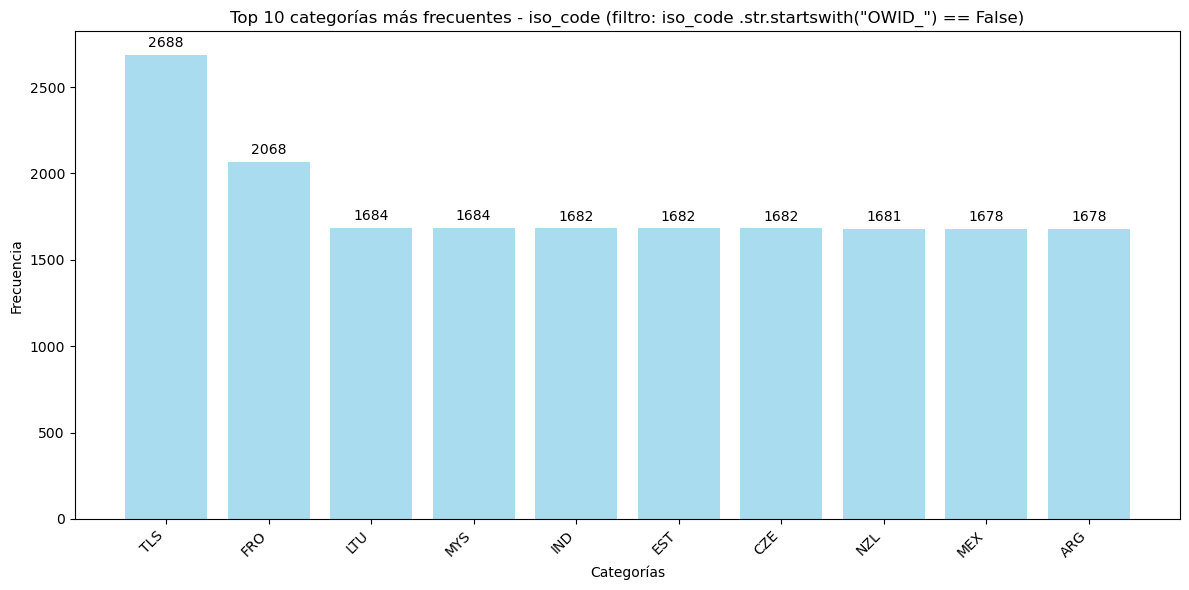

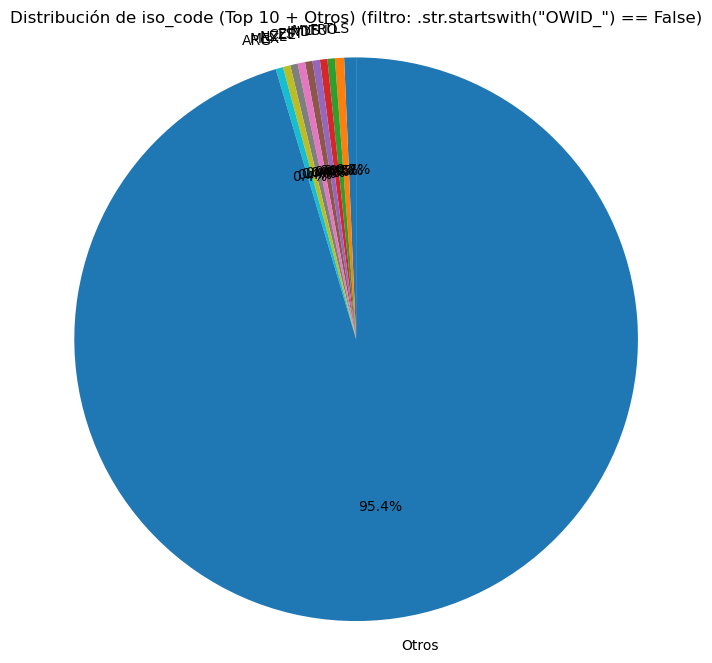

=============== Frecuencia de valores ===============
Datos filtrados: iso_code .str.startswith("OWID_") == False
iso_code
TLS    2688
FRO    2068
LTU    1684
MYS    1684
IND    1682
       ... 
WSM    1674
HKG    1654
TWN    1348
MAC     795
ESH       1
Name: count, Length: 237, dtype: int64
RESUMEN ESTADÍSTICO - iso_code (filtro: .str.startswith("OWID_") == False)
Total de registros: 395,311
Categorías únicas: 237
Categoría más frecuente: 'TLS'  (2,688 veces,  0.7%)
Categoría menos frecuente: 'ESH'  (1 veces,  0.0%)
Concentración top 10:  4.6% de los datos


In [18]:
filtro = '.str.startswith("OWID_") == False'
info = analizar_variable_categorica(df, col, filtro=filtro)

237 códigos de país, corresponden a los códigos ISO 3166-1 alfa-3; actualmente están asignados oficialmente 249 códigos ISO, y representan países, territorios dependientes y zonas especiales de interés geográfico.

2. Códigos propios de OWID

Filtro aplicado: iso_code .str.startswith("OWID_")
Registros después del filtrado: 34,124 (de 429,435)



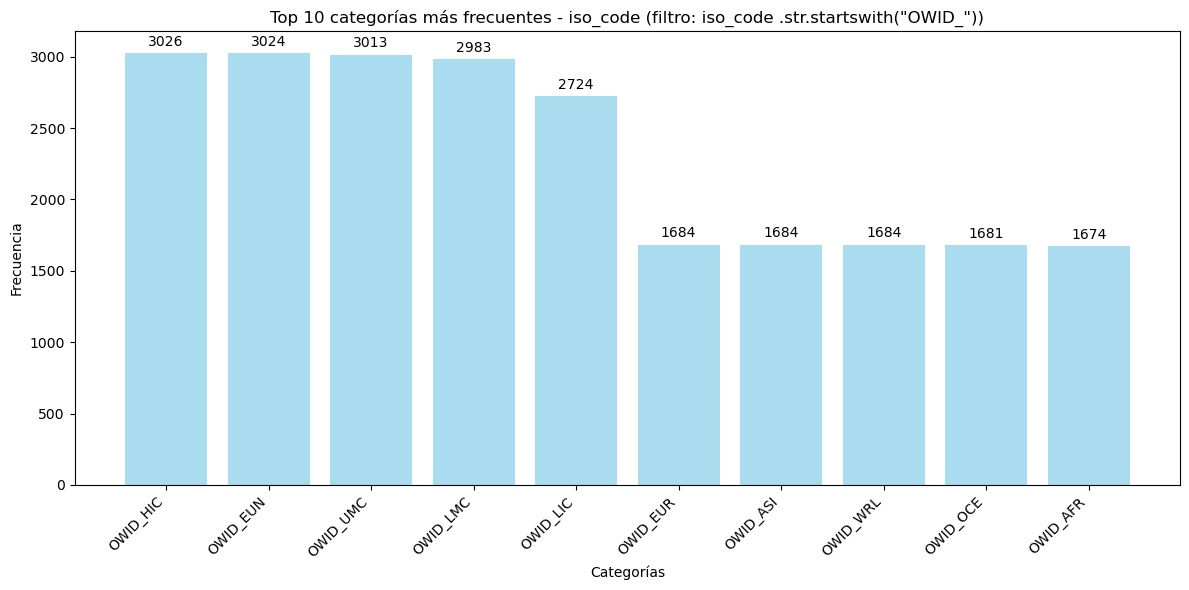

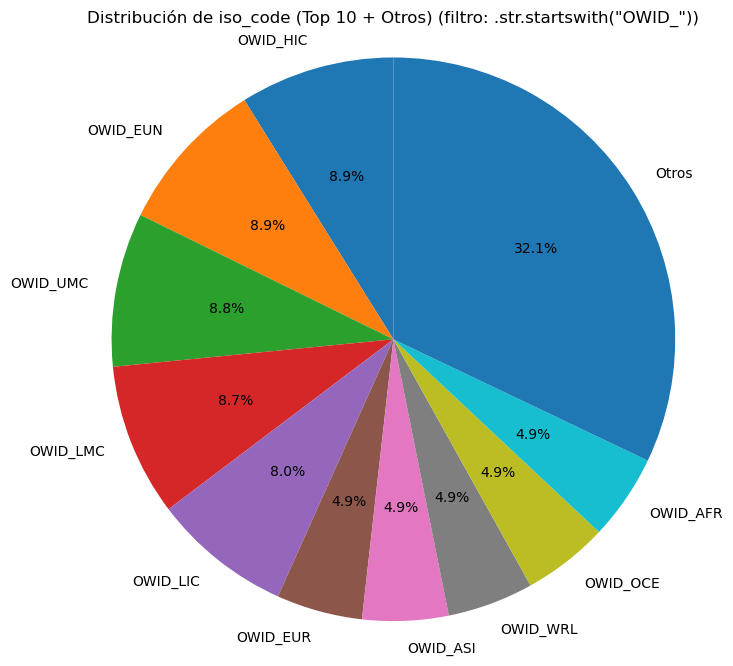

=============== Frecuencia de valores ===============
Datos filtrados: iso_code .str.startswith("OWID_")
iso_code
OWID_HIC    3026
OWID_EUN    3024
OWID_UMC    3013
OWID_LMC    2983
OWID_LIC    2724
OWID_EUR    1684
OWID_ASI    1684
OWID_WRL    1684
OWID_OCE    1681
OWID_AFR    1674
OWID_NAM    1674
OWID_KOS    1674
OWID_SAM    1674
OWID_NIR    1372
OWID_ENG    1359
OWID_SCT    1305
OWID_WLS    1198
OWID_CYN     691
Name: count, dtype: int64
RESUMEN ESTADÍSTICO - iso_code (filtro: .str.startswith("OWID_"))
Total de registros: 34,124
Categorías únicas: 18
Categoría más frecuente: 'OWID_HIC'  (3,026 veces,  8.9%)
Categoría menos frecuente: 'OWID_CYN'  (691 veces,  2.0%)
Concentración top 10:  67.9% de los datos


In [19]:
filtro = '.str.startswith("OWID_")'
info = analizar_variable_categorica(df, col, filtro=filtro)

18 códigos OWID, no vamos a usarlos ya que son agrupaciones de países y territorios ya incluidos en los datos de códigos de países. Por tanto, vamos a eliminar estos registros (un 8% del total).

In [20]:
df = df[~df['iso_code'].str.startswith("OWID_")]

In [21]:
filtro = '.str.startswith("OWID_")'
info = analizar_variable_categorica(df, col, filtro=filtro)

Filtro aplicado: iso_code .str.startswith("OWID_")
Registros después del filtrado: 0 (de 395,311)

ADVERTENCIA: No quedan datos después de aplicar el filtro  iso_code .str.startswith("OWID_")


- <b>date</b>

Fechas de los datos entre el 1 de Enero de 2020 y el 14 de Agosto de 2024. No hay valores nulos.

In [22]:
show_column(df, 'date')

date
count                         395311
mean   2022-04-20 00:08:07.393470464
min              2020-01-01 00:00:00
25%              2021-02-28 00:00:00
50%              2022-04-19 00:00:00
75%              2023-06-11 00:00:00
max              2024-08-14 00:00:00

--------------------------------------------------


date
0      2020-01-05
1      2020-01-06
2      2020-01-07
3      2020-01-08
4      2020-01-09
...           ...
429430 2024-07-31
429431 2024-08-01
429432 2024-08-02
429433 2024-08-03
429434 2024-08-04

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
date      
2022-02-26    238
2022-01-13    238
2022-02-25    238
2022-02-14    238
2022-02-24    238
             ... 
2020-01-01      2
2020-01-03      2
2020-01-02      2
2024-08-13      2
2024-08-14      2
Name: count, Length: 1688, dtype: int64
--------------------------------------------------
Valores únicos: date    1688
dtype: int64
--------------------------------------------------
Valores a cero: date
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


Vamos a ver el formato de esta columna de fecha

In [23]:
df['date'].dtype

dtype('<M8[ns]')

Formato datetime, lo dejamos así.

<b>2. Casos</b>

- <b>total_cases</b>

7% de valores a cero y 1% de valores nulos

In [24]:
show_column(df, 'total_cases')

total_cases
count        390042.0
mean   1834173.112252
std    7873276.679592
min               0.0
25%            5507.0
50%           50310.0
75%          571596.0
max       103436829.0

--------------------------------------------------


total_cases
0                 0
1                 0
2                 0
3                 0
4                 0
...             ...
429430       266386
429431       266386
429432       266386
429433       266386
429434       266386

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_cases
0              29017
1               1617
26              1576
4               1485
3                987
               ...  
122796             1
108582             1
79387              1
74443              1
16185              1
Name: count, Length: 33782, dtype: int64
--------------------------------------------------
Valores únicos: total_cases    33782
dtype: int64
--------------------------------------------------
Valores a cero: total_cases
False    366294
True      29017
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 5269


- <b>new_cases</b>

Tenemos un 90% de valores a cero, lo que es razonable puesto que podemos no tener nuevos casos. Además, tenemos un 2% de valores nulos.

In [25]:
show_column(df, 'new_cases')

new_cases
count      388397.0
mean     1997.08231
std    86042.985221
min             0.0
25%             0.0
50%             0.0
75%             0.0
max      40475477.0

--------------------------------------------------


new_cases
0               0
1               0
2               0
3               0
4               0
...           ...
429430          0
429431          0
429432          0
429433          0
429434          0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_cases
0            349654
1              1062
2               777
3               626
4               493
              ...  
1961912           1
1998392           1
2115100           1
2172063           1
2188710           1
Name: count, Length: 11921, dtype: int64
--------------------------------------------------
Valores únicos: new_cases    11921
dtype: int64
--------------------------------------------------
Valores a cero: new_cases
True     349654
False     45657
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 6914


- <b>new_cases_smoothed</b>

Media suavizada (media móvil de 7 días de nuevos casos)

30% de valores a cero y 2% de valores nulos.

In [26]:
show_column(df, 'new_cases_smoothed')

new_cases_smoothed
count            387232.0
mean           2002.98584
std          32517.210938
min                   0.0
25%                   0.0
50%                  8.71
75%            204.429993
max             5782211.0

--------------------------------------------------


new_cases_smoothed
0                     <NA>
1                     <NA>
2                     <NA>
3                     <NA>
4                     <NA>
...                    ...
429430                 0.0
429431                 0.0
429432                 0.0
429433                 0.0
429434                 0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_cases_smoothed
0.0                   116389
0.14                    7400
0.29                    5427
0.43                    4376
0.57                    3445
                       ...  
314177.4375                7
591.710022                 7
197285.0                   7
907.140015                 1
831.140015                 1
Name: count, Length: 11921, dtype: int64
--------------------------------------------------
Valores únicos: new_cases_smoothed    11921
dtype: int64
--------------------------------------------------
Valores a cero: new_cases_smoothed
False    278922
True     116389
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 8079


- <b>total_cases_per_million</b>

7% de valores a cero y 1% de valores nulos.

In [27]:
show_column(df, 'total_cases_per_million')

total_cases_per_million
count                 390042.0
mean              112983.03125
std              164315.765625
min                        0.0
25%                 1746.77002
50%               28888.320312
75%              156236.828125
max                 763598.625

--------------------------------------------------


total_cases_per_million
0                           0.0
1                           0.0
2                           0.0
3                           0.0
4                           0.0
...                         ...
429430             16577.570312
429431             16577.570312
429432             16577.570312
429433             16577.570312
429434             16577.570312

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_cases_per_million
0.0                        29080
50682.261719                1387
1746.77002                   897
641351.625                   883
213714.421875                862
                           ...  
11959.139648                   1
8099.129883                    1
5984.049805                    1
2404.669922                    1
763598.625                     1
Name: count, Length: 38194, dtype: int64
--------------------------------------------------
Valores únicos: total_cases_per_million    38194
dtype: int64
--------------------------------------------------
Valores a cero: total_cases_per_million
False    366231
True      29080
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 5269


- <b>new_cases_per_million</b>

90% de valores a cero y 2% de valores nulos.

In [28]:
show_column(df, 'new_cases_per_million')

new_cases_per_million
count               388397.0
mean               123.41433
std              1541.798584
min                      0.0
25%                      0.0
50%                      0.0
75%                      0.0
max            241758.234375

--------------------------------------------------


new_cases_per_million
0                         0.0
1                         0.0
2                         0.0
3                         0.0
4                         0.0
...                       ...
429430                    0.0
429431                    0.0
429432                    0.0
429433                    0.0
429434                    0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_cases_per_million
0.0                      349661
0.06                         96
0.04                         83
0.22                         80
0.11                         76
                          ...  
44421.28125                   1
44602.671875                  1
45213.738281                  1
63916.800781                  1
71.43                         1
Name: count, Length: 23606, dtype: int64
--------------------------------------------------
Valores únicos: new_cases_per_million    23606
dtype: int64
--------------------------------------------------
Valores a cero: new_cases_per_million
True     349661
False     45650
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 6914


- <b>new_cases_smoothed_per_million</b>

30% de valores a cero y 2% de valores nulos.

In [29]:
show_column(df, 'new_cases_smoothed_per_million')

new_cases_smoothed_per_million
count                        387232.0
mean                       123.774132
std                          572.2547
min                               0.0
25%                               0.0
50%                              2.38
75%                         53.529999
max                      34536.890625

--------------------------------------------------


new_cases_smoothed_per_million
0                                 <NA>
1                                 <NA>
2                                 <NA>
3                                 <NA>
4                                 <NA>
...                                ...
429430                             0.0
429431                             0.0
429432                             0.0
429433                             0.0
429434                             0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_cases_smoothed_per_million
0.0                               117618
0.02                                3131
0.01                                2957
0.04                                2297
0.03                                1997
                                   ...  
8112.189941                            7
62.700001                              7
34.529999                              1
90.349998                              1
79.82                                  1
Name: count, Length: 15797, dtype: int64
--------------------------------------------------
Valores únicos: new_cases_smoothed_per_million    15797
dtype: int64
--------------------------------------------------
Valores a cero: new_cases_smoothed_per_million
False    277693
True     117618
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 8079


<b>3. Muertes</b>

- <b>total_deaths</b>

13% de valores a cero y 1% de valores nulos.

In [30]:
show_column(df, 'total_deaths')

total_deaths
count      390042.0
mean   20526.021452
std    82791.848415
min             0.0
25%            37.0
50%           650.0
75%          7465.0
max       1193165.0

--------------------------------------------------


total_deaths
0                  0
1                  0
2                  0
3                  0
4                  0
...              ...
429430          5740
429431          5740
429432          5740
429433          5740
429434          5740

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_deaths
0               51927
1                6176
2                3803
21               2508
12               2347
                ...  
27399               1
21227               1
12245               1
9744                1
1193165             1
Name: count, Length: 14209, dtype: int64
--------------------------------------------------
Valores únicos: total_deaths    14209
dtype: int64
--------------------------------------------------
Valores a cero: total_deaths
False    343384
True      51927
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 5269


- <b>new_deaths</b>

94% de valores a cero y 2% de valores nulos.

In [31]:
show_column(df, 'new_deaths')

new_deaths
count    388846.0
mean    18.150569
std    315.559535
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       47687.0

--------------------------------------------------


new_deaths
0                0
1                0
2                0
3                0
4                0
...            ...
429430           0
429431           0
429432           0
429433           0
429434           0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_deaths
0             364038
1               3061
2               1786
3               1171
4                838
               ...  
976                1
986                1
990                1
991                1
4832               1
Name: count, Length: 2132, dtype: int64
--------------------------------------------------
Valores únicos: new_deaths    2132
dtype: int64
--------------------------------------------------
Valores a cero: new_deaths
True     364038
False     31273
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 6465


- <b>new_deaths_smoothed</b>

55% de valores a cero y 2% de valores nulos.

In [32]:
show_column(df, 'new_deaths_smoothed')

new_deaths_smoothed
count             387681.0
mean             18.203276
std             118.253433
min                    0.0
25%                    0.0
50%                    0.0
75%                    2.0
max            6812.430176

--------------------------------------------------


new_deaths_smoothed
0                      <NA>
1                      <NA>
2                      <NA>
3                      <NA>
4                      <NA>
...                     ...
429430                  0.0
429431                  0.0
429432                  0.0
429433                  0.0
429434                  0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_deaths_smoothed
0.0                    214144
0.14                    21391
0.29                    12496
0.43                     8192
0.57                     5854
                        ...  
139.429993                  7
140.860001                  7
141.429993                  7
141.570007                  7
690.289978                  7
Name: count, Length: 2132, dtype: int64
--------------------------------------------------
Valores únicos: new_deaths_smoothed    2132
dtype: int64
--------------------------------------------------
Valores a cero: new_deaths_smoothed
True     214144
False    181167
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 7630


- <b>total_deaths_per_million</b>

13% de valores a cero y 1% de valores nulos.

In [33]:
show_column(df, 'total_deaths_per_million')

total_deaths_per_million
count                  390042.0
mean                  825.58197
std                 1139.802734
min                         0.0
25%                   21.370001
50%                  261.730011
75%                 1266.579956
max                 6601.109863

--------------------------------------------------


total_deaths_per_million
0                            0.0
1                            0.0
2                            0.0
3                            0.0
4                            0.0
...                          ...
429430                357.209991
429431                357.209991
429432                357.209991
429433                357.209991
429434                357.209991

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_deaths_per_million
0.0                         51962
12.28                        1086
166.210007                    967
11.85                         939
612.559998                    925
                            ...  
1906.839966                     1
1745.569946                     1
834.809998                      1
483.929993                      1
393.079987                      1
Name: count, Length: 21723, dtype: int64
--------------------------------------------------
Valores únicos: total_deaths_per_million    21723
dtype: int64
--------------------------------------------------
Valores a cero: total_deaths_per_million
False    343349
True      51962
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 5269


- <b>new_deaths_per_million</b>

94% de valores a cero y 2% de valores nulos.

In [34]:
show_column(df, 'new_deaths_per_million')

new_deaths_per_million
count                388846.0
mean                 0.754993
std                  7.084625
min                       0.0
25%                       0.0
50%                       0.0
75%                       0.0
max                893.659973

--------------------------------------------------


new_deaths_per_million
0                          0.0
1                          0.0
2                          0.0
3                          0.0
4                          0.0
...                        ...
429430                     0.0
429431                     0.0
429432                     0.0
429433                     0.0
429434                     0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_deaths_per_million
0.0                       364164
0.04                         265
0.03                         234
0.06                         214
0.01                         208
                           ...  
177.949997                     1
179.979996                     1
181.399994                     1
182.460007                     1
182.679993                     1
Name: count, Length: 4313, dtype: int64
--------------------------------------------------
Valores únicos: new_deaths_per_million    4313
dtype: int64
--------------------------------------------------
Valores a cero: new_deaths_per_million
True     364164
False     31147
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 6465


- <b>new_deaths_smoothed_per_million</b>

57% de valores a cero y 2% de valores nulos.

In [35]:
show_column(df, 'new_deaths_smoothed_per_million')

new_deaths_smoothed_per_million
count                         387681.0
mean                          0.757192
std                           2.588488
min                                0.0
25%                                0.0
50%                                0.0
75%                               0.32
max                         127.660004

--------------------------------------------------


new_deaths_smoothed_per_million
0                                  <NA>
1                                  <NA>
2                                  <NA>
3                                  <NA>
4                                  <NA>
...                                 ...
429430                              0.0
429431                              0.0
429432                              0.0
429433                              0.0
429434                              0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_deaths_smoothed_per_million
0.0                                219875
0.01                                 9180
0.02                                 6574
0.03                                 4551
0.04                                 4299
                                    ...  
26.57                                   7
27.280001                               7
27.620001                               7
28.1                                    7
24.040001                               7
Name: count, Length: 1471, dtype: int64
--------------------------------------------------
Valores únicos: new_deaths_smoothed_per_million    1471
dtype: int64
--------------------------------------------------
Valores a cero: new_deaths_smoothed_per_million
True     219875
False    175436
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 7630


<b>4. Exceso de mortalidad</b>

- <b>excess_mortality</b>

0% de valores a cero, pero más valores nulos (casi 400.000) que válidos (menos de 15.000).

In [36]:
show_column(df, 'excess_mortality')

excess_mortality
count           13363.0
mean          10.928442
std           24.518597
min          -95.919998
25%               -1.47
50%                5.68
75%              15.575
max          378.220001

--------------------------------------------------


excess_mortality
0                   <NA>
1                   <NA>
2                   <NA>
3                   <NA>
4                   <NA>
...                  ...
429430              <NA>
429431              <NA>
429432              <NA>
429433              <NA>
429434              <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
excess_mortality
-0.0                21
-9.09               13
 6.08               12
 4.29               12
 3.59               12
                    ..
 159.169998          1
 144.089996          1
 145.460007          1
 188.300003          1
 189.559998          1
Name: count, Length: 5455, dtype: int64
--------------------------------------------------
Valores únicos: excess_mortality    5455
dtype: int64
--------------------------------------------------
Valores a cero: excess_mortality
False    395290
True         21
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 381948


- <b>excess_mortality_cumulative</b>

0% de valores a cero, pero más valores nulos (casi 400.000) que válidos (menos de 15.000).

In [37]:
show_column(df, 'excess_mortality_cumulative')

excess_mortality_cumulative
count                      13363.0
mean                      9.726572
std                      12.024263
min                         -44.23
25%                           2.03
50%                           8.12
75%                         15.085
max                      78.080002

--------------------------------------------------


excess_mortality_cumulative
0                              <NA>
1                              <NA>
2                              <NA>
3                              <NA>
4                              <NA>
...                             ...
429430                         <NA>
429431                         <NA>
429432                         <NA>
429433                         <NA>
429434                         <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
excess_mortality_cumulative
 8.09                          18
 8.02                          18
 6.28                          17
 5.04                          16
 8.13                          16
                               ..
-21.049999                      1
-20.91                          1
-20.83                          1
-20.780001                      1
 66.169998                      1
Name: count, Length: 4202, dtype: int64
--------------------------------------------------
Valores únicos: excess_mortality_cumulative    4202
dtype: int64
--------------------------------------------------
Valores a cero: excess_mortality_cumulative
False    395309
True          2
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 381948


- <b>excess_mortality_cumulative_absolute</b>

0% de valores a cero, pero más valores nulos (casi 400.000) que válidos (menos de 15.000).

In [38]:
show_column(df, 'excess_mortality_cumulative_absolute')

excess_mortality_cumulative_absolute
count                               13363.0
mean                           56234.054688
std                           157119.578125
min                           -37726.101562
25%                                   175.0
50%                             6915.200195
75%                            39269.953125
max                             1349776.375

--------------------------------------------------


excess_mortality_cumulative_absolute
0                                       <NA>
1                                       <NA>
2                                       <NA>
3                                       <NA>
4                                       <NA>
...                                      ...
429430                                  <NA>
429431                                  <NA>
429432                                  <NA>
429433                                  <NA>
429434                                  <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
excess_mortality_cumulative_absolute
-64.800003                              5
-3.2                                    5
-103.199997                             5
-68.199997                              4
-73.400002                              4
                                       ..
 1292256.0                              1
 1293706.625                            1
 1294427.375                            1
 1295063.375                            1
-31284.5                                1
Name: count, Length: 12569, dtype: int64
--------------------------------------------------
Valores únicos: excess_mortality_cumulative_absolute    12569
dtype: int64
--------------------------------------------------
Valores a cero: excess_mortality_cumulative_absolute
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 381948


- <b>excess_mortality_cumulative_per_million</b>

0% de valores a cero, pero más valores nulos (casi 400.000) que válidos (menos de 15.000).

In [39]:
show_column(df, 'excess_mortality_cumulative_per_million')

excess_mortality_cumulative_per_million
count                                  13363.0
mean                               1770.068726
std                                1993.603882
min                               -2936.449951
25%                                 116.050003
50%                                1266.619995
75%                                2878.120117
max                               10293.519531

--------------------------------------------------


excess_mortality_cumulative_per_million
0                                          <NA>
1                                          <NA>
2                                          <NA>
3                                          <NA>
4                                          <NA>
...                                         ...
429430                                     <NA>
429431                                     <NA>
429432                                     <NA>
429433                                     <NA>
429434                                     <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
excess_mortality_cumulative_per_million
-232.550003                                3
 94.510002                                 3
 33.450001                                 3
 69.669998                                 3
-252.25                                    3
                                          ..
 9931.280273                               1
 9932.280273                               1
 9934.580078                               1
 9934.910156                               1
-2936.449951                               1
Name: count, Length: 13045, dtype: int64
--------------------------------------------------
Valores únicos: excess_mortality_cumulative_per_million    13045
dtype: int64
--------------------------------------------------
Valores a cero: excess_mortality_cumulative_per_million
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 381948


<b>5. Hospitalizaciones y UCI</b>

- <b>hosp_patients</b>

1% de valores a cero, pero más valores nulos (unos 350.000) que válidos (menos de 40.000).

In [40]:
show_column(df, 'hosp_patients')

hosp_patients
count        35442.0
mean     4163.538344
std     10395.659985
min              0.0
25%            195.0
50%            831.0
75%           3223.0
max         154497.0

--------------------------------------------------


hosp_patients
0                <NA>
1                <NA>
2                <NA>
3                <NA>
4                <NA>
...               ...
429430           <NA>
429431           <NA>
429432           <NA>
429433           <NA>
429434           <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
hosp_patients
0                448
1                214
4                160
2                154
3                116
                ... 
117164             1
117528             1
118106             1
118988             1
119384             1
Name: count, Length: 9949, dtype: int64
--------------------------------------------------
Valores únicos: hosp_patients    9949
dtype: int64
--------------------------------------------------
Valores a cero: hosp_patients
False    394863
True        448
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 359869


- <b>hosp_patients_per_million</b>

1% de valores a cero, pero más valores nulos (unos 350.000) que válidos (menos de 40.000).

In [41]:
show_column(df, 'hosp_patients_per_million')

hosp_patients_per_million
count                    35442.0
mean                  126.595818
std                   156.754349
min                          0.0
25%                    29.639999
50%                    70.889999
75%                   157.684998
max                  1526.849976

--------------------------------------------------


hosp_patients_per_million
0                            <NA>
1                            <NA>
2                            <NA>
3                            <NA>
4                            <NA>
...                           ...
429430                       <NA>
429431                       <NA>
429432                       <NA>
429433                       <NA>
429434                       <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
hosp_patients_per_million
0.0                          448
25.41                        171
50.82                        116
101.639999                    77
76.230003                     69
                            ... 
1134.23999                     1
1136.420044                    1
1140.790039                    1
1140.819946                    1
1141.079956                    1
Name: count, Length: 17223, dtype: int64
--------------------------------------------------
Valores únicos: hosp_patients_per_million    17223
dtype: int64
--------------------------------------------------
Valores a cero: hosp_patients_per_million
False    394863
True        448
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 359869


- <b>weekly_hosp_admissions</b>

0% de valores a cero, pero más valores nulos (unos 375.000) que válidos (menos de 25.000).

In [42]:
show_column(df, 'weekly_hosp_admissions')

weekly_hosp_admissions
count                 19666.0
mean              4905.885691
std              11985.574723
min                       0.0
25%                     313.0
50%                    1057.5
75%                   4439.25
max                  153977.0

--------------------------------------------------


weekly_hosp_admissions
0                         <NA>
1                         <NA>
2                         <NA>
3                         <NA>
4                         <NA>
...                        ...
429430                    <NA>
429431                    <NA>
429432                    <NA>
429433                    <NA>
429434                    <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
weekly_hosp_admissions
1                         54
0                         52
6                         44
11                        41
24                        39
                          ..
106042                     1
106218                     1
123493                     1
3546                       1
3551                       1
Name: count, Length: 7696, dtype: int64
--------------------------------------------------
Valores únicos: weekly_hosp_admissions    7696
dtype: int64
--------------------------------------------------
Valores a cero: weekly_hosp_admissions
False    395259
True         52
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 375645


- <b>weekly_hosp_admissions_per_million</b>

0% de valores a cero, pero más valores nulos (unos 375.000) que válidos (menos de 25.000).

In [43]:
show_column(df, 'weekly_hosp_admissions_per_million')

weekly_hosp_admissions_per_million
count                             19666.0
mean                            82.760475
std                             91.498512
min                                   0.0
25%                               23.6525
50%                             54.720001
75%                            108.637497
max                            717.080017

--------------------------------------------------


weekly_hosp_admissions_per_million
0                                     <NA>
1                                     <NA>
2                                     <NA>
3                                     <NA>
4                                     <NA>
...                                    ...
429430                                <NA>
429431                                <NA>
429432                                <NA>
429433                                <NA>
429434                                <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
weekly_hosp_admissions_per_million
0.0                                   52
1.05                                  24
1.24                                  19
0.57                                  16
6.63                                  16
                                      ..
641.98999                              1
643.469971                             1
647.419983                             1
647.98999                              1
217.740005                             1
Name: count, Length: 10972, dtype: int64
--------------------------------------------------
Valores únicos: weekly_hosp_admissions_per_million    10972
dtype: int64
--------------------------------------------------
Valores a cero: weekly_hosp_admissions_per_million
False    395259
True         52
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 375645


- <b>icu_patients</b>

2% de valores a cero, pero más valores nulos (unos 350.000) que válidos (menos de 40.000).

In [44]:
show_column(df, 'icu_patients')

icu_patients
count       34825.0
mean     720.278335
std      2254.89395
min             0.0
25%            24.0
50%           104.0
75%           471.0
max         28891.0

--------------------------------------------------


icu_patients
0               <NA>
1               <NA>
2               <NA>
3               <NA>
4               <NA>
...              ...
429430          <NA>
429431          <NA>
429432          <NA>
429433          <NA>
429434          <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
icu_patients
0               844
1               805
2               524
3               466
10              373
               ... 
25972             1
25998             1
26006             1
25747             1
25781             1
Name: count, Length: 4098, dtype: int64
--------------------------------------------------
Valores únicos: icu_patients    4098
dtype: int64
--------------------------------------------------
Valores a cero: icu_patients
False    394467
True        844
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 360486


- <b>icu_patients_per_million</b>

2% de valores a cero, pero más valores nulos (unos 350.000) que válidos (menos de 40.000).

In [45]:
show_column(df, 'icu_patients_per_million')

icu_patients_per_million
count                   34825.0
mean                  16.505033
std                   23.737654
min                         0.0
25%                        2.37
50%                        6.68
75%                   20.809999
max                  180.679993

--------------------------------------------------


icu_patients_per_million
0                           <NA>
1                           <NA>
2                           <NA>
3                           <NA>
4                           <NA>
...                          ...
429430                      <NA>
429431                      <NA>
429432                      <NA>
429433                      <NA>
429434                      <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
icu_patients_per_million
0.0                         844
1.54                        232
3.09                        170
0.04                        145
4.63                        111
                           ... 
171.550003                    1
171.600006                    1
171.759995                    1
171.910004                    1
171.979996                    1
Name: count, Length: 6167, dtype: int64
--------------------------------------------------
Valores únicos: icu_patients_per_million    6167
dtype: int64
--------------------------------------------------
Valores a cero: icu_patients_per_million
False    394467
True        844
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 360486


- <b>weekly_icu_admissions</b>

2% de valores a cero, pero más valores nulos (casi 400.000) que válidos (menos de 15.000).

In [46]:
show_column(df, 'weekly_icu_admissions')

weekly_icu_admissions
count                10993.0
mean              317.894114
std                514.41291
min                      0.0
25%                     17.0
50%                     92.0
75%                    353.0
max                   4838.0

--------------------------------------------------


weekly_icu_admissions
0                        <NA>
1                        <NA>
2                        <NA>
3                        <NA>
4                        <NA>
...                       ...
429430                   <NA>
429431                   <NA>
429432                   <NA>
429433                   <NA>
429434                   <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
weekly_icu_admissions
1                        322
2                        258
0                        236
3                        227
4                        192
                        ... 
2645                       1
2647                       1
2678                       1
2697                       1
2716                       1
Name: count, Length: 1676, dtype: int64
--------------------------------------------------
Valores únicos: weekly_icu_admissions    1676
dtype: int64
--------------------------------------------------
Valores a cero: weekly_icu_admissions
False    395075
True        236
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 384318


- <b>weekly_icu_admissions_per_million</b>

2% de valores a cero, pero más valores nulos (casi 400.000) que válidos (menos de 15.000).

In [47]:
show_column(df, 'weekly_icu_admissions_per_million')

weekly_icu_admissions_per_million
count                            10993.0
mean                            9.672019
std                            13.573954
min                                  0.0
25%                                 1.55
50%                                 4.64
75%                                12.65
max                           224.979996

--------------------------------------------------


weekly_icu_admissions_per_million
0                                    <NA>
1                                    <NA>
2                                    <NA>
3                                    <NA>
4                                    <NA>
...                                   ...
429430                               <NA>
429431                               <NA>
429432                               <NA>
429433                               <NA>
429434                               <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
weekly_icu_admissions_per_million
0.0                                  236
0.19                                  84
0.95                                  76
0.1                                   73
1.27                                  62
                                    ... 
71.980003                              1
72.029999                              1
72.230003                              1
16.0                                   1
72.690002                              1
Name: count, Length: 2712, dtype: int64
--------------------------------------------------
Valores únicos: weekly_icu_admissions_per_million    2712
dtype: int64
--------------------------------------------------
Valores a cero: weekly_icu_admissions_per_million
False    395075
True        236
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 384318


<b>6. Test de diagnóstico</b>

- <b>total_tests</b>

0% de valores a cero, pero más valores nulos (más de 300.000) que válidos (menos de 90.000).

In [48]:
show_column(df, 'total_tests')

total_tests
count          79199.0
mean   21151700.748759
std    84192879.977338
min                0.0
25%           362445.5
50%          2082570.0
75%         10295176.5
max       9214000000.0

--------------------------------------------------


total_tests
0              <NA>
1              <NA>
2              <NA>
3              <NA>
4              <NA>
...             ...
429430         <NA>
429431         <NA>
429432         <NA>
429433         <NA>
429434         <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_tests
2              12
1              10
4               9
5               8
3               7
               ..
887842502       1
888220872       1
888998375       1
890124308       1
891269590       1
Name: count, Length: 77860, dtype: int64
--------------------------------------------------
Valores únicos: total_tests    77860
dtype: int64
--------------------------------------------------
Valores a cero: total_tests
False    395310
True          1
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 316112


- <b>new_tests</b>

0% de valores a cero, pero más valores nulos (unos 325.000) que válidos (menos de 80.000).

In [49]:
show_column(df, 'new_tests')

new_tests
count        75300.0
mean    67371.846946
std    247892.322018
min              1.0
25%           2247.0
50%           8805.5
75%         37326.75
max       35855632.0

--------------------------------------------------


new_tests
0            <NA>
1            <NA>
2            <NA>
3            <NA>
4            <NA>
...           ...
429430       <NA>
429431       <NA>
429432       <NA>
429433       <NA>
429434       <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_tests
1            98
2            75
4            61
5            58
7            51
             ..
2123232       1
2123782       1
2125501       1
2127953       1
2131656       1
Name: count, Length: 38677, dtype: int64
--------------------------------------------------
Valores únicos: new_tests    38677
dtype: int64
--------------------------------------------------
Valores a cero: new_tests
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 320011


- <b>new_tests_smoothed</b>

0% de valores a cero, pero más valores nulos (casi 300.000) que válidos (unos 100.000).

In [50]:
show_column(df, 'new_tests_smoothed')

new_tests_smoothed
count            103580.0
mean        142694.873953
std        1140296.441988
min                   0.0
25%                1492.0
50%                6630.5
75%              32409.75
max            14769984.0

--------------------------------------------------


new_tests_smoothed
0                     <NA>
1                     <NA>
2                     <NA>
3                     <NA>
4                     <NA>
...                    ...
429430                <NA>
429431                <NA>
429432                <NA>
429433                <NA>
429434                <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_tests_smoothed
14769984              607
13                    457
955                   366
1786                  284
616                   243
                     ... 
7260226                 1
9137665                 1
11015105                1
12892544                1
235115                  1
Name: count, Length: 44383, dtype: int64
--------------------------------------------------
Valores únicos: new_tests_smoothed    44383
dtype: int64
--------------------------------------------------
Valores a cero: new_tests_smoothed
False    395126
True        185
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 291731


- <b>total_tests_per_thousand</b> (por cada 1.000 habitantes)

0% de valores a cero, pero más valores nulos (más de 300.000) que válidos (menos de 90.000).

In [51]:
show_column(df, 'total_tests_per_thousand')

total_tests_per_thousand
count                   79199.0
mean                 924.781555
std                 2197.977539
min                         0.0
25%                   43.349998
50%                  232.679993
75%                  894.275024
max                32925.828125

--------------------------------------------------


total_tests_per_thousand
0                           <NA>
1                           <NA>
2                           <NA>
3                           <NA>
4                           <NA>
...                          ...
429430                      <NA>
429431                      <NA>
429432                      <NA>
429433                      <NA>
429434                      <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_tests_per_thousand
0.0                         243
0.01                        186
0.02                        156
0.03                         89
0.04                         86
                           ... 
32622.650391                  1
32715.519531                  1
32790.21875                   1
32850.820312                  1
29975.880859                  1
Name: count, Length: 51777, dtype: int64
--------------------------------------------------
Valores únicos: total_tests_per_thousand    51777
dtype: int64
--------------------------------------------------
Valores a cero: total_tests_per_thousand
False    395068
True        243
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 316112


- <b>new_tests_per_thousand</b>

1% de valores a cero, pero más valores nulos (unos 320.000) que válidos (menos de 80.000).

In [52]:
show_column(df, 'new_tests_per_thousand')

new_tests_per_thousand
count                 75300.0
mean                 3.273795
std                  9.039679
min                       0.0
25%                      0.28
50%                      0.97
75%                      2.91
max                531.059998

--------------------------------------------------


new_tests_per_thousand
0                         <NA>
1                         <NA>
2                         <NA>
3                         <NA>
4                         <NA>
...                        ...
429430                    <NA>
429431                    <NA>
429432                    <NA>
429433                    <NA>
429434                    <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_tests_per_thousand
0.04                      1109
0.06                      1099
0.01                      1005
0.02                       993
0.08                       945
                          ... 
122.599998                   1
122.860001                   1
122.989998                   1
123.019997                   1
142.979996                   1
Name: count, Length: 3560, dtype: int64
--------------------------------------------------
Valores únicos: new_tests_per_thousand    3560
dtype: int64
--------------------------------------------------
Valores a cero: new_tests_per_thousand
False    394384
True        927
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 320011


- <b>new_tests_smoothed_per_thousand</b>

2% de valores a cero, pero más valores nulos (casi 300.000) que válidos (unos 100.000).

In [53]:
show_column(df, 'new_tests_smoothed_per_thousand')

new_tests_smoothed_per_thousand
count                         103580.0
mean                          2.830159
std                           7.320678
min                                0.0
25%                                0.2
50%                               0.85
75%                               2.58
max                         147.600006

--------------------------------------------------


new_tests_smoothed_per_thousand
0                                  <NA>
1                                  <NA>
2                                  <NA>
3                                  <NA>
4                                  <NA>
...                                 ...
429430                             <NA>
429431                             <NA>
429432                             <NA>
429433                             <NA>
429434                             <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_tests_smoothed_per_thousand
0.02                               2339
0.01                               2195
0.06                               2074
0.04                               1899
0.0                                1684
                                   ... 
103.959999                            1
105.720001                            1
110.269997                            1
110.370003                            1
115.459999                            1
Name: count, Length: 3601, dtype: int64
--------------------------------------------------
Valores únicos: new_tests_smoothed_per_thousand    3601
dtype: int64
--------------------------------------------------
Valores a cero: new_tests_smoothed_per_thousand
False    393627
True       1684
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 291731


- <b>positive_rate</b>

11% de valores a cero, pero más valores nulos (unos 300.000) que válidos (menos de 100.000).

In [54]:
show_column(df, 'positive_rate')

positive_rate
count        95542.0
mean         0.09828
std         0.116215
min              0.0
25%             0.02
50%             0.06
75%             0.14
max              1.0

--------------------------------------------------


positive_rate
0                <NA>
1                <NA>
2                <NA>
3                <NA>
4                <NA>
...               ...
429430           <NA>
429431           <NA>
429432           <NA>
429433           <NA>
429434           <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
positive_rate
0.01             11357
0.0              10477
0.02              8924
0.03              6513
0.04              5583
                 ...  
0.91                 3
0.99                 3
0.86                 2
0.94                 1
0.98                 1
Name: count, Length: 101, dtype: int64
--------------------------------------------------
Valores únicos: positive_rate    101
dtype: int64
--------------------------------------------------
Valores a cero: positive_rate
False    384834
True      10477
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 299769


- <b>tests_per_case</b> (pruebas realizadas por cada caso confirmado)

0% de valores a cero, pero más valores nulos (unos 300.000) que válidos (menos de 100.000).

In [55]:
show_column(df, 'tests_per_case')

tests_per_case
count         93963.0
mean      2413.160156
std      33511.882812
min               1.0
25%               7.1
50%              17.5
75%         54.299999
max       1023631.875

--------------------------------------------------


tests_per_case
0                 <NA>
1                 <NA>
2                 <NA>
3                 <NA>
4                 <NA>
...                ...
429430            <NA>
429431            <NA>
429432            <NA>
429433            <NA>
429434            <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
tests_per_case
4.1               545
3.7               543
4.3               537
4.2               537
3.4               536
                 ... 
384.0               1
384.399994          1
384.5               1
384.600006          1
384.700012          1
Name: count, Length: 7074, dtype: int64
--------------------------------------------------
Valores únicos: tests_per_case    7074
dtype: int64
--------------------------------------------------
Valores a cero: tests_per_case
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 301348


<b>- tests_units</b>

0% de valores a cero, pero más valores nulos (casi 300.000) que válidos (cerca de 110.000).

In [56]:
show_column(df, 'tests_units')

tests_units
count            106396
unique                4
top     tests performed
freq              79707

--------------------------------------------------


tests_units
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
...            ...
429430         NaN
429431         NaN
429432         NaN
429433         NaN
429434         NaN

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
tests_units    
tests performed    79707
people tested      16257
samples tested      9591
units unclear        841
Name: count, dtype: int64
--------------------------------------------------
Valores únicos: tests_units    4
dtype: int64
--------------------------------------------------
Valores a cero: tests_units
False    106396
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 288915


<b>7. Vacunación</b>

- <b>total_vaccinations</b>

0% de valores a cero, pero más valores nulos (casi 350.000) que válidos (unos 70.000).

In [57]:
show_column(df, 'total_vaccinations')

total_vaccinations
count             66535.0
mean      96763608.362155
std       375375971.23118
min                   0.0
25%             1291186.0
50%             8956625.0
75%            43285107.0
max          3491077000.0

--------------------------------------------------


total_vaccinations
0                     <NA>
1                     <NA>
2                     <NA>
3                     <NA>
4                     <NA>
...                    ...
429430                <NA>
429431                <NA>
429432                <NA>
429433                <NA>
429434                <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_vaccinations
0                     101
401308016              33
3171667                10
334842984               9
209673612               8
                     ... 
3450244000              1
3451677000              1
3453156000              1
3454559000              1
3455859000              1
Name: count, Length: 65796, dtype: int64
--------------------------------------------------
Valores únicos: total_vaccinations    65796
dtype: int64
--------------------------------------------------
Valores a cero: total_vaccinations
False    395210
True        101
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 328776


- <b>people_vaccinated</b>

0% de valores a cero, pero más valores nulos (casi 350.000) que válidos (unos 60.000).

In [58]:
show_column(df, 'people_vaccinated')

people_vaccinated
count            62543.0
mean     35620057.200406
std     133538991.709375
min                  0.0
25%             674010.5
50%            4332679.0
75%           20433593.5
max         1310292000.0

--------------------------------------------------


people_vaccinated
0                    <NA>
1                    <NA>
2                    <NA>
3                    <NA>
4                    <NA>
...                   ...
429430               <NA>
429431               <NA>
429432               <NA>
429433               <NA>
429434               <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
people_vaccinated
0                    93
5823245              28
1123773              20
870179               18
1957180              18
                     ..
1310096000            1
1310189000            1
1310207000            1
1310267000            1
50927791              1
Name: count, Length: 60151, dtype: int64
--------------------------------------------------
Valores únicos: people_vaccinated    60151
dtype: int64
--------------------------------------------------
Valores a cero: people_vaccinated
False    395218
True         93
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 332768


- <b>people_fully_vaccinated</b>

0% de valores a cero, pero más valores nulos (casi 350.000) que válidos (unos 60.000).

In [59]:
show_column(df, 'people_fully_vaccinated')

people_fully_vaccinated
count                  59453.0
mean           32330879.509646
std           122699978.839887
min                        1.0
25%                   651588.0
50%                  4064649.0
75%                 18759075.0
max               1276760000.0

--------------------------------------------------


people_fully_vaccinated
0                          <NA>
1                          <NA>
2                          <NA>
3                          <NA>
4                          <NA>
...                         ...
429430                     <NA>
429431                     <NA>
429432                     <NA>
429433                     <NA>
429434                     <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
people_fully_vaccinated
34900613                   61
1                          59
6895763                    45
2078005                    34
6895762                    32
                           ..
1276302000                  1
1276517000                  1
1276549000                  1
1276661000                  1
47856499                    1
Name: count, Length: 56603, dtype: int64
--------------------------------------------------
Valores únicos: people_fully_vaccinated    56603
dtype: int64
--------------------------------------------------
Valores a cero: people_fully_vaccinated
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 335858


- <b>total_boosters</b> (dosis de refuerzo)

0% de valores a cero, pero más valores nulos (unos 350.000) que válidos (unos 40.000).

In [60]:
show_column(df, 'total_boosters')

total_boosters
count          37390.0
mean   17141469.741963
std    42832482.789348
min                1.0
25%           395398.0
50%          3343184.0
75%        16389785.25
max        826913000.0

--------------------------------------------------


total_boosters
0                 <NA>
1                 <NA>
2                 <NA>
3                 <NA>
4                 <NA>
...                ...
429430            <NA>
429431            <NA>
429432            <NA>
429433            <NA>
429434            <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_boosters
7                 111
2                 108
6                  92
1                  91
5                  79
                 ... 
825855000           1
826531000           1
826583000           1
826772000           1
750189000           1
Name: count, Length: 34051, dtype: int64
--------------------------------------------------
Valores únicos: total_boosters    34051
dtype: int64
--------------------------------------------------
Valores a cero: total_boosters
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 357921


- <b>new_vaccinations</b> (nuevas dosis aplicadas diarias)

0% de valores a cero, pero más valores nulos (unos 350.000) que válidos (menos de 60.000).

In [61]:
show_column(df, 'new_vaccinations')

new_vaccinations
count           52293.0
mean      204420.730691
std      1014519.217754
min                 0.0
25%              1251.0
50%             12152.0
75%             78495.0
max          24741000.0

--------------------------------------------------


new_vaccinations
0                   <NA>
1                   <NA>
2                   <NA>
3                   <NA>
4                   <NA>
...                  ...
429430              <NA>
429431              <NA>
429432              <NA>
429433              <NA>
429434              <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_vaccinations
1                   222
2                   189
4                   157
3                   145
5                   137
                   ... 
7972                  1
7974                  1
7975                  1
7977                  1
7952                  1
Name: count, Length: 32620, dtype: int64
--------------------------------------------------
Valores únicos: new_vaccinations    32620
dtype: int64
--------------------------------------------------
Valores a cero: new_vaccinations
False    395197
True        114
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 343018


- <b>new_vaccinations_smoothed</b>

2% de valores a cero, pero más valores nulos (cerca de 220.000) que válidos (menos de 200.000).

In [62]:
show_column(df, 'new_vaccinations_smoothed')

new_vaccinations_smoothed
count                   175111.0
mean                77423.109605
std                 550345.58043
min                          0.0
25%                        219.0
50%                       2877.0
75%                      21808.0
max                   22424286.0

--------------------------------------------------


new_vaccinations_smoothed
0                            <NA>
1                            <NA>
2                            <NA>
3                            <NA>
4                            <NA>
...                           ...
429430                       <NA>
429431                       <NA>
429432                       <NA>
429433                       <NA>
429434                       <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_vaccinations_smoothed
0                            4189
1                            1923
2                            1895
5                            1116
3                             982
                             ... 
19493286                        1
19729000                        1
19815286                        1
19875143                        1
19910000                        1
Name: count, Length: 50568, dtype: int64
--------------------------------------------------
Valores únicos: new_vaccinations_smoothed    50568
dtype: int64
--------------------------------------------------
Valores a cero: new_vaccinations_smoothed
False    391122
True       4189
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 220200


- <b>total_vaccinations_per_hundred</b>

0% de valores a cero, pero más valores nulos (cerca de 330.000) que válidos (menos de 70.000).

In [63]:
show_column(df, 'total_vaccinations_per_hundred')

total_vaccinations_per_hundred
count                         66535.0
mean                       120.513092
std                         86.849426
min                               0.0
25%                         40.504997
50%                        120.220001
75%                        193.509995
max                        410.230011

--------------------------------------------------


total_vaccinations_per_hundred
0                                 <NA>
1                                 <NA>
2                                 <NA>
3                                 <NA>
4                                 <NA>
...                                ...
429430                            <NA>
429431                            <NA>
429432                            <NA>
429433                            <NA>
429434                            <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_vaccinations_per_hundred
155.710007                        236
155.720001                        217
0.0                               210
244.940002                        134
214.080002                        115
                                 ... 
406.630005                          1
406.670013                          1
406.690002                          1
406.709991                          1
399.380005                          1
Name: count, Length: 24240, dtype: int64
--------------------------------------------------
Valores únicos: total_vaccinations_per_hundred    24240
dtype: int64
--------------------------------------------------
Valores a cero: total_vaccinations_per_hundred
False    395101
True        210
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 328776


- <b>people_vaccinated_per_hundred</b>

0% de valores a cero, pero más valores nulos (unos 330.000) que válidos (menos de 70.000).

In [64]:
show_column(df, 'people_vaccinated_per_hundred')

people_vaccinated_per_hundred
count                        62543.0
mean                       52.421486
std                        30.116489
min                              0.0
25%                        25.280001
50%                            60.43
75%                        78.239998
max                       129.070007

--------------------------------------------------


people_vaccinated_per_hundred
0                                <NA>
1                                <NA>
2                                <NA>
3                                <NA>
4                                <NA>
...                               ...
429430                           <NA>
429431                           <NA>
429432                           <NA>
429433                           <NA>
429434                           <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
people_vaccinated_per_hundred
72.5                             495
82.910004                        398
86.279999                        240
66.529999                        205
0.0                              200
                                ... 
126.519997                         1
126.550003                         1
126.559998                         1
126.599998                         1
126.629997                         1
Name: count, Length: 9590, dtype: int64
--------------------------------------------------
Valores únicos: people_vaccinated_per_hundred    9590
dtype: int64
--------------------------------------------------
Valores a cero: people_vaccinated_per_hundred
False    395111
True        200
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 332768


- <b>people_fully_vaccinated_per_hundred</b>

1% de valores a cero, pero más valores nulos (cerca de 330.000) que válidos (unos 60.000).

In [65]:
show_column(df, 'people_fully_vaccinated_per_hundred')

people_fully_vaccinated_per_hundred
count                              59453.0
mean                             47.875473
std                              29.773117
min                                    0.0
25%                              19.860001
50%                                  54.82
75%                                  74.75
max                             126.889999

--------------------------------------------------


people_fully_vaccinated_per_hundred
0                                      <NA>
1                                      <NA>
2                                      <NA>
3                                      <NA>
4                                      <NA>
...                                     ...
429430                                 <NA>
429431                                 <NA>
429432                                 <NA>
429433                                 <NA>
429434                                 <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
people_fully_vaccinated_per_hundred
0.0                                    475
81.18                                  435
65.709999                              401
30.639999                              298
81.209999                              294
                                      ... 
122.550003                               1
122.610001                               1
122.650002                               1
122.75                                   1
122.769997                               1
Name: count, Length: 9243, dtype: int64
--------------------------------------------------
Valores únicos: people_fully_vaccinated_per_hundred    9243
dtype: int64
--------------------------------------------------
Valores a cero: people_fully_vaccinated_per_hundred
False    394836
True        475
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 335858


- <b>total_boosters_per_hundred</b>

7% de valores a cero, pero más valores nulos (más de 350.000) que válidos (unos 40.000).

In [66]:
show_column(df, 'total_boosters_per_hundred')

total_boosters_per_hundred
count                     37390.0
mean                    37.438026
std                     30.874624
min                           0.0
25%                          7.01
50%                     35.650002
75%                         60.93
max                    150.470001

--------------------------------------------------


total_boosters_per_hundred
0                             <NA>
1                             <NA>
2                             <NA>
3                             <NA>
4                             <NA>
...                            ...
429430                        <NA>
429431                        <NA>
429432                        <NA>
429433                        <NA>
429434                        <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
total_boosters_per_hundred
0.0                           2729
0.01                           535
16.040001                      307
0.02                           150
34.490002                      136
                              ... 
140.100006                       1
140.119995                       1
140.139999                       1
139.949997                       1
139.970001                       1
Name: count, Length: 9187, dtype: int64
--------------------------------------------------
Valores únicos: total_boosters_per_hundred    9187
dtype: int64
--------------------------------------------------
Valores a cero: total_boosters_per_hundred
False    392582
True       2729
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 357921


- <b>new_vaccinations_smoothed_per_million</b>

3% de valores a cero, pero más valores nulos (casi 250.000) que válidos (menos de 200.000).

In [67]:
show_column(df, 'new_vaccinations_smoothed_per_million')

new_vaccinations_smoothed_per_million
count                               175111.0
mean                             1867.581323
std                              3197.405481
min                                      0.0
25%                                    109.0
50%                                    599.0
75%                                   2387.0
max                                 117113.0

--------------------------------------------------


new_vaccinations_smoothed_per_million
0                                        <NA>
1                                        <NA>
2                                        <NA>
3                                        <NA>
4                                        <NA>
...                                       ...
429430                                   <NA>
429431                                   <NA>
429432                                   <NA>
429433                                   <NA>
429434                                   <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_vaccinations_smoothed_per_million
0                                        5418
1                                        1723
2                                        1655
4                                        1544
5                                        1180
                                         ... 
33953                                       1
33995                                       1
34251                                       1
34875                                       1
34968                                       1
Name: count, Length: 12485, dtype: int64
--------------------------------------------------
Valores únicos: new_vaccinations_smoothed_per_million    12485
dtype: int64
--------------------------------------------------
Valores a cero: new_vaccinations_smoothed_per_million
False    389893
True       5418
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 22020

- <b>new_people_vaccinated_smoothed</b>

8% de valores a cero, pero más valores nulos (casi 250.000) que válidos (menos de 200.000).

In [68]:
show_column(df, 'new_people_vaccinated_smoothed')

new_people_vaccinated_smoothed
count                        172408.0
mean                     28987.964311
std                     205994.603878
min                               0.0
25%                              35.0
50%                             622.0
75%                            6782.0
max                         6785334.0

--------------------------------------------------


new_people_vaccinated_smoothed
0                                 <NA>
1                                 <NA>
2                                 <NA>
3                                 <NA>
4                                 <NA>
...                                ...
429430                            <NA>
429431                            <NA>
429432                            <NA>
429433                            <NA>
429434                            <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_people_vaccinated_smoothed
0                                 13277
1                                  3755
3                                  2477
2                                  2327
4                                  2088
                                  ...  
5888195                               1
6026337                               1
6229826                               1
6618112                               1
198108                                1
Name: count, Length: 33744, dtype: int64
--------------------------------------------------
Valores únicos: new_people_vaccinated_smoothed    33744
dtype: int64
--------------------------------------------------
Valores a cero: new_people_vaccinated_smoothed
False    382034
True      13277
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 222903


- <b>new_people_vaccinated_smoothed_per_hundred</b>

39% de valores a cero, pero más valores nulos (casi 250.000) que válidos (menos de 200.000).

In [69]:
show_column(df, 'new_people_vaccinated_smoothed_per_hundred')

new_people_vaccinated_smoothed_per_hundred
count                                    172408.0
mean                                     0.076316
std                                      0.182189
min                                           0.0
25%                                           0.0
50%                                          0.02
75%                                          0.07
max                                         11.71

--------------------------------------------------


new_people_vaccinated_smoothed_per_hundred
0                                             <NA>
1                                             <NA>
2                                             <NA>
3                                             <NA>
4                                             <NA>
...                                            ...
429430                                        <NA>
429431                                        <NA>
429432                                        <NA>
429433                                        <NA>
429434                                        <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
new_people_vaccinated_smoothed_per_hundred
0.0                                           66555
0.01                                          19619
0.02                                          14287
0.03                                           8364
0.04                                           7114
                                              ...  
10.09                                             1
10.89                                             1
10.98                                             1
11.7                                              1
11.71                                             1
Name: count, Length: 256, dtype: int64
--------------------------------------------------
Valores únicos: new_people_vaccinated_smoothed_per_hundred    256
dtype: int64
--------------------------------------------------
Valores a cero: new_people_vaccinated_smoothed_per_hundred
False    328756
True      66555
Name: count, dtype: 

<b>8. Indicadores del control epidémico</b>

- <b>stringency_index</b> (índice de la dureza de las medidas gubernamentales para control de la epidemia)

4% de valores a cero, pero más valores nulos (unos 200.000) que válidos (algo menos de 200.000).

In [70]:
show_column(df, 'stringency_index')

stringency_index
count          195098.0
mean          42.845646
std           24.879793
min                 0.0
25%           22.219999
50%           42.745003
75%           62.040001
max               100.0

--------------------------------------------------


stringency_index
0                    0.0
1                    0.0
2                    0.0
3                    0.0
4                    0.0
...                  ...
429430              <NA>
429431              <NA>
429432              <NA>
429433              <NA>
429434              <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
stringency_index
11.11               13267
0.0                  7084
13.89                6896
5.56                 4221
8.33                 2776
                    ...  
9.87                    1
9.89                    1
12.44                   1
86.889999               1
86.910004               1
Name: count, Length: 4806, dtype: int64
--------------------------------------------------
Valores únicos: stringency_index    4806
dtype: int64
--------------------------------------------------
Valores a cero: stringency_index
False    388227
True       7084
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 200213


- <b>reproduction_rate</b> (tasa de reproducción del virus)

2% de valores a cero, pero más valores nulos (algo más de 200.000) que válidos (menos de 200.000).

In [71]:
show_column(df, 'reproduction_rate')

reproduction_rate
count           182734.0
mean            0.909926
std              0.39984
min                -0.07
25%                 0.72
50%                 0.95
75%                 1.14
max                 5.87

--------------------------------------------------


reproduction_rate
0                    <NA>
1                    <NA>
2                    <NA>
3                    <NA>
4                    <NA>
...                   ...
429430               <NA>
429431               <NA>
429432               <NA>
429433               <NA>
429434               <NA>

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
reproduction_rate
0.0                  3445
1.01                 2714
1.02                 2699
0.97                 2692
0.98                 2664
                     ... 
4.61                    1
4.65                    1
4.82                    1
5.57                    1
5.87                    1
Name: count, Length: 377, dtype: int64
--------------------------------------------------
Valores únicos: reproduction_rate    377
dtype: int64
--------------------------------------------------
Valores a cero: reproduction_rate
False    391866
True       3445
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 212577


<b>9. Datos demográficos y socioeconómicos</b>

- <b>population</b>

Sin valores a cero ni nulos.

In [72]:
show_column(df, 'population')

population
count          395311.0
mean    33787240.743738
std    136040154.849799
min                47.0
25%            372903.0
50%           5489744.0
75%          22125242.0
max        1425887360.0

--------------------------------------------------


population
0         41128772
1         41128772
2         41128772
3         41128772
4         41128772
...            ...
429430    16320539
429431    16320539
429432    16320539
429433    16320539
429434    16320539

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
population
1341298       2688
53117         2068
2750058       1684
33938216      1684
1326064       1682
              ... 
215313504     1674
7488863       1654
23893396      1348
695180         795
576005           1
Name: count, Length: 237, dtype: int64
--------------------------------------------------
Valores únicos: population    237
dtype: int64
--------------------------------------------------
Valores a cero: population
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


- <b>population_density</b>

0% de valores a cero y 11% de valores nulos.

In [73]:
show_column(df, 'population_density')

population_density
count            357134.0
mean           396.716339
std           1793.608643
min                  0.14
25%                 37.73
50%             88.120003
75%            227.320007
max          20546.769531

--------------------------------------------------


population_density
0                54.419998
1                54.419998
2                54.419998
3                54.419998
4                54.419998
...                    ...
429430               42.73
429431               42.73
429432               42.73
429433               42.73
429434               42.73

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
population_density
4.04                  3348
87.18                 2688
35.310001             2068
45.139999             1684
96.25                 1684
                      ... 
3457.100098           1674
7915.72998            1674
19347.5               1674
7039.709961           1654
20546.769531           795
Name: count, Length: 212, dtype: int64
--------------------------------------------------
Valores únicos: population_density    212
dtype: int64
--------------------------------------------------
Valores a cero: population_density
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 38177


- <b>median_age</b>

0% de valores a cero y 19% de valores nulos.

In [74]:
show_column(df, 'median_age')

median_age
count    332979.0
mean    30.454052
std      9.116465
min          15.1
25%     22.200001
50%          29.6
75%     38.700001
max     48.200001

--------------------------------------------------


median_age
0             18.6
1             18.6
2             18.6
3             18.6
4             18.6
...            ...
429430        19.6
429431        19.6
429432        19.6
429433        19.6
429434        19.6

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
median_age
32.400002     6696
31.9          5026
28.6          5022
18.700001     5022
17.700001     5022
              ... 
45.5          1674
46.200001     1674
44.799999     1654
39.200001      795
28.4             1
Name: count, Length: 141, dtype: int64
--------------------------------------------------
Valores únicos: median_age    141
dtype: int64
--------------------------------------------------
Valores a cero: median_age
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 62332


- <b>aged_65_older</b>

0% de valores a cero y 23% de valores nulos.

In [75]:
show_column(df, 'aged_65_older')

aged_65_older
count       321586.0
mean        8.683809
std         6.108969
min             1.14
25%             3.53
50%             6.29
75%            13.93
max        27.049999

--------------------------------------------------


aged_65_older
0                2.58
1                2.58
2                2.58
3                2.58
4                2.58
...               ...
429430           2.82
429431           2.82
429432           2.82
429433           2.82
429434           2.82

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
aged_65_older
3.16             5022
3.81             3348
2.93             3348
3.14             3348
3.55             3348
                 ... 
20.4             1674
27.049999        1674
21.450001        1674
16.299999        1654
9.8               795
Name: count, Length: 180, dtype: int64
--------------------------------------------------
Valores únicos: aged_65_older    180
dtype: int64
--------------------------------------------------
Valores a cero: aged_65_older
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 73725


- <b>aged_70_older</b>

0% de valores a cero y 20% de valores nulos.

In [76]:
show_column(df, 'aged_70_older')

aged_70_older
count       329631.0
mean        5.487142
std         4.146801
min             0.53
25%             2.06
50%             3.86
75%             8.64
max            18.49

--------------------------------------------------


aged_70_older
0                1.34
1                1.34
2                1.34
3                1.34
4                1.34
...               ...
429430           1.88
429431           1.88
429432           1.88
429433           1.88
429434           1.88

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
aged_70_older
1.73             5022
2.88             5022
2.38             5022
3.41             3366
9.72             3355
                 ... 
13.8             1674
18.49            1674
10.16            1654
8.35             1348
4.99              795
Name: count, Length: 175, dtype: int64
--------------------------------------------------
Valores únicos: aged_70_older    175
dtype: int64
--------------------------------------------------
Valores a cero: aged_70_older
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 65680


- <b>life_expectancy</b>

0% de valores a cero y 2% de valores nulos.

In [77]:
show_column(df, 'life_expectancy')

life_expectancy
count         388615.0
mean         73.706963
std           7.403534
min          53.279999
25%               69.5
50%          75.050003
75%          79.459999
max              86.75

--------------------------------------------------


life_expectancy
0             64.830002
1             64.830002
2             64.830002
3             64.830002
4             64.830002
...                 ...
429430        61.490002
429431        61.490002
429432        61.490002
429433        61.490002
429434        61.490002

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
life_expectancy
76.879997          5022
75.050003          3352
61.580002          3348
73.32              3348
71.720001          3348
                   ... 
84.629997          1674
84.860001          1654
80.459999          1348
84.239998           795
70.260002             1
Name: count, Length: 220, dtype: int64
--------------------------------------------------
Valores únicos: life_expectancy    220
dtype: int64
--------------------------------------------------
Valores a cero: life_expectancy
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 6696


- <b>gdp_per_capita</b>

0% de valores a cero y 22% de valores nulos.

In [78]:
show_column(df, 'gdp_per_capita')

gdp_per_capita
count        324934.0
mean     18968.908203
std      19919.414062
min         661.23999
25%       3823.189941
50%      12294.879883
75%      27216.439453
max     116935.601562

--------------------------------------------------


gdp_per_capita
0           1803.98999
1           1803.98999
2           1803.98999
3           1803.98999
4           1803.98999
...                ...
429430     1899.780029
429431     1899.780029
429432     1899.780029
429433     1899.780029
429434     1899.780029

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
gdp_per_capita
6570.100098       2688
26808.160156      1684
29524.259766      1684
6426.669922       1682
29481.25          1682
                  ... 
71809.25          1674
116935.601562     1674
94277.960938      1674
56054.921875      1654
104861.851562      795
Name: count, Length: 194, dtype: int64
--------------------------------------------------
Valores únicos: gdp_per_capita    194
dtype: int64
--------------------------------------------------
Valores a cero: gdp_per_capita
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 70377


- <b>extreme_poverty</b>

0% de valores a cero pero con un 89% de valores nulos.

In [79]:
show_column(df, 'extreme_poverty')

extreme_poverty
count         208638.0
mean         14.063316
std          20.196024
min                0.1
25%                0.7
50%                2.5
75%               22.5
max          77.599998

--------------------------------------------------


extreme_poverty
0                  <NA>
1                  <NA>
2                  <NA>
3                  <NA>
4                  <NA>
...                 ...
429430             21.4
429431             21.4
429432             21.4
429433             21.4
429434             21.4

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
extreme_poverty
0.2                21762
0.5                16748
0.1                11729
0.7                11728
1.0                 6696
                   ...  
67.099998           1674
71.400002           1674
71.699997           1674
77.099998           1674
77.599998           1674
Name: count, Length: 75, dtype: int64
--------------------------------------------------
Valores únicos: extreme_poverty    75
dtype: int64
--------------------------------------------------
Valores a cero: extreme_poverty
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 186673


- <b>cardiovasc_death_rate</b>

0% de valores a cero y 21% de valores nulos.

In [80]:
show_column(df, 'cardiovasc_death_rate')

cardiovasc_death_rate
count               327181.0
mean              264.802063
std               121.045776
min                79.370003
25%               175.699997
50%               245.460007
75%               333.440002
max               724.419983

--------------------------------------------------


cardiovasc_death_rate
0                  597.030029
1                  597.030029
2                  597.030029
3                  597.030029
4                  597.030029
...                       ...
429430             307.850006
429431             307.850006
429432             307.850006
429433             307.850006
429434             307.850006

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
cardiovasc_death_rate
335.350006               2688
260.940002               1684
342.98999                1684
227.479996               1682
255.570007               1682
                         ... 
557.789978               1674
597.030029               1674
561.48999                1674
724.419983               1674
103.959999               1348
Name: count, Length: 195, dtype: int64
--------------------------------------------------
Valores únicos: cardiovasc_death_rate    195
dtype: int64
--------------------------------------------------
Valores a cero: cardiovasc_death_rate
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 68130


- <b>diabetes_prevalence</b>

0% de valores a cero y 15% de valores nulos.

In [81]:
show_column(df, 'diabetes_prevalence')

diabetes_prevalence
count             344227.0
mean               8.55628
std               4.946712
min                   0.99
25%                   5.35
50%                    7.2
75%                  10.79
max              30.530001

--------------------------------------------------


diabetes_prevalence
0                      9.59
1                      9.59
2                      9.59
3                      9.59
4                      9.59
...                     ...
429430                 1.82
429431                 1.82
429432                 1.82
429433                 1.82
429434                 1.82

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
diabetes_prevalence
2.42                   21762
7.11                   13392
3.94                   11718
11.62                  10044
10.08                   8370
                       ...  
22.66                   1674
23.360001               1674
24.07                   1674
27.25                   1674
30.530001               1674
Name: count, Length: 149, dtype: int64
--------------------------------------------------
Valores únicos: diabetes_prevalence    149
dtype: int64
--------------------------------------------------
Valores a cero: diabetes_prevalence
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 51084


- <b>female_smokers</b>

0% de valores a cero y 61% de valores nulos.

In [82]:
show_column(df, 'female_smokers')

female_smokers
count        245481.0
mean        10.802227
std         10.791904
min               0.1
25%               1.9
50%               6.3
75%         19.299999
max              44.0

--------------------------------------------------


female_smokers
0                 <NA>
1                 <NA>
2                 <NA>
3                 <NA>
4                 <NA>
...                ...
429430             1.6
429431             1.6
429432             1.6
429433             1.6
429434             1.6

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
female_smokers
1.9               6705
2.0               6696
1.0               5032
0.8               5022
1.6               5022
                  ... 
35.299999         1674
35.900002         1674
37.700001         1674
43.0              1674
44.0              1674
Name: count, Length: 111, dtype: int64
--------------------------------------------------
Valores únicos: female_smokers    111
dtype: int64
--------------------------------------------------
Valores a cero: female_smokers
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 149830


- <b>male_smokers</b>

0% de valores a cero y 63% de valores nulos.

In [83]:
show_column(df, 'male_smokers')

male_smokers
count      242133.0
mean      33.087036
std       13.901444
min             7.7
25%            22.6
50%       33.099998
75%            41.5
max       78.099998

--------------------------------------------------


male_smokers
0               <NA>
1               <NA>
2               <NA>
3               <NA>
4               <NA>
...              ...
429430     30.700001
429431     30.700001
429432     30.700001
429433     30.700001
429434     30.700001

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
male_smokers
24.700001       6696
16.5            5022
16.6            3348
18.799999       3348
20.4            3348
                ... 
55.0            1674
58.299999       1674
58.900002       1674
65.800003       1674
76.099998       1674
Name: count, Length: 126, dtype: int64
--------------------------------------------------
Valores únicos: male_smokers    126
dtype: int64
--------------------------------------------------
Valores a cero: male_smokers
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 153178


- <b>handwashing_facilities</b>

0% de valores a cero pero más valores nulos (casi 250.000) que válidos (menos de 170.000).

In [84]:
show_column(df, 'handwashing_facilities')

handwashing_facilities
count                160057.0
mean                50.549644
std                 32.057739
min                      1.19
25%                     19.35
50%                 49.540001
75%                 83.239998
max                     100.0

--------------------------------------------------


handwashing_facilities
0                        37.75
1                        37.75
2                        37.75
3                        37.75
4                        37.75
...                        ...
429430               36.790001
429431               36.790001
429432               36.790001
429433               36.790001
429434               36.790001

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
handwashing_facilities
28.18                     2688
59.549999                 1682
87.849998                 1678
90.669998                 1675
1.19                      1674
                          ... 
97.160004                 1674
97.400002                 1674
97.720001                 1674
99.0                      1674
100.0                     1674
Name: count, Length: 95, dtype: int64
--------------------------------------------------
Valores únicos: handwashing_facilities    95
dtype: int64
--------------------------------------------------
Valores a cero: handwashing_facilities
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 235254


- <b>hospital_beds_per_thousand</b>

0% de valores a cero y 37% de valores nulos.

In [85]:
show_column(df, 'hospital_beds_per_thousand')

hospital_beds_per_thousand
count                    289005.0
mean                     3.109266
std                      2.556394
min                           0.1
25%                           1.3
50%                           2.5
75%                          4.21
max                          13.8

--------------------------------------------------


hospital_beds_per_thousand
0                              0.5
1                              0.5
2                              0.5
3                              0.5
4                              0.5
...                            ...
429430                         1.7
429431                         1.7
429432                         1.7
429433                         1.7
429434                         1.7

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
hospital_beds_per_thousand
0.7                           11718
0.8                           10044
1.3                           10044
1.4                            8370
1.6                            8370
                              ...  
11.0                           1674
12.27                          1674
13.05                          1674
13.2                           1674
13.8                           1674
Name: count, Length: 100, dtype: int64
--------------------------------------------------
Valores únicos: hospital_beds_per_thousand    100
dtype: int64
--------------------------------------------------
Valores a cero: hospital_beds_per_thousand
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 106306


- <b>human_development_index</b>

0% de valores a cero y 25% de valores nulos.

In [86]:
show_column(df, 'human_development_index')

human_development_index
count                 317443.0
mean                  0.722083
std                   0.149627
min                       0.39
25%                        0.6
50%                       0.74
75%                       0.83
max                       0.96

--------------------------------------------------


human_development_index
0                          0.51
1                          0.51
2                          0.51
3                          0.51
4                          0.51
...                         ...
429430                     0.57
429431                     0.57
429432                     0.57
429433                     0.57
429434                     0.57

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
human_development_index
0.78                       20093
0.72                       15066
0.74                       15066
0.81                       13402
0.92                       11718
0.82                       11718
0.76                       10044
0.85                       10044
0.48                       10044
0.94                       10044
0.61                        9384
0.89                        8381
0.93                        8377
0.9                         6704
0.71                        6696
0.7                         6696
0.57                        6696
0.8                         6696
0.51                        6696
0.54                        6696
0.63                        5022
0.96                        5022
0.83                        5022
0.66                        5022
0.73                        5022
0.55                        5022
0.56                        5022
0.67                        502

<b>10. Otras variables</b>

- <b>continent</b>

Nombre del continente al que pertenece el país. 6 valores únicos, 0% de valores nulos.

In [87]:
show_column(df, 'continent')

continent
count     395311
unique         6
top       Africa
freq       95419

--------------------------------------------------


continent
0           Asia
1           Asia
2           Asia
3           Asia
4           Asia
...          ...
429430    Africa
429431    Africa
429432    Africa
429433    Africa
429434    Africa

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
continent    
Africa           95419
Europe           84123
Asia             83508
North America    68638
Oceania          40183
South America    23440
Name: count, dtype: int64
--------------------------------------------------
Valores únicos: continent    6
dtype: int64
--------------------------------------------------
Valores a cero: continent
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


- <b>location</b>

Esta variable incluye el nombre del país pero también agregaciones de países (High-income countries, European Union...)

237 valores únicos (los mismos que iso_code limpio de los códigos OWID) y sin valores nulos.

In [88]:
show_column(df, 'location')

location
count       395311
unique         237
top     East Timor
freq          2688

--------------------------------------------------


location
0       Afghanistan
1       Afghanistan
2       Afghanistan
3       Afghanistan
4       Afghanistan
...             ...
429430     Zimbabwe
429431     Zimbabwe
429432     Zimbabwe
429433     Zimbabwe
429434     Zimbabwe

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
location                     
East Timor                       2688
Faroe Islands                    2068
Lithuania                        1684
Malaysia                         1684
India                            1682
                                 ... 
Scotland                            0
South America                       0
Upper-middle-income countries       0
Wales                               0
World                               0
Name: count, Length: 255, dtype: int64
--------------------------------------------------
Valores únicos: location    237
dtype: int64
--------------------------------------------------
Valores a cero: location
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


Vamos a confirmar que los valores de location se corresponden con los códigos de iso_code, lo que permitiría eliminar una de las dos variables.

In [89]:
from typing import Dict, Any, Tuple

In [90]:
def verificar_correspondencia_uno_a_uno(
    df: pd.DataFrame, var1: str, var2: str, verbose: bool = True
) -> Dict[str, Any]:
    """
    Verifica si existe una correspondencia uno a uno entre dos variables en un DataFrame.
    
    Args:
        df: DataFrame con los datos
        var1: str, nombre de la primera variable
        var2: str, nombre de la segunda variable
        verbose: bool; True: imprime detalles de las excepciones encontradas
    
    Returns:
        dict: Diccionario con el resultado del análisis
    """
    
    # verifica que las columnas existan
    if var1 not in df.columns or var2 not in df.columns:
        raise ValueError(f"Las columnas '{var1}' y/o '{var2}' no existen en el DataFrame")
    
    # elimina filas con valores nulos en cualquiera de las dos variables
    df_clean = df[[var1, var2]].dropna()
    
    if len(df_clean) == 0:
        return {
            'correspondencia_uno_a_uno': False,
            'motivo': 'No hay datos válidos después de eliminar valores nulos',
            'puede_eliminar_variable': False
        }
    
    # crea mapeos únicos
    mapeo_var1_a_var2 = df_clean.groupby(var1, observed=True)[var2].nunique()
    mapeo_var2_a_var1 = df_clean.groupby(var2, observed=True)[var1].nunique()
    
    # verifica si hay correspondencia uno a uno
    multiples_var1_a_var2 = mapeo_var1_a_var2[mapeo_var1_a_var2 > 1]
    multiples_var2_a_var1 = mapeo_var2_a_var1[mapeo_var2_a_var1 > 1]
    
    es_uno_a_uno = len(multiples_var1_a_var2) == 0 and len(multiples_var2_a_var1) == 0
    
    # prepara resultado
    resultado = {
        'correspondencia_uno_a_uno': es_uno_a_uno,
        'total_registros': len(df),
        'registros_validos': len(df_clean),
        'valores_unicos_var1': df_clean[var1].nunique(),
        'valores_unicos_var2': df_clean[var2].nunique(),
        'puede_eliminar_variable': es_uno_a_uno,
        'excepciones': {}
    }
    
    if not es_uno_a_uno:
        resultado['motivo'] = 'Existen valores que no tienen correspondencia uno a uno'
        
        # detalla excepciones
        if len(multiples_var1_a_var2) > 0:
            excepciones_var1 = {}
            for valor in multiples_var1_a_var2.index:
                valores_asociados = df_clean[df_clean[var1] == valor][var2].unique().tolist()
                excepciones_var1[valor] = valores_asociados
            resultado['excepciones'][f'{var1}_con_multiples_{var2}'] = excepciones_var1
            
        if len(multiples_var2_a_var1) > 0:
            excepciones_var2 = {}
            for valor in multiples_var2_a_var1.index:
                valores_asociados = df_clean[df_clean[var2] == valor][var1].unique().tolist()
                excepciones_var2[valor] = valores_asociados
            resultado['excepciones'][f'{var2}_con_multiples_{var1}'] = excepciones_var2
    else:
        resultado['motivo'] = 'Existe correspondencia perfecta uno a uno'
    
    # muestra resultados si verbose=True
    if verbose:
        print(f"=== ANÁLISIS DE CORRESPONDENCIA ===")
        print(f"Variables analizadas: '{var1}' ↔ '{var2}'")
        print(f"Total de registros: {resultado['total_registros']}")
        print(f"Registros válidos (sin nulos): {resultado['registros_validos']}")
        print(f"Valores únicos en {var1}: {resultado['valores_unicos_var1']}")
        print(f"Valores únicos en {var2}: {resultado['valores_unicos_var2']}")
        print(f"Existe correspondencia uno a uno: {'✓ SÍ' if es_uno_a_uno else '✗ NO'}")
        print("Se podría eliminar una de las variables:",
              f"{'✓ SÍ' if resultado['puede_eliminar_variable'] else '✗ NO'}")

        '''
        if not es_uno_a_uno:
            print(f"\n=== EXCEPCIONES ENCONTRADAS ===")
            for tipo_excepcion, excepciones in resultado['excepciones'].items():
                print(f"\n{tipo_excepcion.replace('_', ' ').title()}:")
                for valor, asociados in excepciones.items():
                    print(f"  • {valor} → {asociados}")
        '''
    
    return resultado

In [91]:
col_1 = 'iso_code'
col_2 = 'location'
verificar_correspondencia_uno_a_uno(df, col_1, col_2)

=== ANÁLISIS DE CORRESPONDENCIA ===
Variables analizadas: 'iso_code' ↔ 'location'
Total de registros: 395311
Registros válidos (sin nulos): 395311
Valores únicos en iso_code: 237
Valores únicos en location: 237
Existe correspondencia uno a uno: ✓ SÍ
Se podría eliminar una de las variables: ✓ SÍ


{'correspondencia_uno_a_uno': True,
 'total_registros': 395311,
 'registros_validos': 395311,
 'valores_unicos_var1': 237,
 'valores_unicos_var2': 237,
 'puede_eliminar_variable': True,
 'excepciones': {},
 'motivo': 'Existe correspondencia perfecta uno a uno'}

Podemos eliminar una de las dos variables. iso_code es sólo un código, mientras que location es el nombre completo del territorio, por lo que vamos a eliminar iso_code que es menos legible.

In [92]:
df.drop(['iso_code'], axis='columns', inplace=True)

- <b>dataset_title</b>

Nombre del dataset, aunque todos sus valores son nulos.

In [93]:
show_column(df, 'dataset_title')

dataset_title
count              0
unique             0
top              NaN
freq             NaN

--------------------------------------------------


dataset_title
0               None
1               None
2               None
3               None
4               None
...              ...
429430          None
429431          None
429432          None
429433          None
429434          None

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
Series([], Name: count, dtype: int64)
--------------------------------------------------
Valores únicos: dataset_title    0
dtype: int64
--------------------------------------------------
Valores a cero: dataset_title
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 395311


Ya no vamos a necesitar el nombre del dataset en este estudio y además no tiene valores válidos, por lo que eliminamos esta variable.

In [94]:
df.drop(['dataset_title'], axis='columns', inplace=True)

- <b>dataset_short_name</b>

Nombre corto del dataset, valor único.

In [95]:
show_column(df, 'dataset_short_name')

dataset_short_name
count              395311
unique                  1
top                 covid
freq               395311

--------------------------------------------------


dataset_short_name
0                   covid
1                   covid
2                   covid
3                   covid
4                   covid
...                   ...
429430              covid
429431              covid
429432              covid
429433              covid
429434              covid

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
dataset_short_name
covid                 395311
Name: count, dtype: int64
--------------------------------------------------
Valores únicos: dataset_short_name    1
dtype: int64
--------------------------------------------------
Valores a cero: dataset_short_name
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


Como en el caso del nombre, ya no vamos a necesitar el título corto del dataset. Eliminamos esta variable.

In [96]:
df.drop(['dataset_short_name'], axis='columns', inplace=True)

- <b>dataset_description</b>

Descripción del dataset, todos sus valores son nulos.

In [97]:
show_column(df, 'dataset_description')

dataset_description
count                    0
unique                   0
top                    NaN
freq                   NaN

--------------------------------------------------


dataset_description
0                     None
1                     None
2                     None
3                     None
4                     None
...                    ...
429430                None
429431                None
429432                None
429433                None
429434                None

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
Series([], Name: count, dtype: int64)
--------------------------------------------------
Valores únicos: dataset_description    0
dtype: int64
--------------------------------------------------
Valores a cero: dataset_description
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 395311


Como con el nombre y el título corto, eliminamos esta variable.

In [98]:
df.drop(['dataset_description'], axis='columns', inplace=True)

- <b>dataset_version</b>

Versión del dataset, valor único.

In [99]:
show_column(df, 'dataset_version')

dataset_version
count           395311
unique               1
top             latest
freq            395311

--------------------------------------------------


dataset_version
0               latest
1               latest
2               latest
3               latest
4               latest
...                ...
429430          latest
429431          latest
429432          latest
429433          latest
429434          latest

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
dataset_version
latest             395311
Name: count, dtype: int64
--------------------------------------------------
Valores únicos: dataset_version    1
dtype: int64
--------------------------------------------------
Valores a cero: dataset_version
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


También eliminamos esta variable.

In [100]:
df.drop(['dataset_version'], axis='columns', inplace=True)

- <b>dataset_update_period_days</b>

Intervalo de actualización de los datos medido en días. Todos sus valores son nulos.

In [101]:
show_column(df, 'dataset_update_period_days')

dataset_update_period_days
count                           0
unique                          0
top                           NaN
freq                          NaN

--------------------------------------------------


dataset_update_period_days
0                            None
1                            None
2                            None
3                            None
4                            None
...                           ...
429430                       None
429431                       None
429432                       None
429433                       None
429434                       None

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
Series([], Name: count, dtype: int64)
--------------------------------------------------
Valores únicos: dataset_update_period_days    0
dtype: int64
--------------------------------------------------
Valores a cero: dataset_update_period_days
False    395311
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 395311


Como las anteriores, eliminamos esta variable.

In [102]:
df.drop(['dataset_update_period_days'], axis='columns', inplace=True)

In [103]:
df.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccina

### Filas duplicadas

No hay

### Filas con todos sus valores nulos

No hay

### Valores a cero

En todos los casos en que existen valores a cero se trata de variables en las que puede darse que en determinados momentos haya valores a cero, por lo que damos por buenos estos valores.

### Valores nulos

In [104]:
df_clean = df.copy()

- Exceso de mortalidad, Hospitalizaciones y UCI, Test de diagnóstico, Vacunación, Indicadores del control epidémico

Todas las variables de estos grupos tienen más valores nulos que valores válidos, por tanto son variables que no aportan información. Las eliminamos.

In [105]:
# exceso de mortalidad
df_clean.drop([
    'excess_mortality', 'excess_mortality_cumulative', 
    'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million'
], axis='columns', inplace=True)

# hospitalizaciones y UCI
df_clean.drop([
    'hosp_patients', 'hosp_patients_per_million', 'weekly_hosp_admissions',
    'weekly_hosp_admissions_per_million', 'icu_patients', 'icu_patients_per_million',
    'weekly_icu_admissions', 'weekly_icu_admissions_per_million'
], axis='columns', inplace=True)

# test de diagnóstico
df_clean.drop([
    'total_tests', 'new_tests', 'new_tests_smoothed', 'total_tests_per_thousand',
    'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'positive_rate',
    'tests_per_case', 'tests_units'
], axis='columns', inplace=True)

# vacunación
df_clean.drop([
    'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
    'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
    'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million',
    'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred'
], axis='columns', inplace=True)

# indicadores del control epidémico
df_clean.drop([
    'stringency_index', 'reproduction_rate' 
], axis='columns', inplace=True)

df_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population'],
      dtype='object')

*Criterio de tratamiento de valores nulos*

- más de 70-80% de valores nulos: eliminar salvo si la variable es fundamental para el estudio, en este caso no eliminar si se puede imputar de forma muy cuidadosa
- más del 50% de nulos: descartar si no es crítica para el análisis
- más del 20% de nulos: imputar si la variable aporta valor, en caso contrario eliminar
- menos del 20% de nulos: imputar la variable

- Datos demográficos y socioeconómicos:
  - handwashing_facilities: más valores nulos que válidos, la voy a eliminar por no aportar información fiable
  - más de 70-80% de valores nulos: extreme_poverty, la voy a eliminar
  - más del 50% de nulos: female_smokers, male_smokers, la elimino
  - entre el 20 y el 50%:
    - aged_65_older, aged_70_older: creo que son interesantes para el estudio, las mantengo
    - cardiovasc_death_rate, gdp_per_capita, hospital_beds_per_thousand, human_development_index: no considero que sean variables relevantes por lo que las voy a eliminar
  - menos del 20% de nulos: population_density, median_age, life_expectancy, diabetes_prevalence: las voy a mantener

In [106]:
df_clean.drop([
    'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'female_smokers',
    'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
    'human_development_index'
], axis='columns', inplace=True)

df_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population'],
      dtype='object')

- Casos: todas las variables con entre un 1 y un 2% de valores nulos
- Muertes: todas las variables con entre un 1 y un 2% de valores nulos

Vamos a analizar variable a variable qué hacer con los valores nulos. Para ello vamos a estudiar la distribución de cada variable:

- Distribución simétrica y sin outliers: rellenaremos los valores nulos con la <b>media</b>
- Distribución sesgada o con outliers: usaremos la <b>mediana</b>
- Si existe relación temporal o secuencial (continuidad y suavidad entre puntos, sin picos repentinos; estacionalidad, tendencia o ciclos): haremos una <b>interpolación</b> para rellenar los nulos

- total_cases

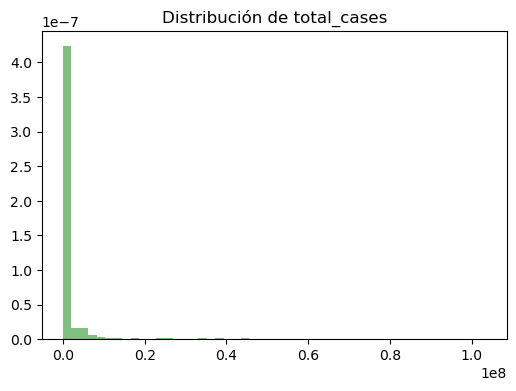

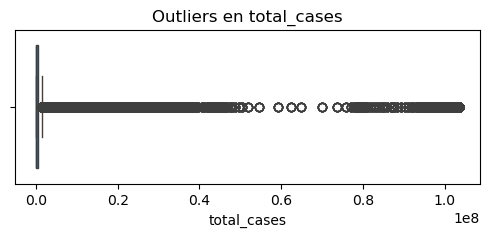

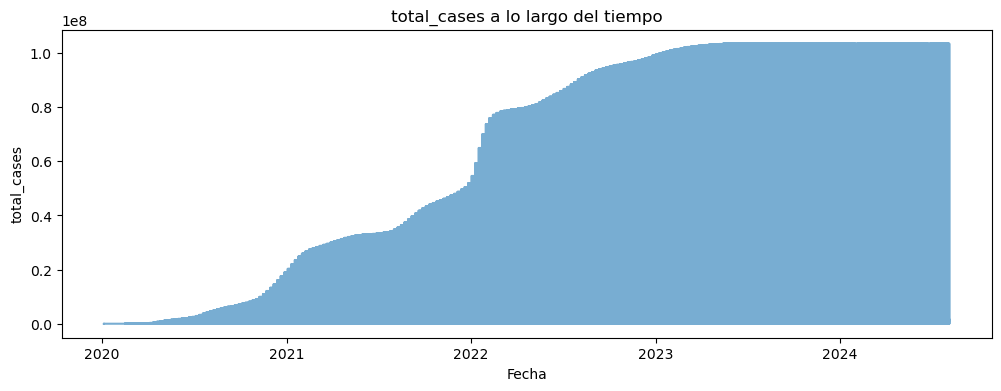

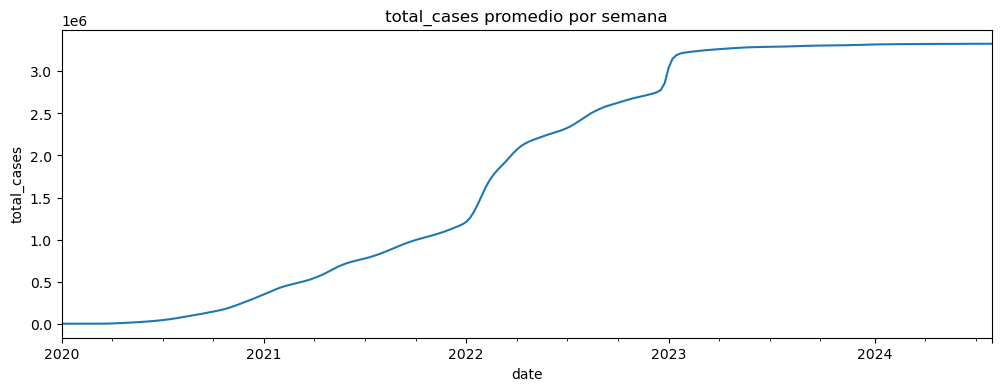

{'skewness': np.float64(8.656269239519286),
 'sesgo': 'muy sesgada',
 'num_outliers': 58952,
 'porcentaje_outliers': 15.11426974530948}

In [107]:
col = 'total_cases'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada y con un 15% de outliers, podríamos sustituir los valores nulos por la mediana. Por otra parte, en las gráficas podemos ver que hay una relación temporal en los valores de total_cases, por lo que la mejor opción será interpolar los valores nulos.

In [108]:
df_temp = interpolate_time_variable(df_clean, col, col_fecha, diagnostico=True)

Valores nulos iniciales: 5269
Valores nulos antes de interpolación: 5269
Valores nulos después de interpolación: 9
Valores nulos tras rellenar extremos: 0
Valores nulos resultantes: 0


In [109]:
df_clean = interpolate_time_variable(df_clean, col, col_fecha)

Valores nulos iniciales: 5269
Valores nulos resultantes: 0


- new_cases

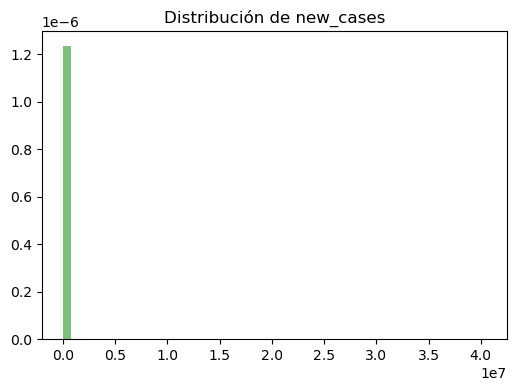

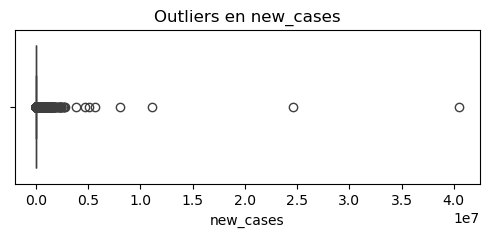

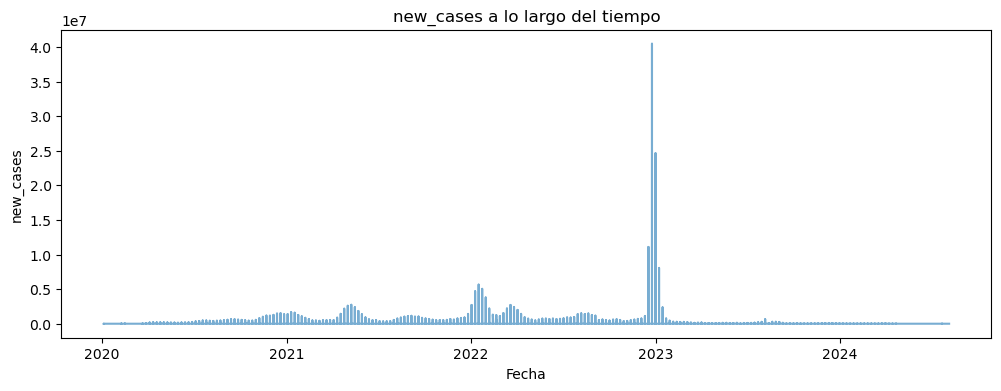

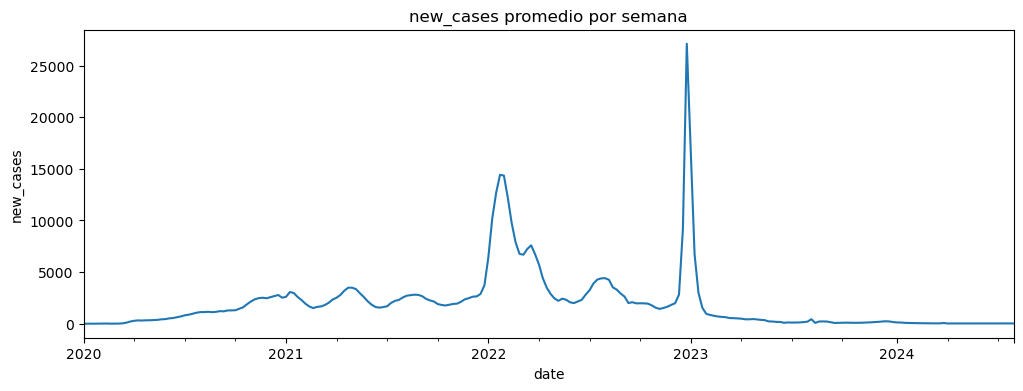

{'skewness': np.float64(339.7484860263648),
 'sesgo': 'muy sesgada',
 'num_outliers': 38743,
 'porcentaje_outliers': 9.975102794305826}

In [110]:
col = 'new_cases'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

En este caso, new_cases tiene una distribución muy sesgada, con un 10% de outliers, pero sin relación temporal, por lo que vamos a sustituir los valores nulos por la mediana.

In [111]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 6914
Valores nulos resultantes: 0


- new_cases_smoothed

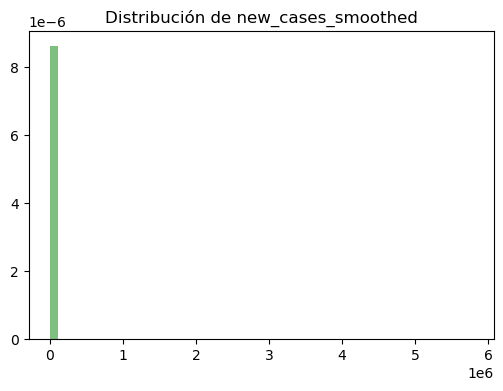

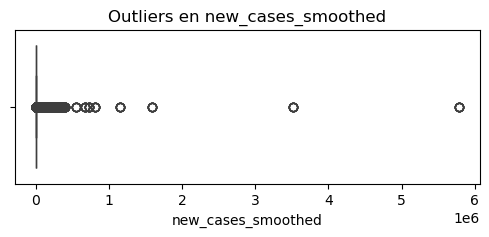

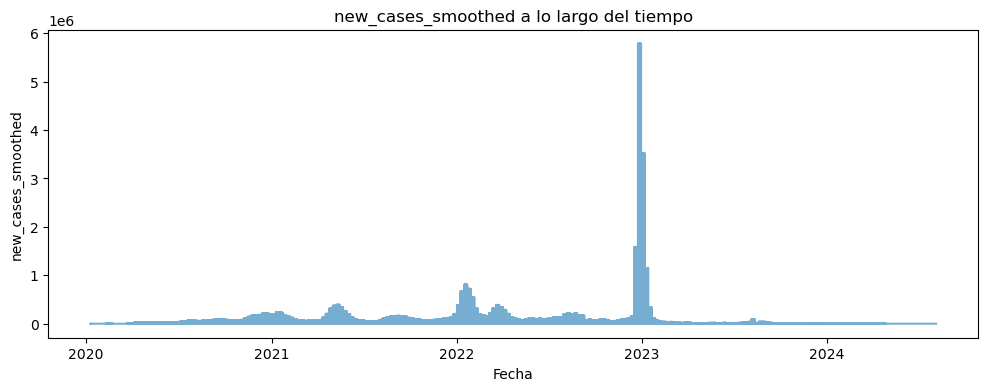

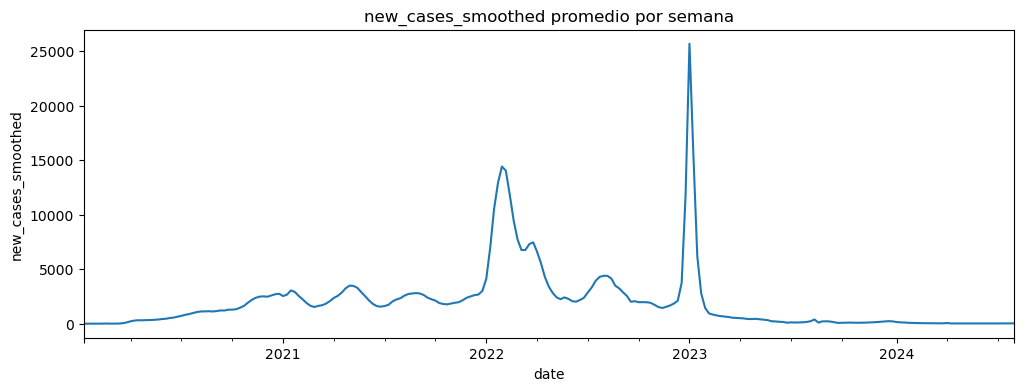

{'skewness': np.float64(128.6878662109375),
 'sesgo': 'muy sesgada',
 'num_outliers': 71229,
 'porcentaje_outliers': 18.394399223204694}

In [112]:
col = 'new_cases_smoothed'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 18% de outliers, sin relación temporal: aplicamos la mediana.

In [113]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 8.710000038146973
Valores nulos iniciales: 8079
Valores nulos resultantes: 0


- total_cases_per_million

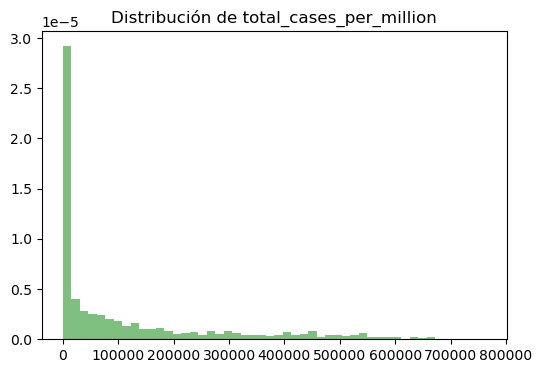

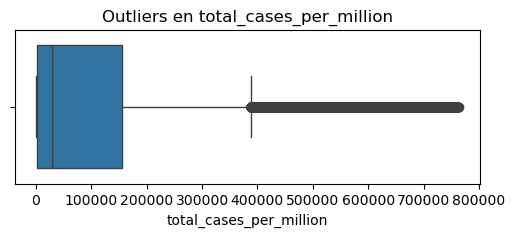

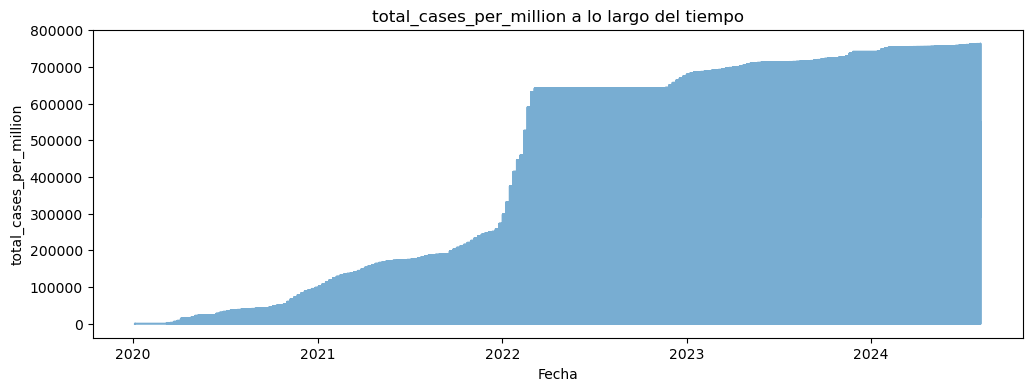

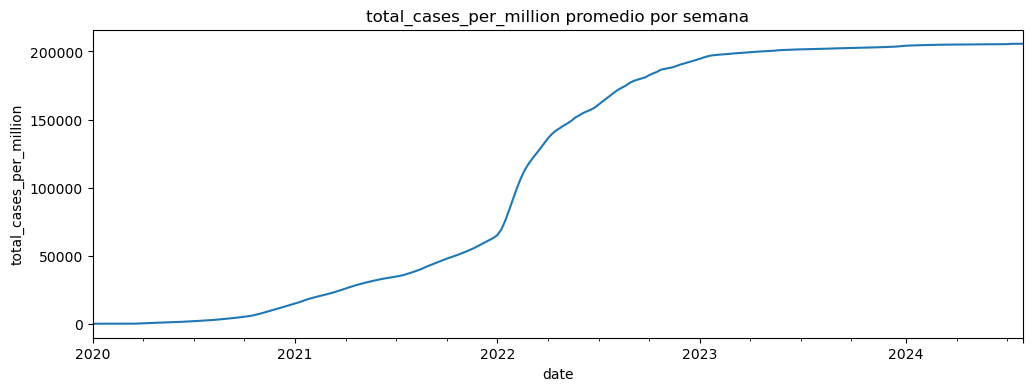

{'skewness': np.float64(1.6498961448669434),
 'sesgo': 'muy sesgada',
 'num_outliers': 40883,
 'porcentaje_outliers': 10.481691715251179}

In [114]:
col = 'total_cases_per_million'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada con un 10% de outliers, pero con relación temporal: aplicamos interpolación.

In [115]:
df_temp = interpolate_time_variable(df_clean, col, col_fecha, diagnostico=True)

Valores nulos iniciales: 5269
Valores nulos antes de interpolación: 5269
Valores nulos después de interpolación: 9
Valores nulos tras rellenar extremos: 0
Valores nulos resultantes: 0


In [116]:
df_clean = interpolate_time_variable(df_clean, col, col_fecha)

Valores nulos iniciales: 5269
Valores nulos resultantes: 0


- new_cases_per_million

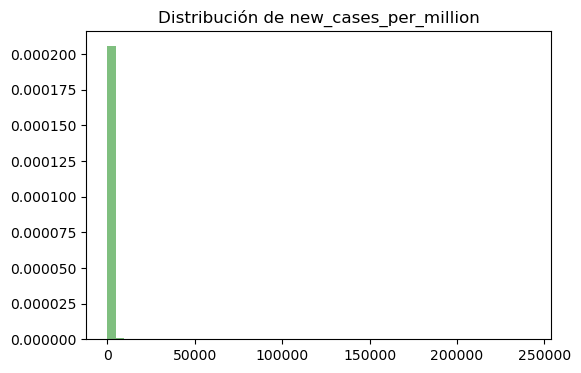

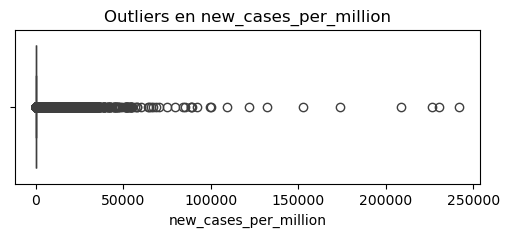

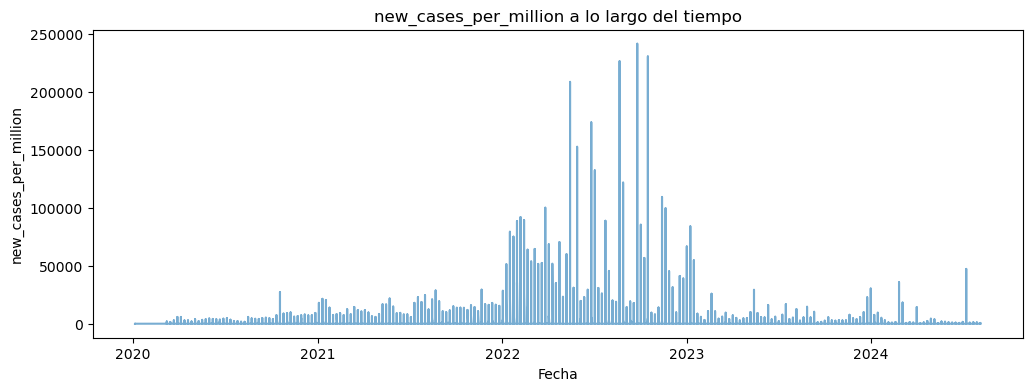

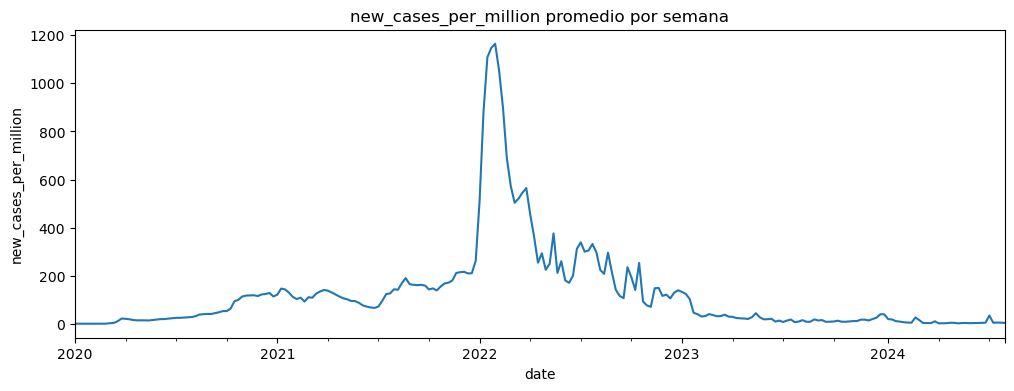

{'skewness': np.float64(58.58122253417969),
 'sesgo': 'muy sesgada',
 'num_outliers': 38736,
 'porcentaje_outliers': 9.973300514679568}

In [117]:
col = 'new_cases_per_million'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 10% de outliers y sin relación temporal: mediana.

In [118]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 6914
Valores nulos resultantes: 0


- new_cases_smoothed_per_million

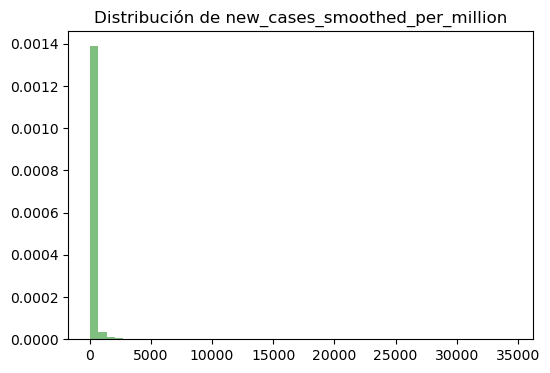

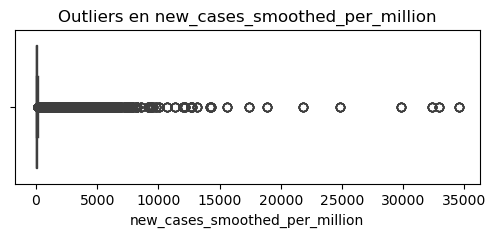

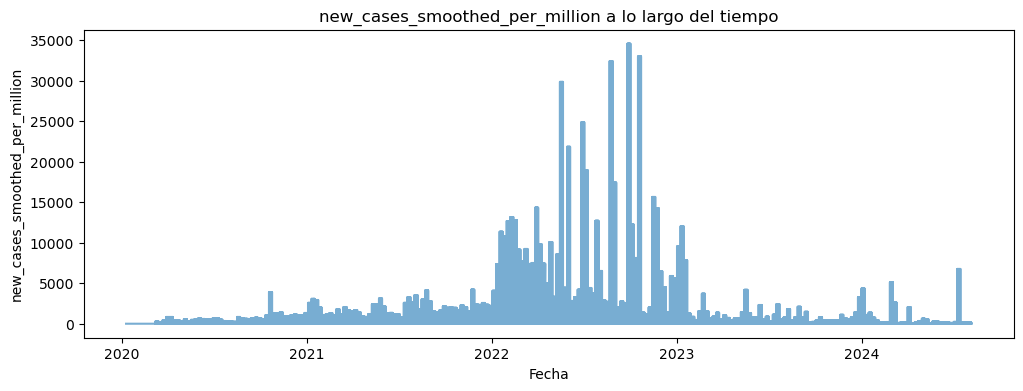

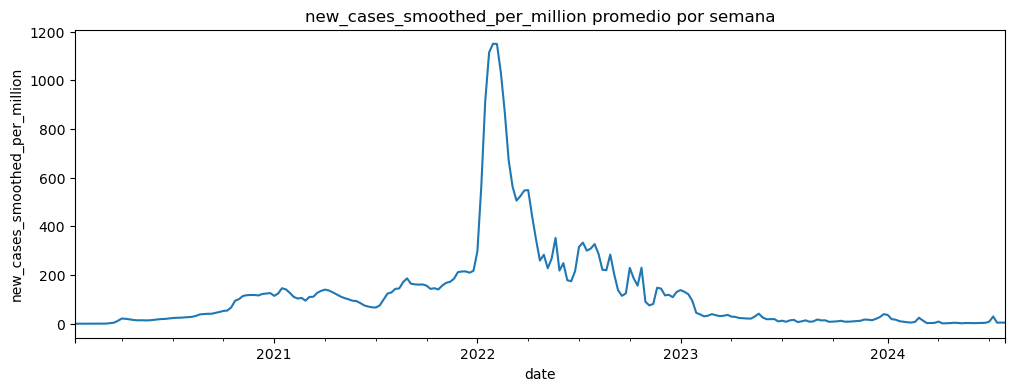

{'skewness': np.float64(22.889474868774414),
 'sesgo': 'muy sesgada',
 'num_outliers': 62860,
 'porcentaje_outliers': 16.233162548549707}

In [119]:
col = 'new_cases_smoothed_per_million'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 16% de outliers y sin relación temporal: mediana.

In [120]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 2.380000114440918
Valores nulos iniciales: 8079
Valores nulos resultantes: 0


- total_deaths

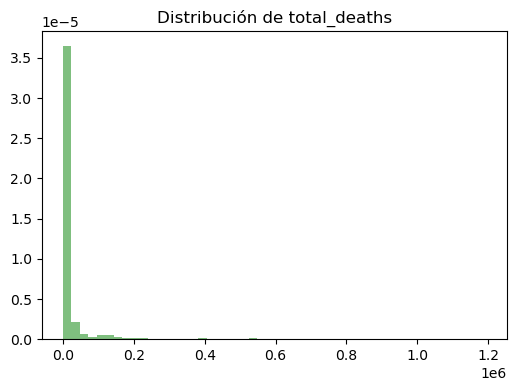

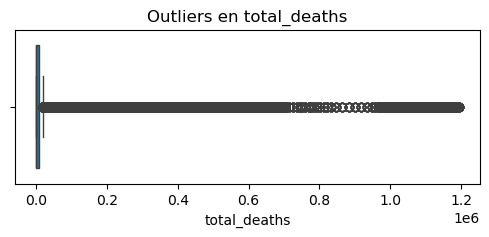

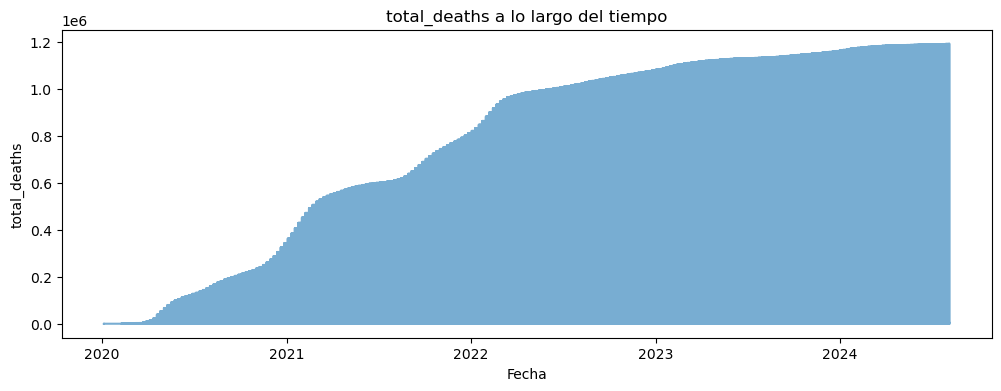

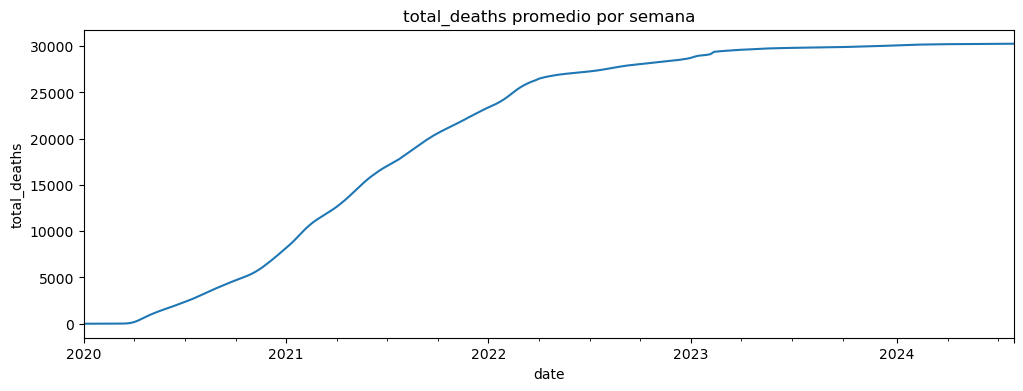

{'skewness': np.float64(8.374271013469567),
 'sesgo': 'muy sesgada',
 'num_outliers': 60847,
 'porcentaje_outliers': 15.600114859425394}

In [121]:
col = 'total_deaths'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada con 16% de outliers, con relación temporal: interpolación.

In [122]:
df_temp = interpolate_time_variable(df_clean, col, col_fecha, diagnostico=True)

Valores nulos iniciales: 5269
Valores nulos antes de interpolación: 5269
Valores nulos después de interpolación: 9
Valores nulos tras rellenar extremos: 0
Valores nulos resultantes: 0


In [123]:
df_clean = interpolate_time_variable(df_clean, col, col_fecha)

Valores nulos iniciales: 5269
Valores nulos resultantes: 0


- new_deaths

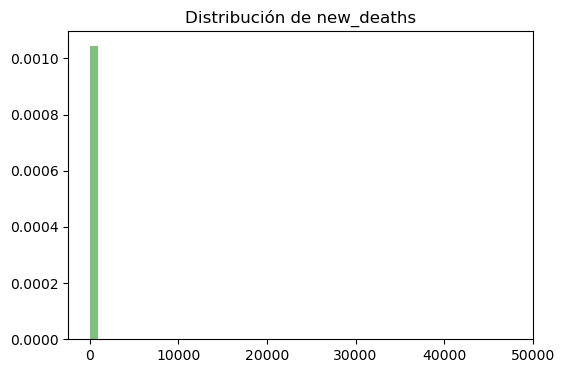

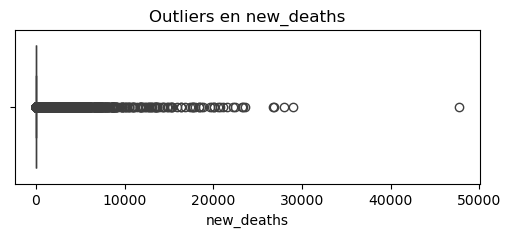

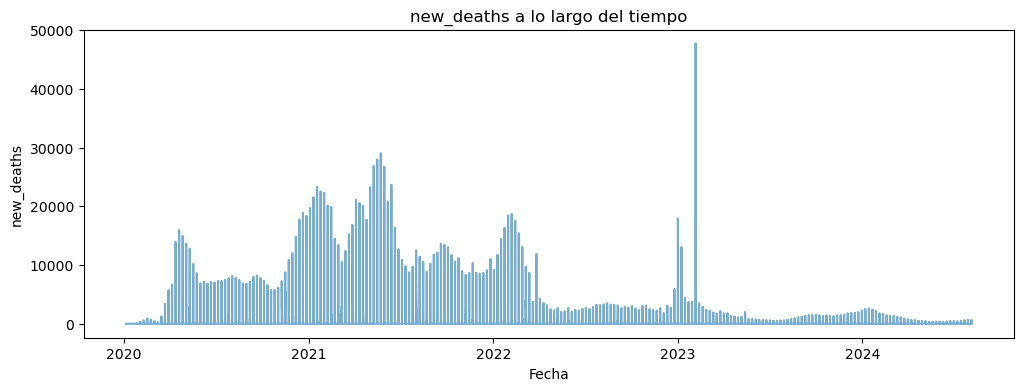

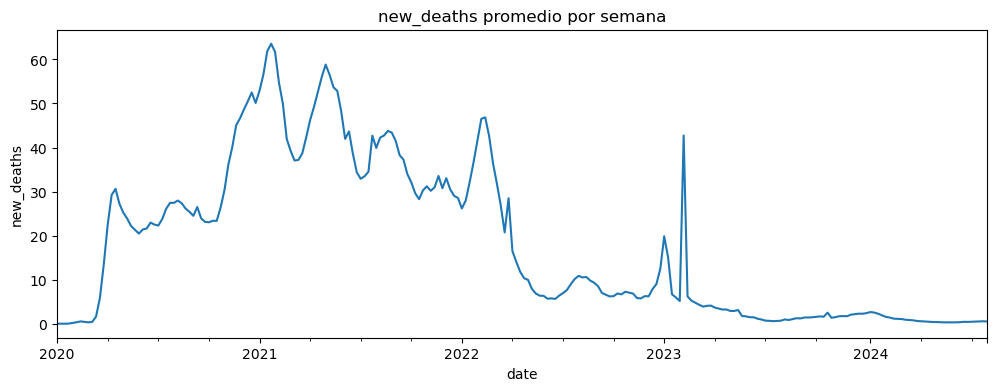

{'skewness': np.float64(46.485417646984416),
 'sesgo': 'muy sesgada',
 'num_outliers': 24808,
 'porcentaje_outliers': 6.379903612226949}

In [124]:
col = 'new_deaths'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 6% de outliers, sin relación temporal: mediana.

In [125]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 6465
Valores nulos resultantes: 0


- new_deaths_smoothed

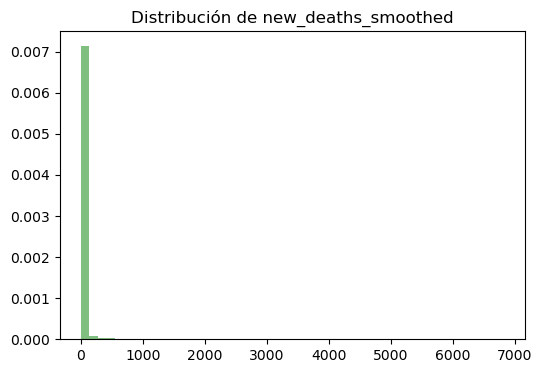

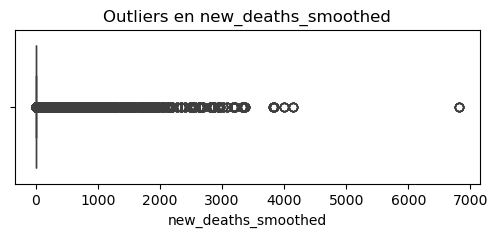

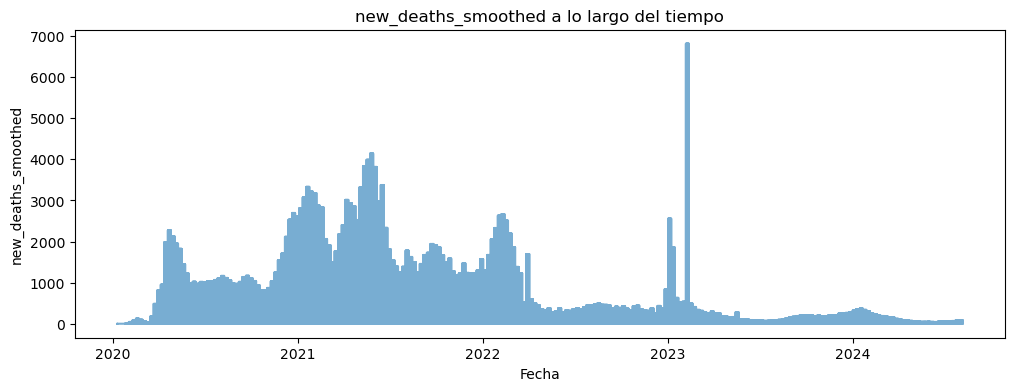

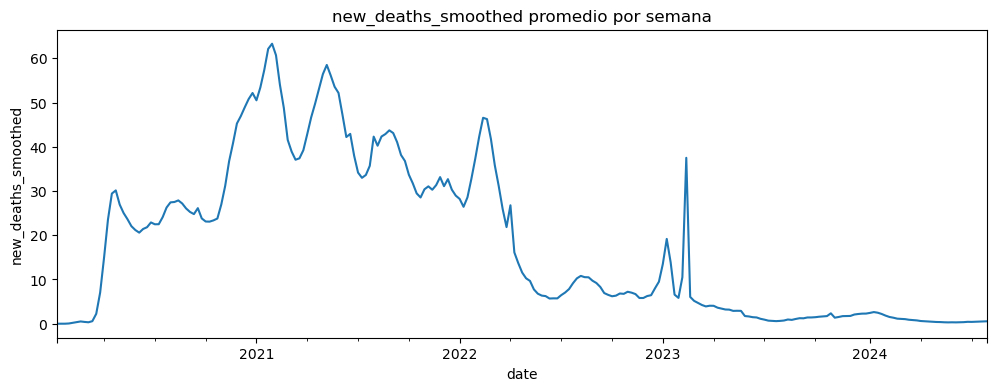

{'skewness': np.float64(17.682903289794922),
 'sesgo': 'muy sesgada',
 'num_outliers': 72040,
 'porcentaje_outliers': 18.582288015146474}

In [126]:
col = 'new_deaths_smoothed'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 19% de outliers, sin relación temporal, aplicamos la mediana.

In [127]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 7630
Valores nulos resultantes: 0


- total_deaths_per_million

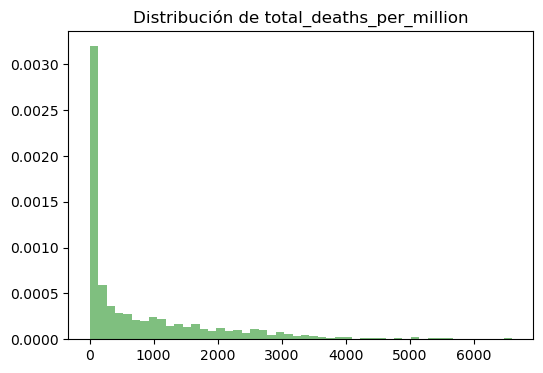

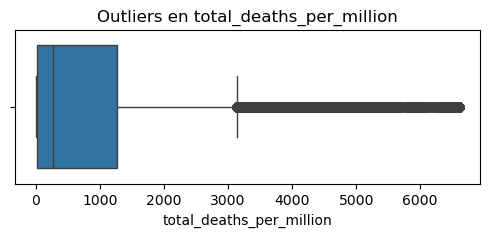

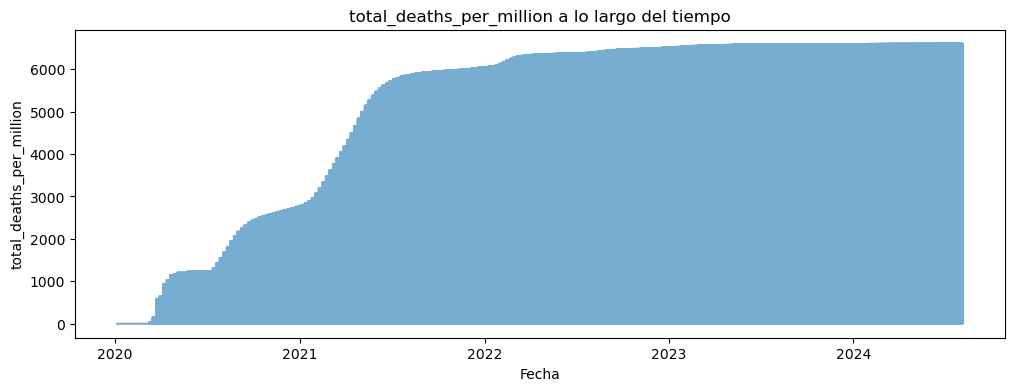

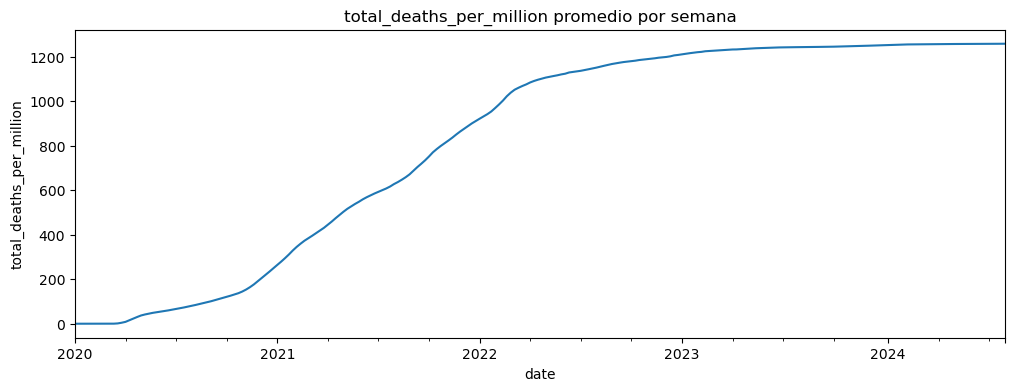

{'skewness': np.float64(1.8445979356765747),
 'sesgo': 'muy sesgada',
 'num_outliers': 20527,
 'porcentaje_outliers': 5.262766573856148}

In [128]:
col = 'total_deaths_per_million'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 5% de outliers, con relación temporal: interpolación.

In [129]:
df_temp = interpolate_time_variable(df_clean, col, col_fecha, diagnostico=True)

Valores nulos iniciales: 5269
Valores nulos antes de interpolación: 5269
Valores nulos después de interpolación: 9
Valores nulos tras rellenar extremos: 0
Valores nulos resultantes: 0


In [130]:
df_clean = interpolate_time_variable(df_clean, col, col_fecha)

Valores nulos iniciales: 5269
Valores nulos resultantes: 0


- new_deaths_per_million

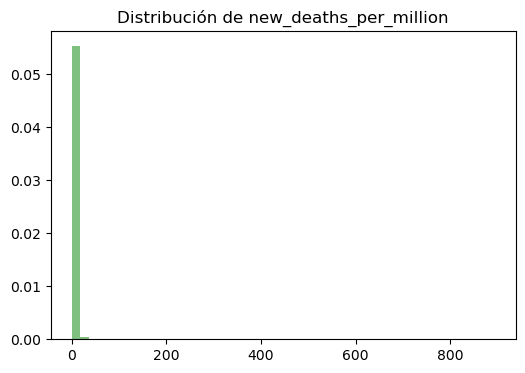

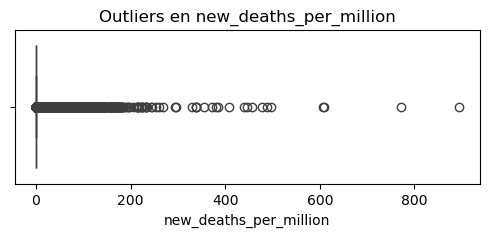

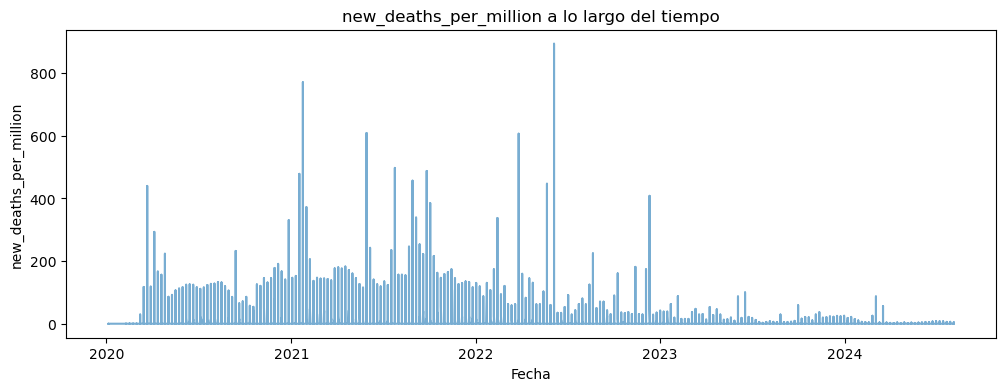

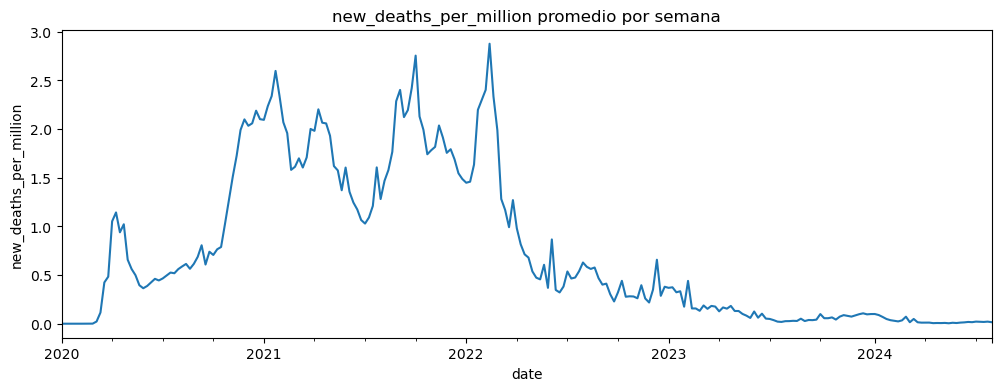

{'skewness': np.float64(29.714120864868164),
 'sesgo': 'muy sesgada',
 'num_outliers': 24682,
 'porcentaje_outliers': 6.347500038575683}

In [131]:
col = 'new_deaths_per_million'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 6% de outliers, sin relación temporal: mediana.

In [132]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 6465
Valores nulos resultantes: 0


- new_deaths_smoothed_per_million

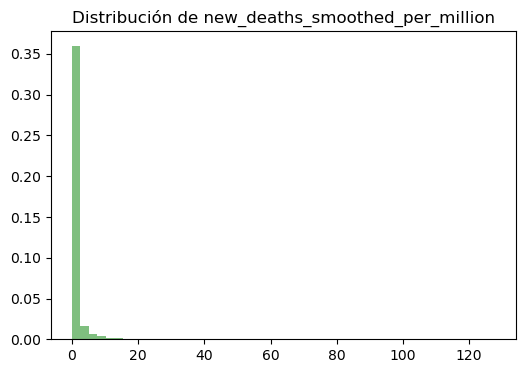

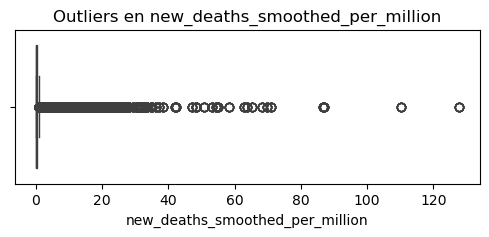

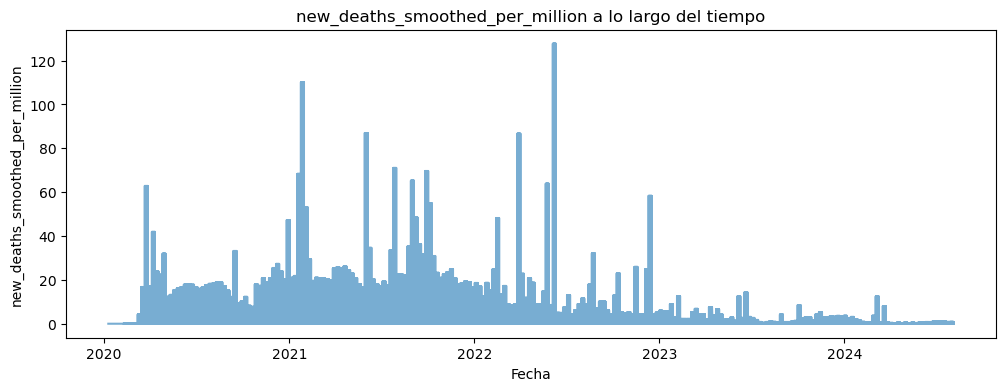

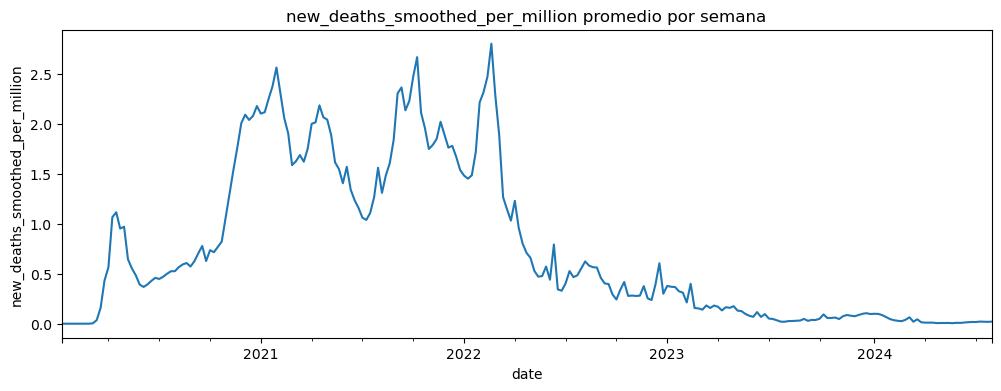

{'skewness': np.float64(11.70246696472168),
 'sesgo': 'muy sesgada',
 'num_outliers': 68439,
 'porcentaje_outliers': 17.653431558420454}

In [133]:
col = 'new_deaths_smoothed_per_million'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 17% de outliers, sin relación temporal: mediana.

In [134]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 7630
Valores nulos resultantes: 0


- population

***
### ya no tiene nulos, quitar de aquí pero pasar a otro sitio
***

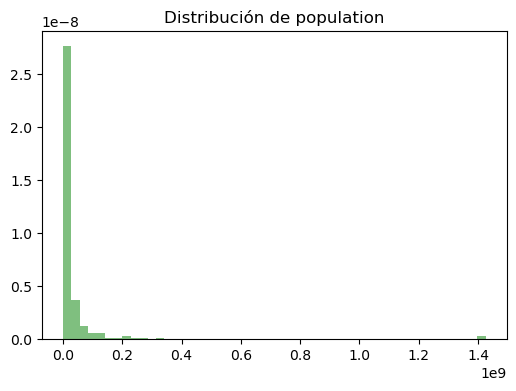

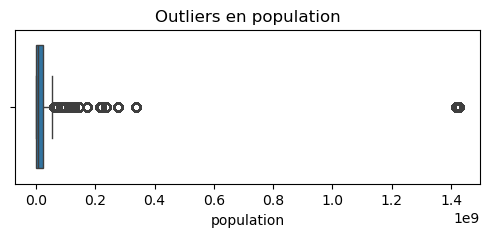

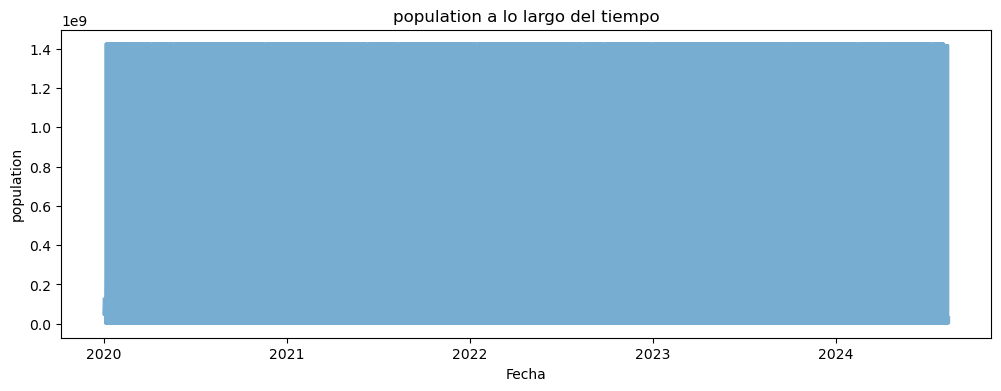

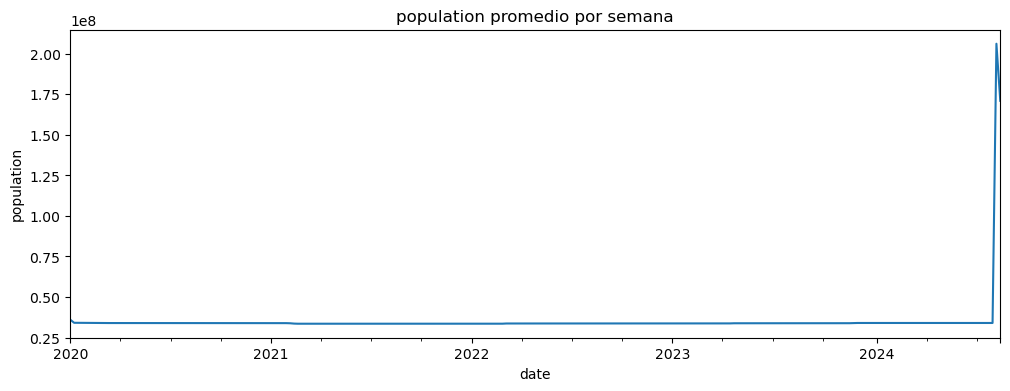

{'skewness': np.float64(9.123696312971466),
 'sesgo': 'muy sesgada',
 'num_outliers': 41866,
 'porcentaje_outliers': 10.590648881513543}

In [135]:
col = 'population'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 13% de outliers, pero en cuanto a la relación temporal vemos que hay una subida abrupta al final. Vamos a estudiar esta variable con más detalle.

In [136]:
df_clean[col].describe()

count            395311.0
mean      33787240.743738
std      136040154.849799
min                  47.0
25%              372903.0
50%             5489744.0
75%            22125242.0
max          1425887360.0
Name: population, dtype: Float64

In [137]:
df_clean[col].value_counts()

population
1341298     2688
53117       2068
2750058     1684
33938216    1684
1326064     1682
            ... 
16320539    1674
7488863     1654
23893396    1348
695180       795
576005         1
Name: count, Length: 237, dtype: Int64

In [138]:
df_clean[col].nunique()

237

255 valores únicos de 430.000 valores totales; de ellos 254 valores se repiten entre 700 y 3.000 veces, pero hay un valor que sólo aparece una vez.

Por ello, interpolar generaría nuevos valores intermedios no existentes entre los 254 valores únicos que más se repiten. No es una buena opción en este caso.

Por otra parte, al haber un número limitado de valores únicos podemos pensar en usar la media en vez de la mediana, pero dado que esta variable (population) es una magnitud numérica continua, vamos a usar la mediana.

In [139]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 5489744.0
Valores nulos iniciales: 0
Valores nulos resultantes: 0


- population_density

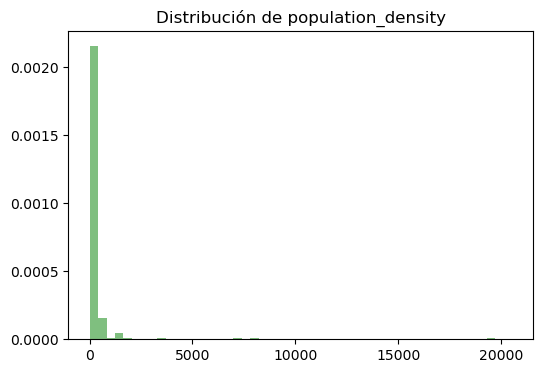

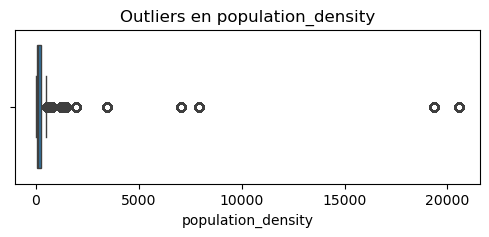

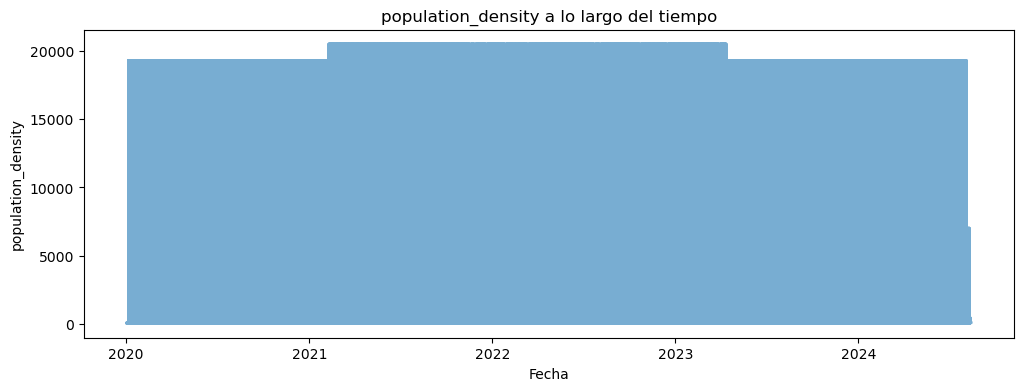

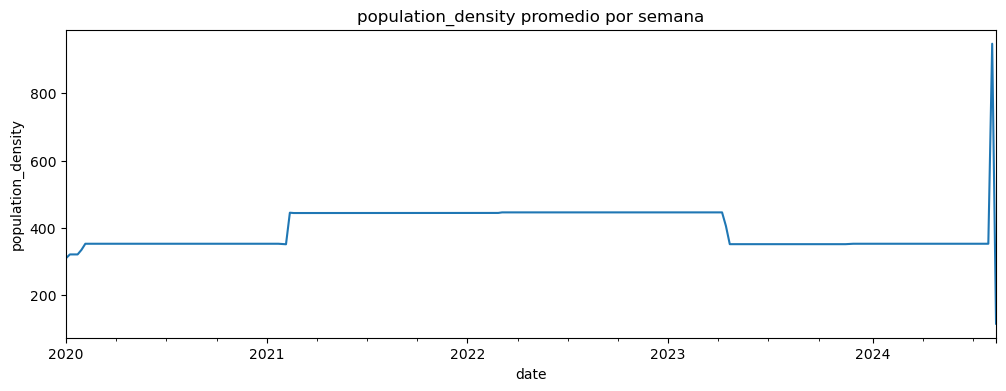

{'skewness': np.float64(9.29075813293457),
 'sesgo': 'muy sesgada',
 'num_outliers': 32581,
 'porcentaje_outliers': 9.122906248074953}

In [140]:
col = 'population_density'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, 9% de outliers, y aunque se observa relación temporal también vemos varias subidas y bajadas abruptas, lo que invalida el uso de interpolación: vamos a utilizar la mediana.

In [141]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 88.12000274658203
Valores nulos iniciales: 38177
Valores nulos resultantes: 0


- median_age

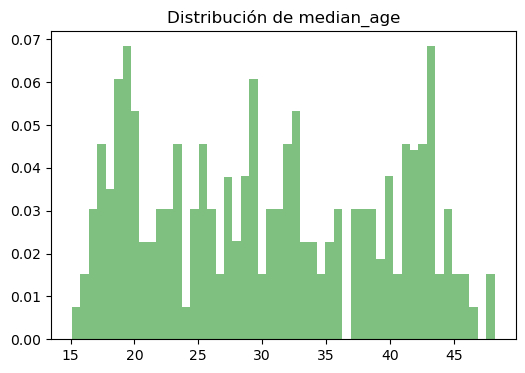

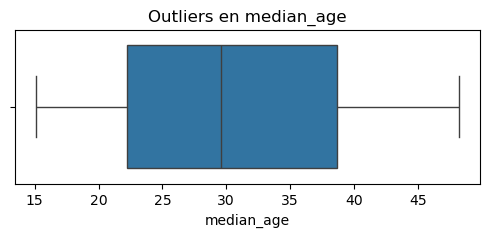

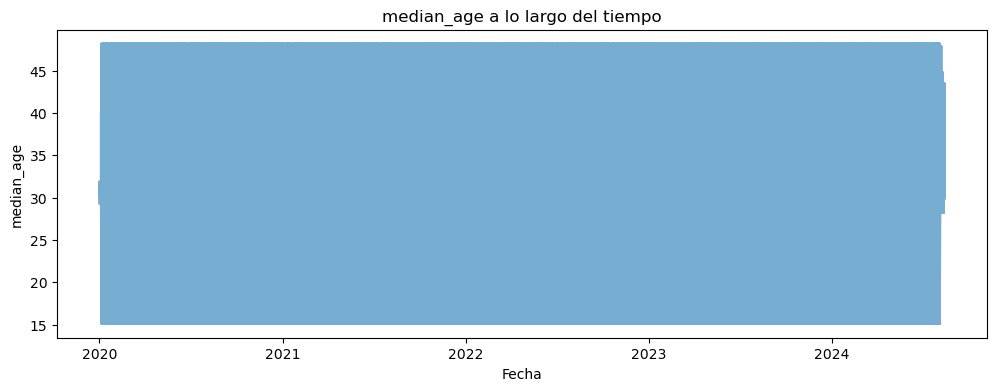

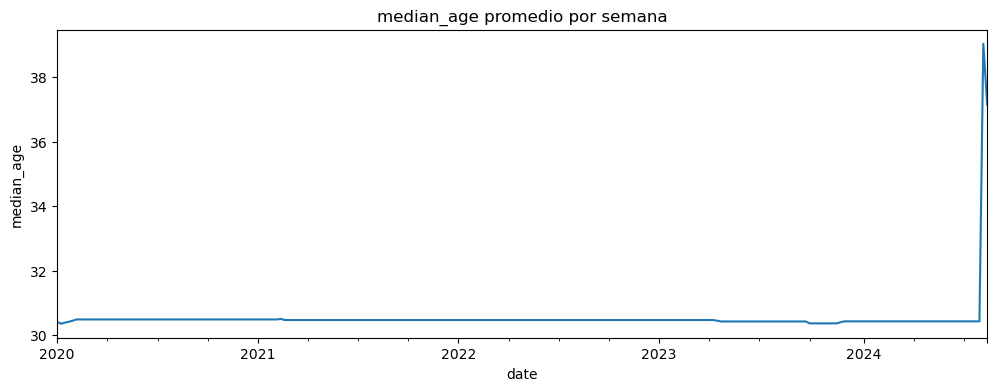

{'skewness': np.float64(0.1224842295050621),
 'sesgo': 'simétrica',
 'num_outliers': 0,
 'porcentaje_outliers': 0.0}

In [142]:
col = 'median_age'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución simétrica y sin outliers, y no hay relación temporal: aplicamos la media.

In [143]:
media = df_clean[col].mean()
print(f"Media: {media}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(media)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Media: 30.453872680664062
Valores nulos iniciales: 62332
Valores nulos resultantes: 0


- aged_65_older

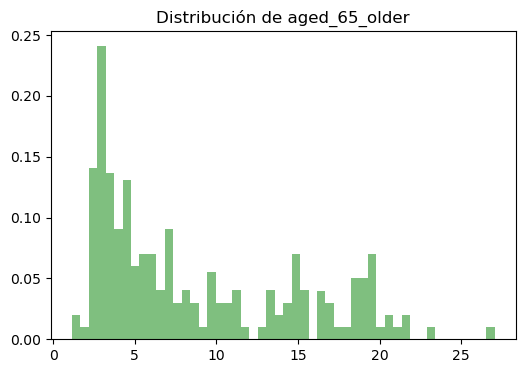

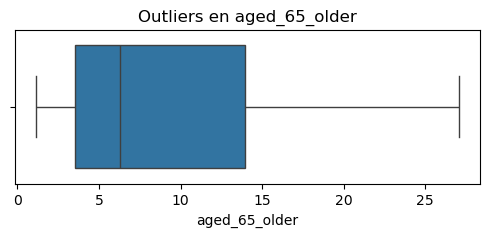

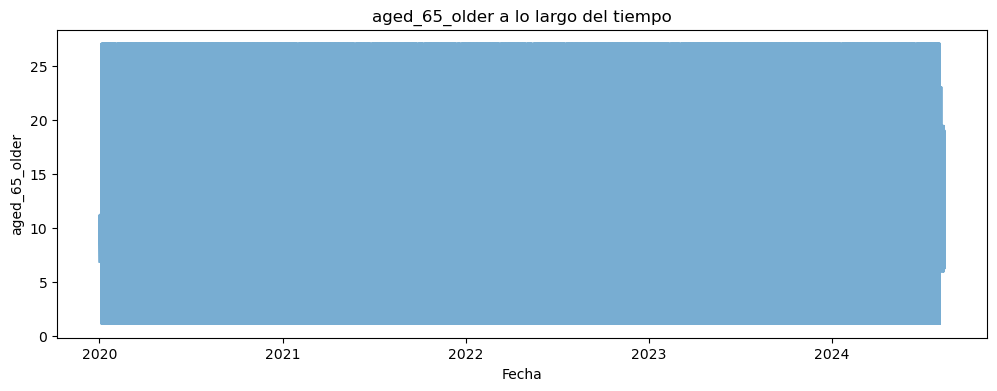

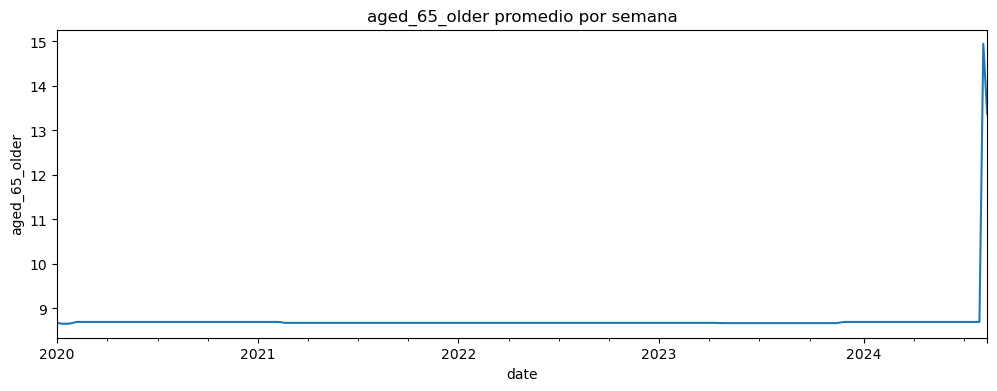

{'skewness': np.float64(0.8039664626121521),
 'sesgo': 'moderadamente sesgada',
 'num_outliers': 0,
 'porcentaje_outliers': 0.0}

In [144]:
col = 'aged_65_older'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución sesgada, sin outliers ni relación temporal: aplicamos la mediana.

In [145]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 6.289999961853027
Valores nulos iniciales: 73725
Valores nulos resultantes: 0


- aged_70_older

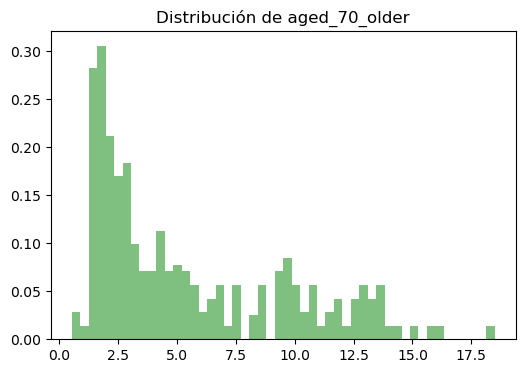

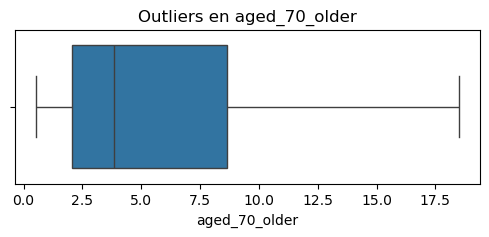

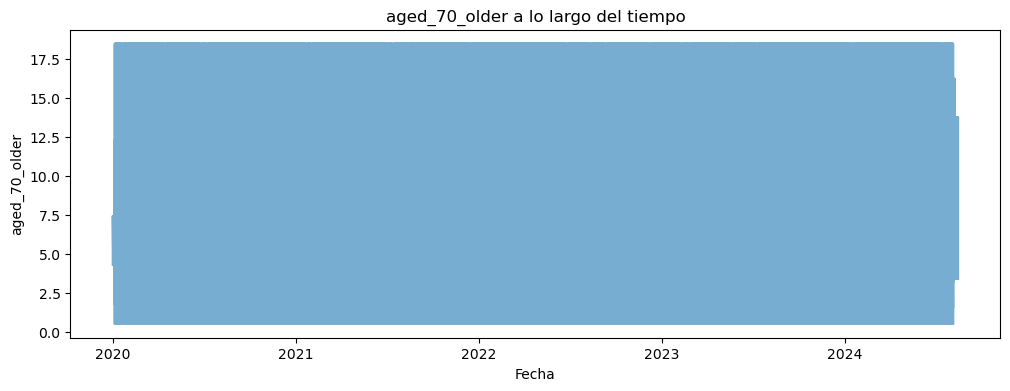

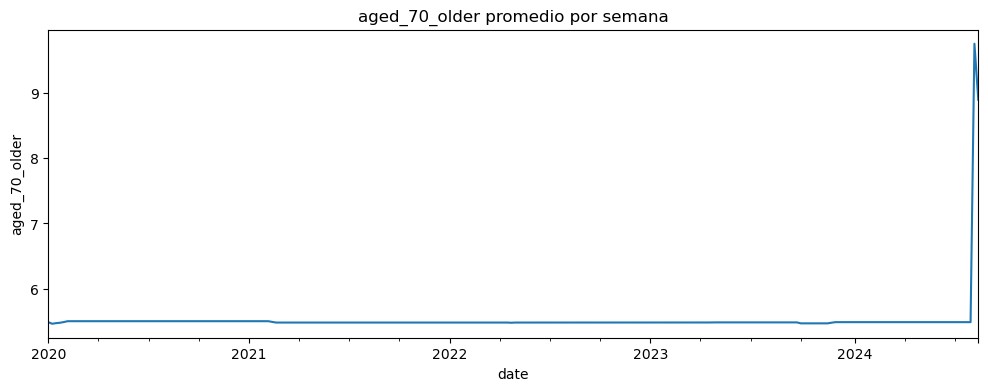

{'skewness': np.float64(0.9353696703910828),
 'sesgo': 'moderadamente sesgada',
 'num_outliers': 0,
 'porcentaje_outliers': 0.0}

In [146]:
col = 'aged_70_older'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución sesgada sin outliers y sin relación temporal: mediana.

In [147]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 3.859999895095825
Valores nulos iniciales: 65680
Valores nulos resultantes: 0


- life_expectancy

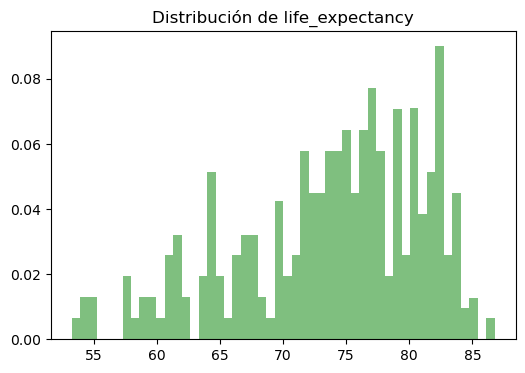

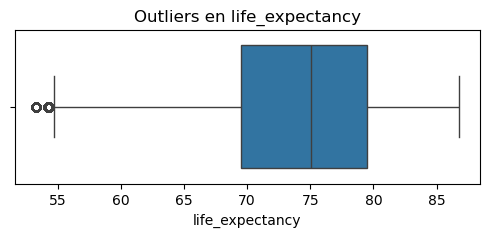

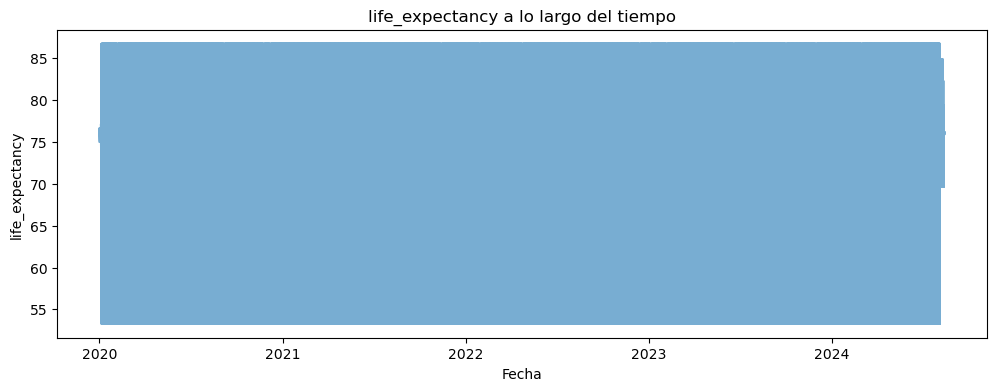

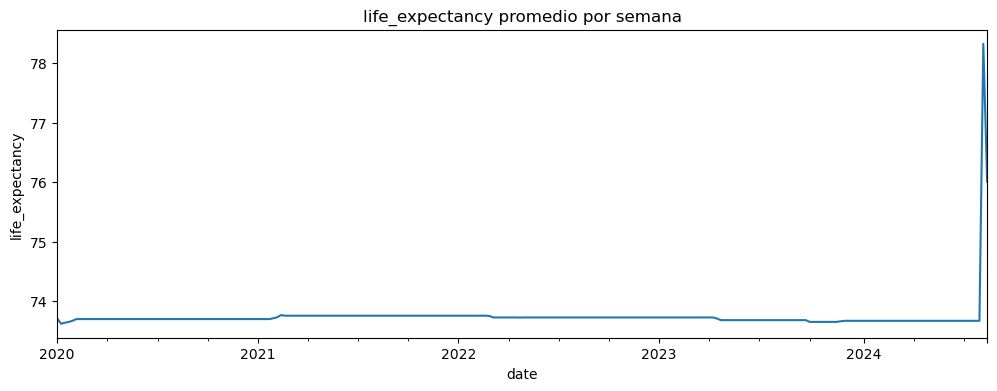

{'skewness': np.float64(-0.6914061903953552),
 'sesgo': 'moderadamente sesgada',
 'num_outliers': 5022,
 'porcentaje_outliers': 1.2922815640157996}

In [148]:
col = 'life_expectancy'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución sesgada con algunos outliers: mediana.

In [149]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 75.05000305175781
Valores nulos iniciales: 6696
Valores nulos resultantes: 0


- diabetes_prevalence

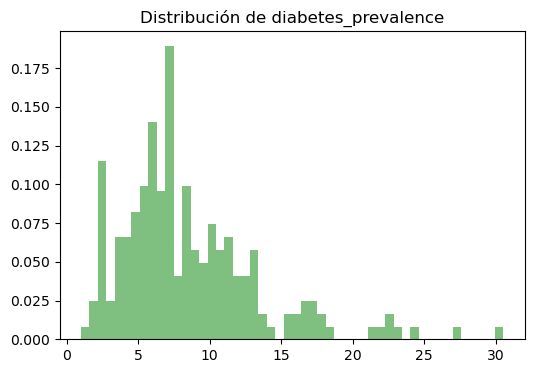

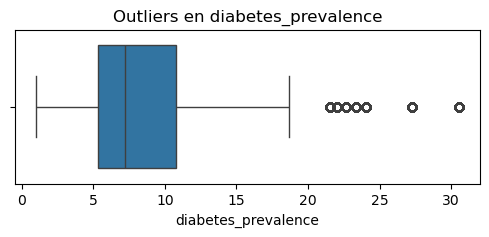

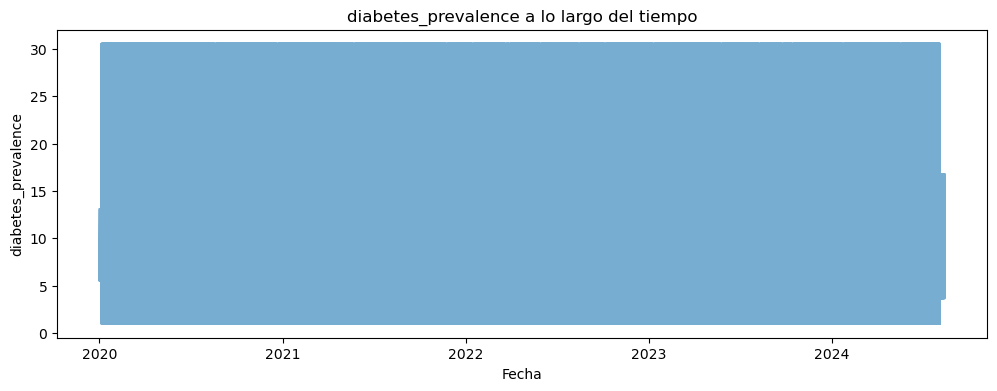

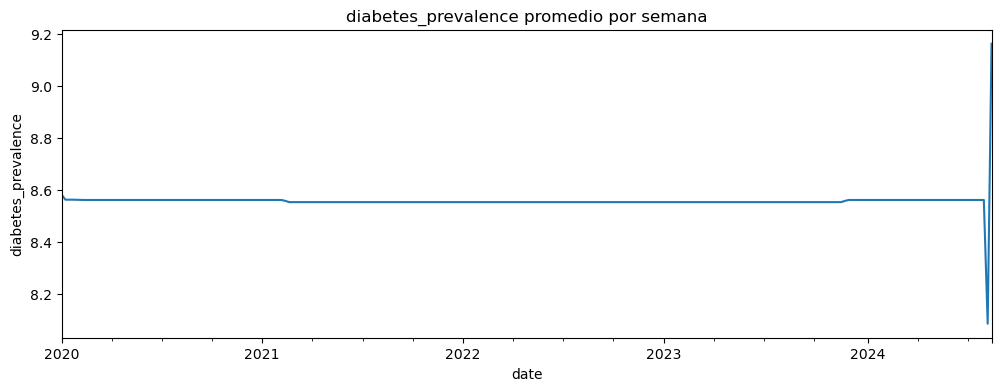

{'skewness': np.float64(1.44757080078125),
 'sesgo': 'muy sesgada',
 'num_outliers': 13392,
 'porcentaje_outliers': 3.8904560072277885}

In [150]:
col = 'diabetes_prevalence'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución sesgada y con outliers, sin relación temporal: mediana.

In [151]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 7.199999809265137
Valores nulos iniciales: 51084
Valores nulos resultantes: 0


In [152]:
df_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population'],
      dtype='object')

### Nuevas variables

A partir de las variables que quedan en el dataset, vamos a crear nuevas variables que aporten nueva información interesante.

<b>1. Tasa diaria de crecimiento de casos</b>

growth_rate_cases = new_cases / (total_cases - new_cases)

In [153]:
col = 'growth_rate_cases'

In [154]:
df_clean[col] = np.where(
    (df_clean['total_cases'] - df_clean['new_cases']) != 0,
    df_clean['new_cases'] / (df_clean['total_cases'] - df_clean['new_cases']),
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'new_cases', 'total_cases', col
]].head()

new_cases  total_cases  growth_rate_cases
1702         44         45.0          44.000000
3488         80        125.0           1.777778
4994          1          2.0           1.000000
5041          1          3.0           0.500000
5059          2          3.0           2.000000

In [155]:
show_column(df_clean, col)

growth_rate_cases
count      365966.000000
mean            0.015934
std             0.751741
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           315.000000

--------------------------------------------------


growth_rate_cases
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
...                   ...
395306                0.0
395307                0.0
395308                0.0
395309                0.0
395310                0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
growth_rate_cases
0.000000e+00         327454
1.000000e+00             45
2.000000e+00             26
5.000000e-01             22
1.428571e-01             20
                      ...  
9.800000e+01              1
1.156667e+02              1
1.247778e+02              1
1.568333e+02              1
5.880722e-08              1
Name: count, Length: 37339, dtype: int64
--------------------------------------------------
Valores únicos: growth_rate_cases    37339
dtype: int64
--------------------------------------------------
Valores a cero: growth_rate_cases
True     327454
False     67857
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 29345


89% de valores a cero y 8% de valores nulos.

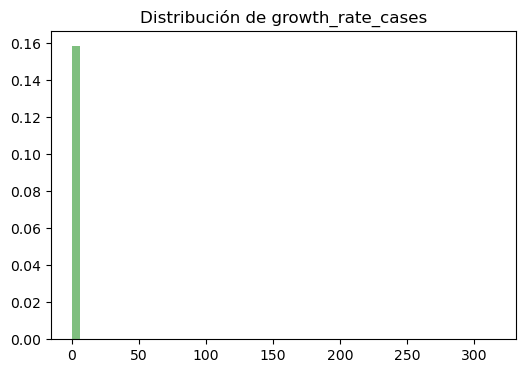

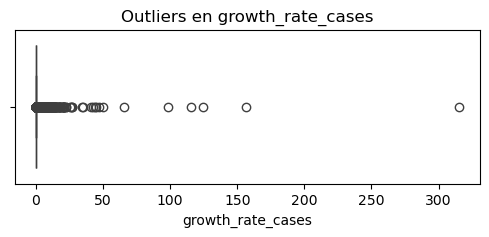

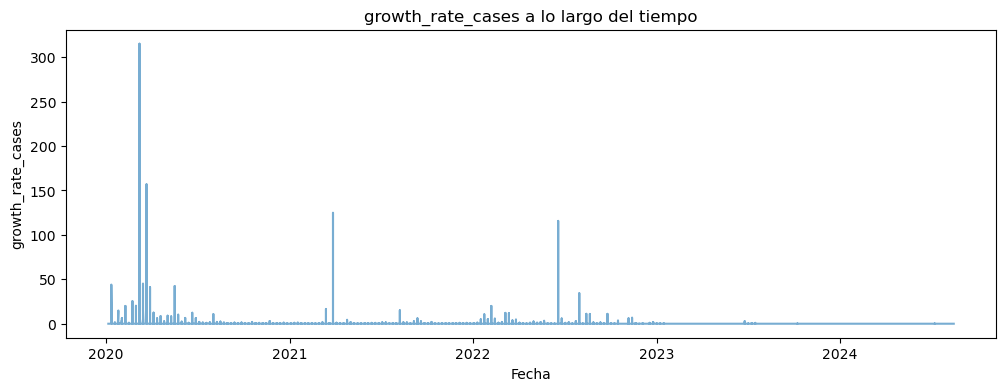

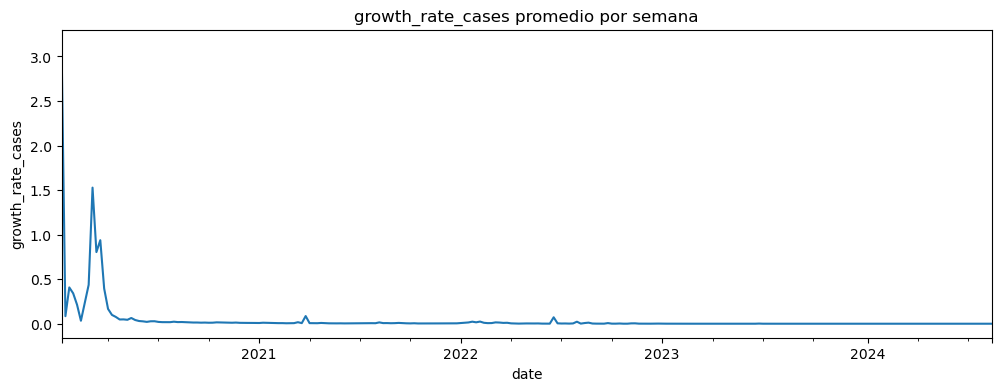

{'skewness': np.float64(262.46659701021963),
 'sesgo': 'muy sesgada',
 'num_outliers': 38512,
 'porcentaje_outliers': 10.523381953514807}

In [156]:
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, con outliers y sin relación temporal: aplicamos mediana para eliminar los valores nulos.

In [157]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 29345
Valores nulos resultantes: 0


<b>2. Tasa de crecimiento de muertes</b>

growth_rate_deaths = new_deaths / (total_deaths - new_deaths)

In [158]:
col = 'growth_rate_deaths'

In [159]:
df_clean[col] = np.where(
    (df_clean['total_deaths'] - df_clean['new_deaths']) != 0,
    df_clean['new_deaths'] / (df_clean['total_deaths'] - df_clean['new_deaths']),
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'new_deaths', 'total_deaths', col
]].head()

new_deaths  total_deaths  growth_rate_deaths
3488           2           3.0            2.000000
4994           3           6.0            1.000000
5107          53          56.0           17.666667
6554         305         361.0            5.446429
6760           3           9.0            0.500000

In [160]:
show_column(df_clean, col)

growth_rate_deaths
count       342966.000000
mean             0.006869
std              0.153865
min              0.000000
25%              0.000000
50%              0.000000
75%              0.000000
max             24.000000

--------------------------------------------------


growth_rate_deaths
0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
...                    ...
395306                 0.0
395307                 0.0
395308                 0.0
395309                 0.0
395310                 0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
growth_rate_deaths
0.000000              318384
1.000000                  88
0.333333                  86
0.500000                  73
0.250000                  58
                       ...  
0.000008                   1
0.000008                   1
0.000008                   1
0.000008                   1
0.000008                   1
Name: count, Length: 19746, dtype: int64
--------------------------------------------------
Valores únicos: growth_rate_deaths    19746
dtype: int64
--------------------------------------------------
Valores a cero: growth_rate_deaths
True     318384
False     76927
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 52345


93% de valores a cero y 15% de valores nulos.

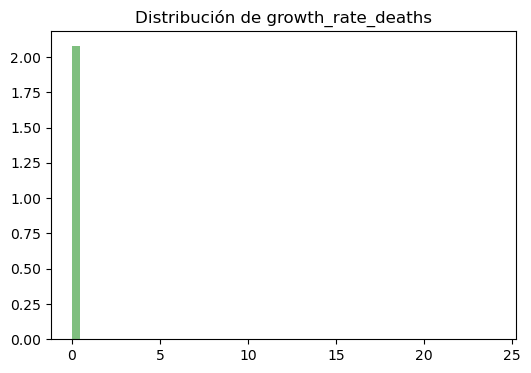

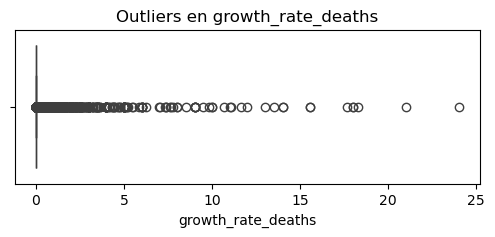

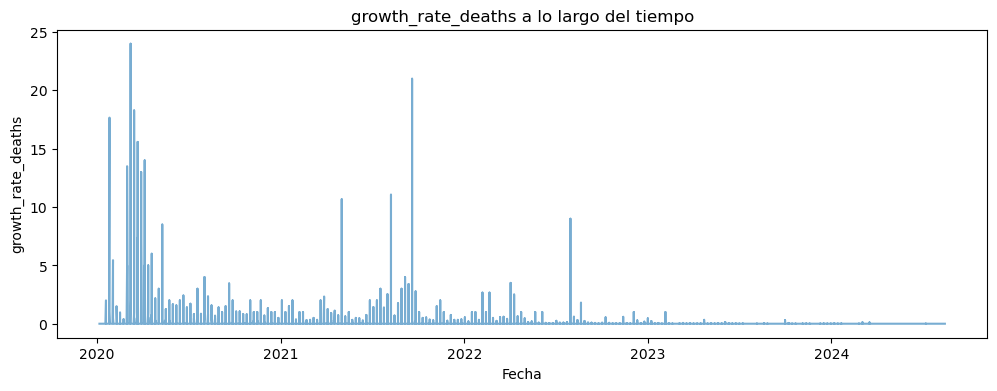

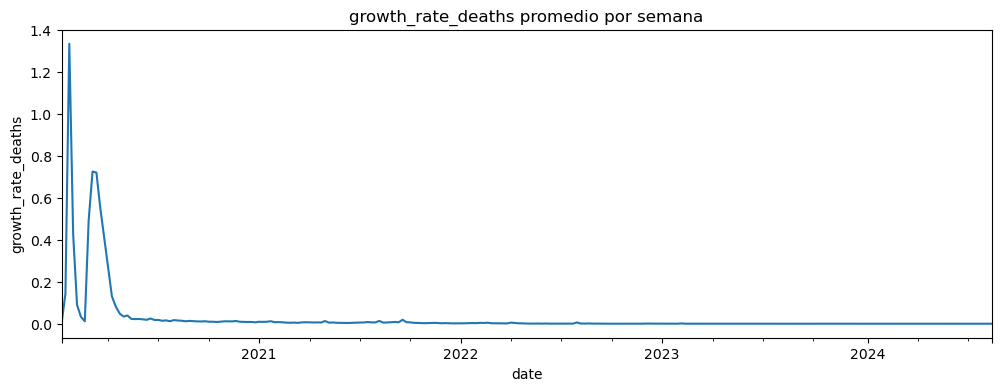

{'skewness': np.float64(73.28625989129935),
 'sesgo': 'muy sesgada',
 'num_outliers': 24582,
 'porcentaje_outliers': 7.167474326901209}

In [161]:
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, outliers y sin relación temporal (hay muchos picos): mediana

In [162]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.0
Valores nulos iniciales: 52345
Valores nulos resultantes: 0


<b>3. Letalidad, ratio de muertes sobre casos</b>

case_fatality_rate = total_deaths / total_cases

In [163]:
col = 'case_fatality_rate'

In [164]:
df_clean[col] = np.where(
    df_clean['total_cases'] != 0,
    df_clean['total_deaths'] / df_clean['total_cases'],
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'total_deaths', 'total_cases', col
]].head()

total_deaths  total_cases  case_fatality_rate
140            3.0          1.0                 3.0
348            3.0          1.0                 3.0
638            3.0          1.0                 3.0
842            3.0          1.0                 3.0
1053           3.0          1.0                 3.0

In [165]:
show_column(df_clean, col)

case_fatality_rate
count       366197.000000
mean             0.151640
std             14.650342
min              0.000000
25%              0.004881
50%              0.011463
75%              0.021140
max           4843.000000

--------------------------------------------------


case_fatality_rate
0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
...                    ...
395306            0.008199
395307            0.008199
395308            0.008199
395309            0.008199
395310            0.008199

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
case_fatality_rate
0.000000              23028
0.007028                897
0.000808                883
0.001754                862
0.012046                785
                      ...  
3.830262                  1
3.837884                  1
3.840773                  1
3.873785                  1
0.000003                  1
Name: count, Length: 41233, dtype: int64
--------------------------------------------------
Valores únicos: case_fatality_rate    41233
dtype: int64
--------------------------------------------------
Valores a cero: case_fatality_rate
False    372283
True      23028
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 29114


6% de valores a cero y 8% de valores nulos.

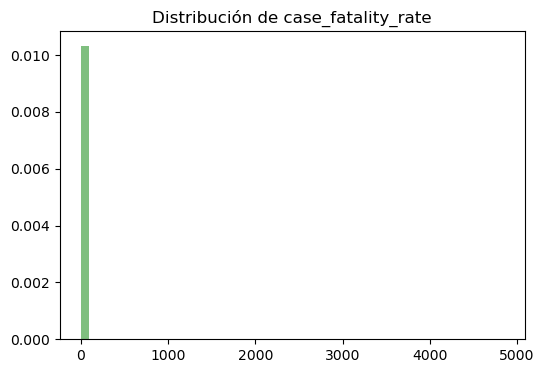

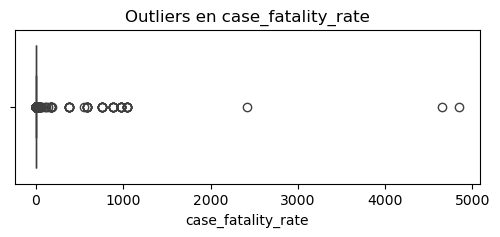

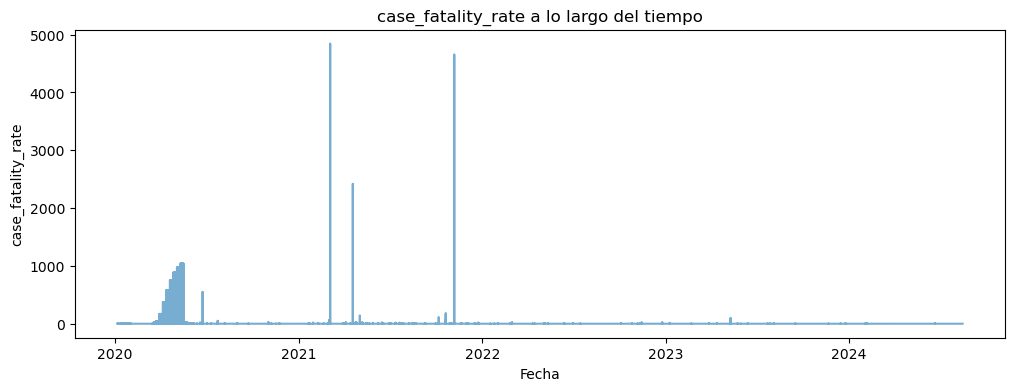

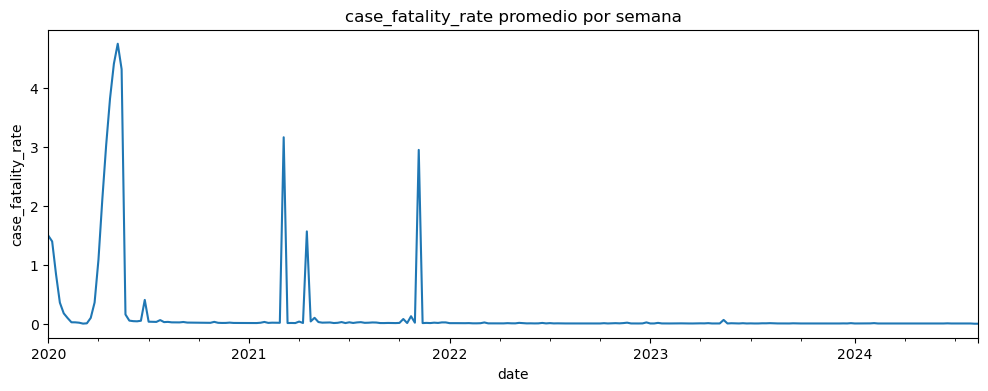

{'skewness': np.float64(219.40745267416463),
 'sesgo': 'muy sesgada',
 'num_outliers': 23617,
 'porcentaje_outliers': 6.449260916938151}

In [166]:
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

Distribución muy sesgada, outliers y sin relación temporal: mediana.

In [167]:
mediana = df_clean[col].median()
print(f"Mediana: {mediana}")
print(f"Valores nulos iniciales: {df_clean[col].isnull().sum()}")
df_clean[col] = df_clean[col].fillna(mediana)
print(f"Valores nulos resultantes: {df_clean[col].isnull().sum()}")

Mediana: 0.011463286229201551
Valores nulos iniciales: 29114
Valores nulos resultantes: 0


<b>4. Ratio de nuevos casos sobre población</b>

daily_cases_ratio = new_cases / population

In [168]:
col = 'daily_millions_cases_ratio'

In [169]:
df_clean[col] = np.where(
    df_clean['population'] != 0,
    (df_clean['new_cases'] * 1_000_000) / df_clean['population'],
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'new_cases', 'population', col
]].head()

new_cases  population  daily_millions_cases_ratio
140           1    83369840                    0.011995
190           1  1425887360                    0.000701
1702         44  1425887360                    0.030858
1770          1       36491                   27.404017
3367          1    51815808                    0.019299

In [170]:
show_column(df_clean, col)

daily_millions_cases_ratio
count               395311.000000
mean                    62.094037
std                   1128.320217
min                      0.000000
25%                      0.000000
50%                      0.000000
75%                      0.000000
max                 240325.865580

--------------------------------------------------


daily_millions_cases_ratio
0                              0.0
1                              0.0
2                              0.0
3                              0.0
4                              0.0
...                            ...
395306                         0.0
395307                         0.0
395308                         0.0
395309                         0.0
395310                         0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
daily_millions_cases_ratio
0.000000                      356568
25.409732                         26
19.238354                         24
40.343729                         21
20.972714                         21
                               ...  
0.934960                           1
0.024314                           1
0.936176                           1
0.025949                           1
43877.294443                       1
Name: count, Length: 32116, dtype: int64
--------------------------------------------------
Valores únicos: daily_millions_cases_ratio    32116
dtype: int64
--------------------------------------------------
Valores a cero: daily_millions_cases_ratio
True     356568
False     38743
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


90% de valores a cero y sin valores nulos.

<b>5. Ratio de nuevos fallecidos en función de la población</b>

daily_deaths_ratio = new_deaths / population

In [171]:
col = 'daily_thousands_deaths_ratio'

In [172]:
df_clean[col] = np.where(
    df_clean['population'] != 0,
    (df_clean['new_deaths'] * 1_000) / df_clean['population'],
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'new_deaths', 'population', col
]].head()

new_deaths  population  daily_thousands_deaths_ratio
140            3    83369840                  3.598424e-05
1702           1  1425887360                  7.013177e-07
3488           2  1425887360                  1.402635e-06
4994           3    83369840                  3.598424e-05
5107          53  1425887360                  3.716984e-05

In [173]:
show_column(df_clean, col)

daily_thousands_deaths_ratio
count                 395311.000000
mean                       0.000740
std                        0.007047
min                        0.000000
25%                        0.000000
50%                        0.000000
75%                        0.000000
max                        0.906413

--------------------------------------------------


daily_thousands_deaths_ratio
0                                0.0
1                                0.0
2                                0.0
3                                0.0
4                                0.0
...                              ...
395306                           0.0
395307                           0.0
395308                           0.0
395309                           0.0
395310                           0.0

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
daily_thousands_deaths_ratio
0.000000                        370503
0.000144                            93
0.001875                            47
0.000770                            39
0.010052                            36
                                 ...  
0.214218                             1
0.216383                             1
0.219232                             1
0.220015                             1
0.224883                             1
Name: count, Length: 12990, dtype: int64
--------------------------------------------------
Valores únicos: daily_thousands_deaths_ratio    12990
dtype: int64
--------------------------------------------------
Valores a cero: daily_thousands_deaths_ratio
True     370503
False     24808
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


94% de valores a cero y sin valores nulos.

<b>6. Casos por Km2</b>

cases_per_km2 = total_cases / (population / population_density)

In [174]:
col = 'millions_cases_per_km2'

In [175]:
df_clean[col] = np.where(
    (df_clean['population'] != 0) & (df_clean['population_density'] != 0),
    df_clean['total_cases'] * 1_000_000 / (
        df_clean['population'] / df_clean['population_density']
    ),
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'total_cases', 'population', 'population_density', col
]].head()

total_cases  population  population_density  millions_cases_per_km2
140          1.0    83369840          237.020004                2.842995
190          1.0  1425887360          147.669998                0.103564
348          1.0    83369840          237.020004                2.842995
368          1.0  1425887360          147.669998                0.103564
638          1.0    83369840          237.020004                2.842995

In [176]:
show_column(df_clean, col)

millions_cases_per_km2
count            3.953110e+05
mean             1.813046e+08
std              7.535946e+09
min              0.000000e+00
25%              1.001387e+05
50%              1.734336e+06
75%              1.648825e+07
max              1.549503e+12

--------------------------------------------------


millions_cases_per_km2
0                     0.000000
1                     0.000000
2                     0.000000
3                     0.000000
4                     0.000000
...                        ...
395306            61224.343672
395307            61224.343672
395308           354349.728923
395309           354349.728923
395310            61224.343672

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
millions_cases_per_km2
0.000000e+00              29114
2.835545e+06               1387
1.148707e+05                897
2.303922e+07                883
2.966581e+04                862
                          ...  
9.970567e+10                  1
1.006081e+11                  1
1.034933e+11                  1
1.035677e+11                  1
3.401855e+11                  1
Name: count, Length: 43825, dtype: int64
--------------------------------------------------
Valores únicos: millions_cases_per_km2    43825
dtype: int64
--------------------------------------------------
Valores a cero: millions_cases_per_km2
False    366197
True      29114
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


7% de valores a cero y sin valores nulos.

<b>7. Muertes por Km2</b>

deaths_per_km2 = total_deaths / (population / population_density)

In [177]:
col = 'million_deaths_per_km2'

In [178]:
df_clean[col] = np.where(
    (df_clean['population'] != 0) & (df_clean['population_density'] != 0),
    df_clean['total_deaths'] * 1_000_000 / (
        df_clean['population'] / df_clean['population_density']
    ),
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'total_deaths', 'population', 'population_density', col
]].head()

total_deaths  population  population_density  million_deaths_per_km2
140            3.0    83369840          237.020004                8.528984
348            3.0    83369840          237.020004                8.528984
638            3.0    83369840          237.020004                8.528984
842            3.0    83369840          237.020004                8.528984
1053           3.0    83369840          237.020004                8.528984

In [179]:
show_column(df_clean, col)

million_deaths_per_km2
count            3.953110e+05
mean             1.674305e+06
std              7.770455e+07
min              0.000000e+00
25%              1.050150e+03
50%              1.996828e+04
75%              1.378864e+05
max              1.571517e+10

--------------------------------------------------


million_deaths_per_km2
0                      0.00000
1                      0.00000
2                      0.00000
3                      0.00000
4                      0.00000
...                        ...
395306               501.97836
395307               501.97836
395308              2905.31323
395309              2905.31323
395310               501.97836

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
million_deaths_per_km2
0.000000e+00              52119
8.073114e+02               1086
6.960711e+03                967
5.052985e+04                925
1.520790e+03                925
                          ...  
2.079548e+09                  1
2.109060e+09                  1
2.130843e+09                  1
4.222908e+09                  1
2.175960e+09                  1
Name: count, Length: 29498, dtype: int64
--------------------------------------------------
Valores únicos: million_deaths_per_km2    29498
dtype: int64
--------------------------------------------------
Valores a cero: million_deaths_per_km2
False    343192
True      52119
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


13% de valores a cero y sin valores nulos.

<b>8. Casos en mayores de 65 años</b>

cases_per_65_older = total_cases / (population x aged_65_older / 100)

In [180]:
col = 'cases_per_65_older'

In [181]:
df_clean[col] = np.where(
    (df_clean['population'] != 0) & (df_clean['aged_65_older'] != 0),
    df_clean['total_cases'] / (
        df_clean['population'] * df_clean['aged_65_older'] / 100
    ),
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'total_cases', 'population', 'aged_65_older', col
]].head()

total_cases  population  aged_65_older  cases_per_65_older
140          1.0    83369840      21.450001        5.591956e-08
190          1.0  1425887360          10.64        6.591331e-09
348          1.0    83369840      21.450001        5.591956e-08
368          1.0  1425887360          10.64        6.591331e-09
638          1.0    83369840      21.450001        5.591956e-08

In [182]:
show_column(df_clean, col)

cases_per_65_older
count       395311.000000
mean             1.801940
std             23.648490
min              0.000000
25%              0.040363
50%              0.414030
75%              1.805099
max           6313.587169

--------------------------------------------------


cases_per_65_older
0                 0.000000
1                 0.000000
2                 0.000000
3                 0.000000
4                 0.000000
...                    ...
395306            0.010113
395307            0.010113
395308            0.041316
395309            0.041316
395310            0.010113

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
cases_per_65_older
0.000000              29114
0.511577               1387
0.051500                897
10.373357               883
3.368817                862
                      ...  
344.569612                1
344.688373                1
350.474012                1
352.578642                1
623.755349                1
Name: count, Length: 43825, dtype: int64
--------------------------------------------------
Valores únicos: cases_per_65_older    43825
dtype: int64
--------------------------------------------------
Valores a cero: cases_per_65_older
False    366197
True      29114
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


7% de valores a cero y sin valores nulos

<b>9. Muertes en mayores de 65 años</b>

deaths_per_65_older = total_deaths / (population x aged_65_older / 100)

In [183]:
col = 'deaths_per_65_older'

In [184]:
df_clean[col] = np.where(
    (df_clean['population'] != 0) & (df_clean['aged_65_older'] != 0),
    df_clean['total_deaths'] / (
        df_clean['population'] * df_clean['aged_65_older'] / 100
    ),
    np.nan
)

df_clean[(
    df_clean[col].notna()
) & (
    df_clean[col] != 0
)][[
    'total_deaths', 'population', 'aged_65_older', col
]].head()

total_deaths  population  aged_65_older  deaths_per_65_older
140            3.0    83369840      21.450001         1.677587e-07
348            3.0    83369840      21.450001         1.677587e-07
638            3.0    83369840      21.450001         1.677587e-07
842            3.0    83369840      21.450001         1.677587e-07
1053           3.0    83369840      21.450001         1.677587e-07

In [185]:
show_column(df_clean, col)

deaths_per_65_older
count        395311.000000
mean              0.015003
std               0.333479
min               0.000000
25%               0.000470
50%               0.004417
75%               0.014657
max              90.293220

--------------------------------------------------


deaths_per_65_older
0                  0.000000
1                  0.000000
2                  0.000000
3                  0.000000
4                  0.000000
...                     ...
395306             0.000083
395307             0.000083
395308             0.000339
395309             0.000339
395310             0.000083

[395311 rows x 1 columns]

--------------- Frecuencia de valores ---------------
deaths_per_65_older
0.000000               52119
0.000362                1086
0.004005                 967
0.009116                 925
0.000572                 925
                       ...  
6.626491                   1
6.836892                   1
6.892713                   1
14.328689                  1
7.352293                   1
Name: count, Length: 29498, dtype: int64
--------------------------------------------------
Valores únicos: deaths_per_65_older    29498
dtype: int64
--------------------------------------------------
Valores a cero: deaths_per_65_older
False    343192
True      52119
Name: count, dtype: int64
--------------------------------------------------
Valores nulos: 0


13% de valores a cero y sin valores nulos

### Visualizar otras variables

Vamos a graficar las variables no visualizadas en el apartado anterior.

In [186]:
df_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population', 'growth_rate_cases',
       'growth_rate_deaths', 'case_fatality_rate',
       'daily_millions_cases_ratio', 'daily_thousands_deaths_ratio',
       'millions_cases_per_km2', 'million_deaths_per_km2',
       'cases_per_65_older', 'deaths_per_65_older'],
      dtype='object')

- date

Fechas entre el 1 de Enero de 2020 y el 14 de Agosto de 2024, con una distribución bastante uniforme en años y meses.

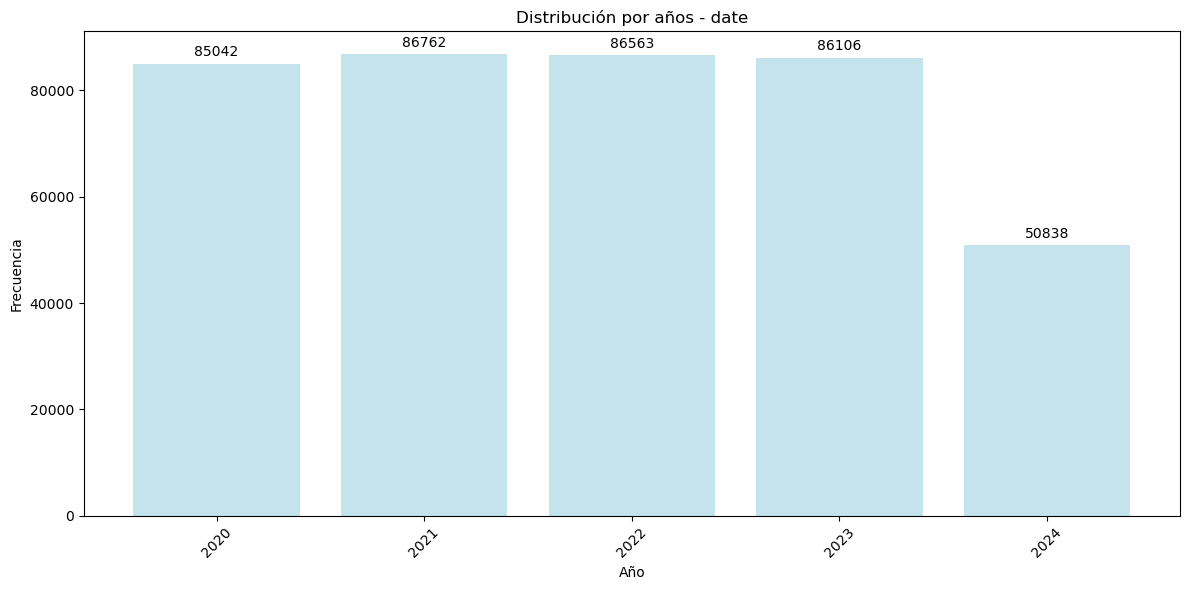

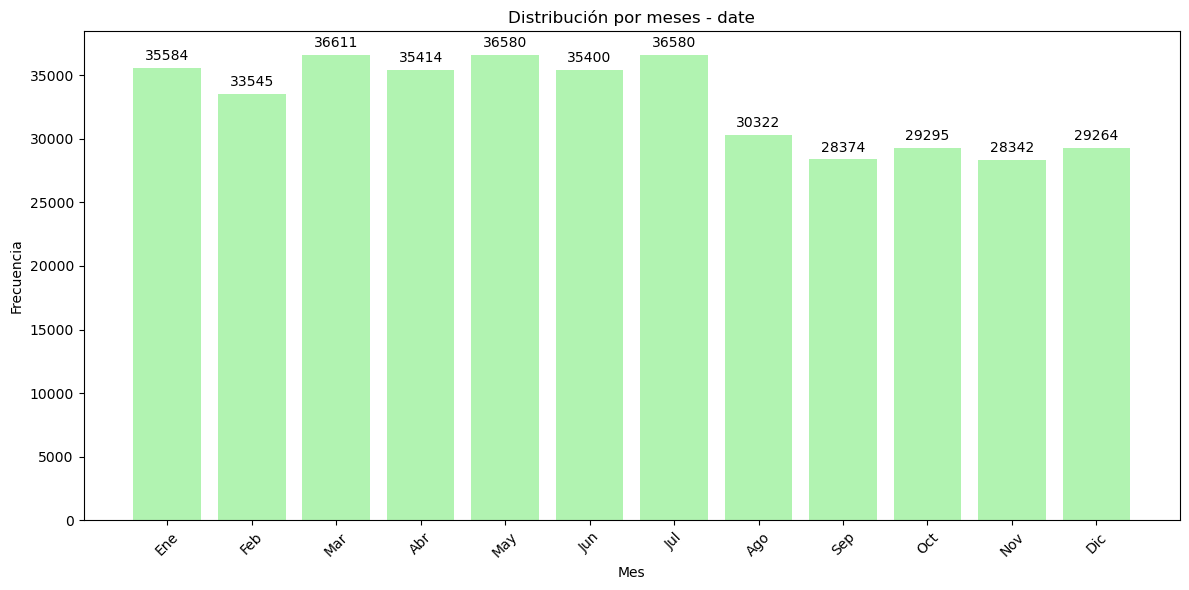

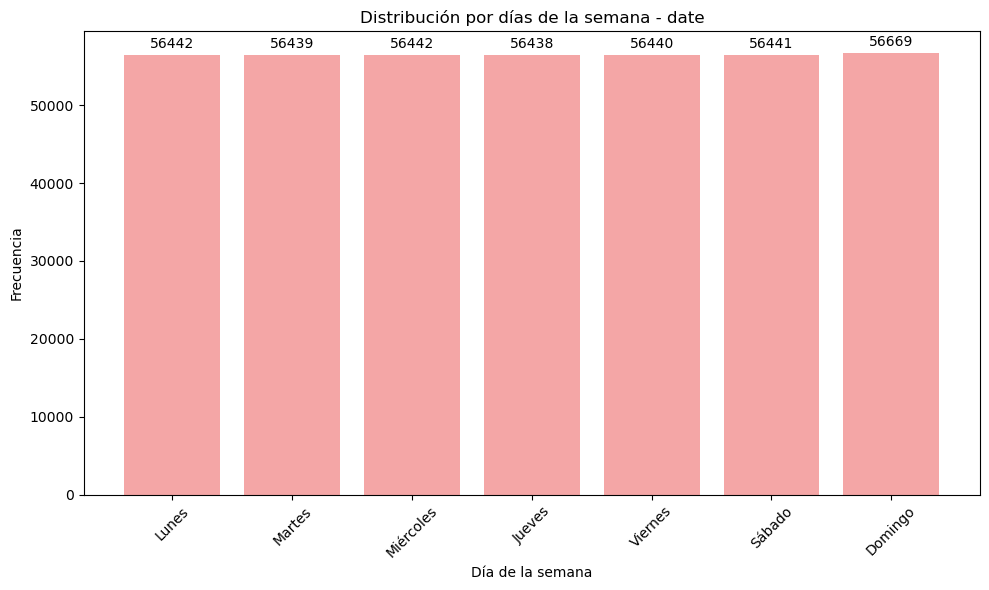

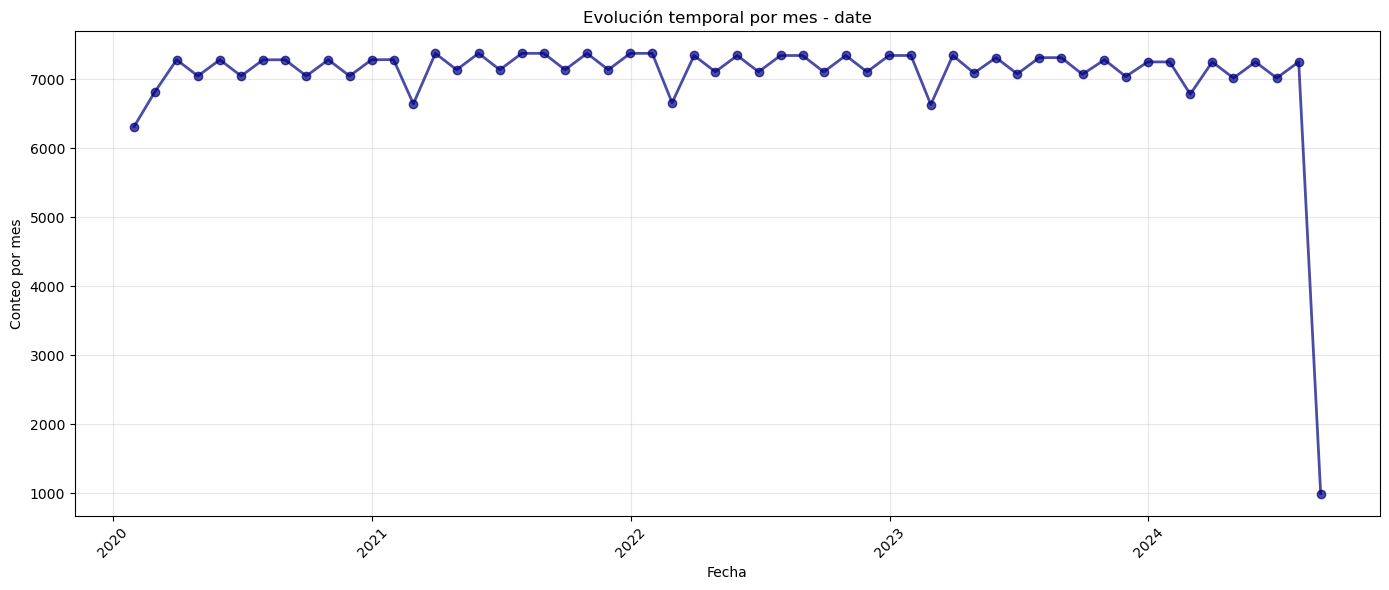

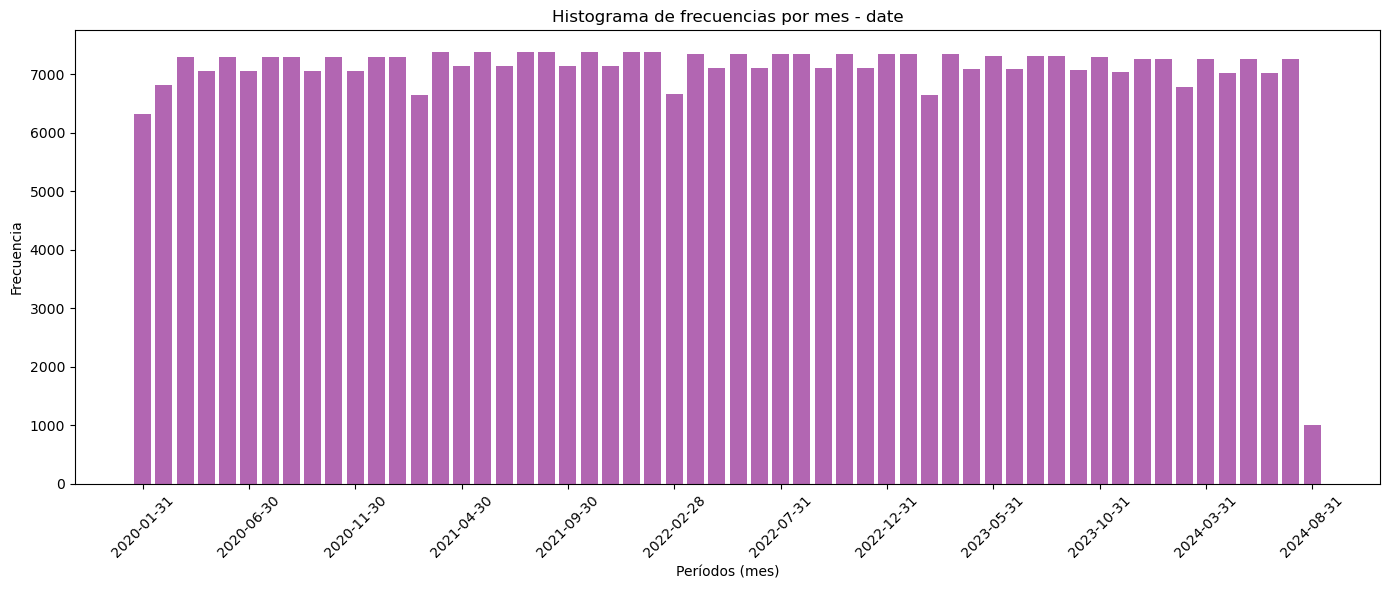

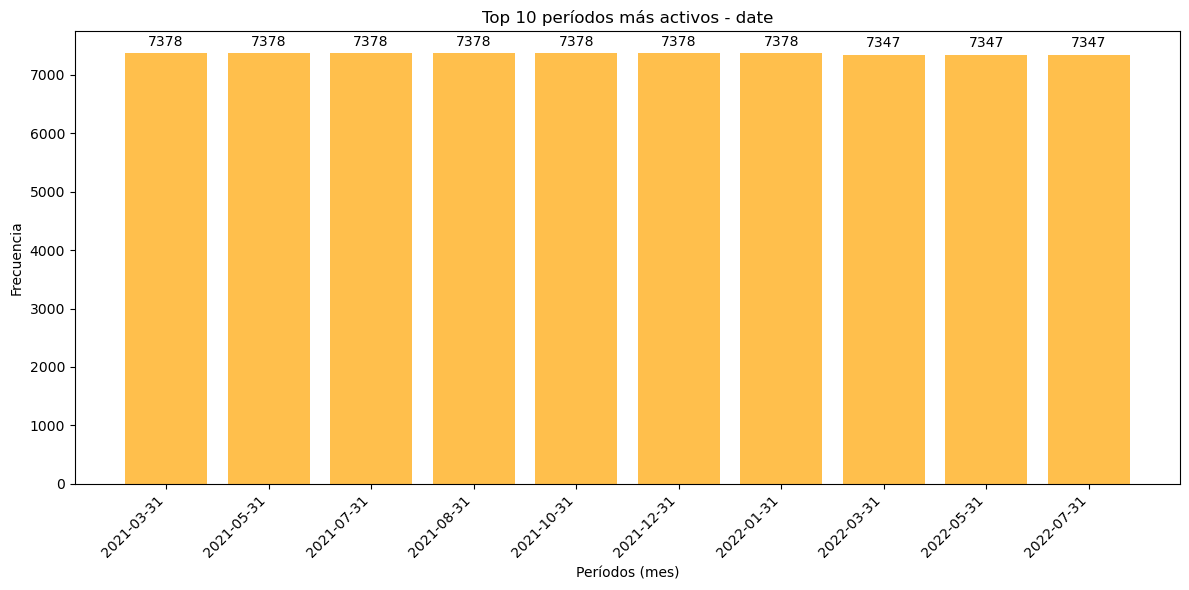

RESUMEN ESTADÍSTICO - date
Total de registros: 395,311
Fecha mínima: 2020-01-01
Fecha máxima: 2024-08-14
Rango temporal: 1,687 días (4 años)
Años únicos: 5
Meses únicos: 12

PATRONES TEMPORALES:
Año más frecuente: 2021
Mes más frecuente: Mar
Día de semana más frecuente:  Domingo

ANÁLISIS POR MES:
Períodos con datos: 56
Promedio por mes: 7059.1
Mediana por mes: 7254.0
Máximo por mes: 7,378
Mínimo por mes: 996
Concentración top 10:  18.6% de los datos



In [187]:
col = 'date'
info = analizar_variable_datetime(df_clean, col)

- continent

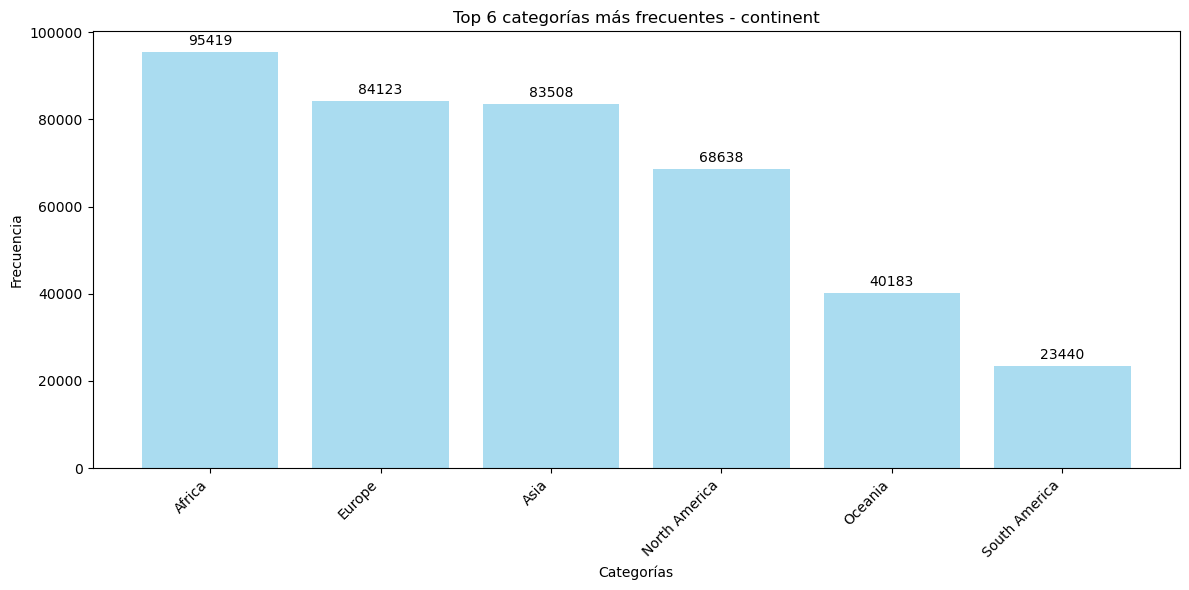

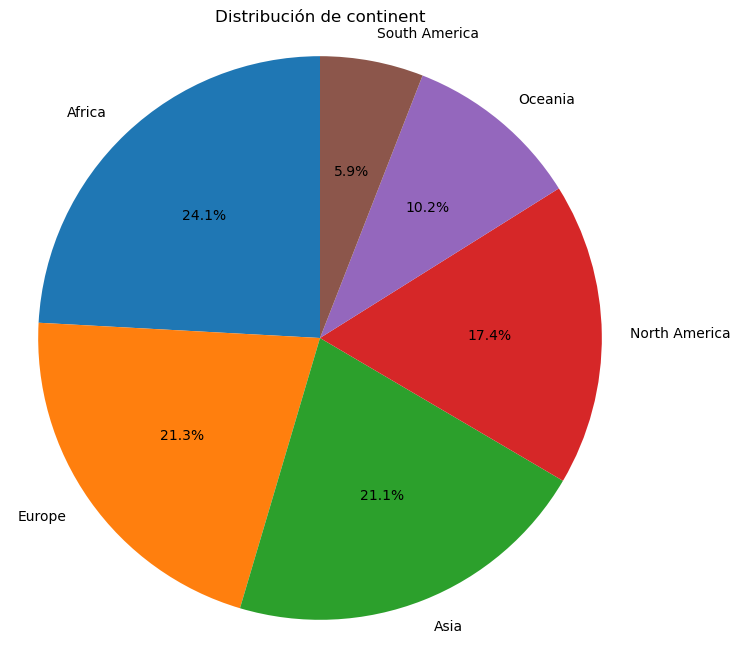

=============== Frecuencia de valores ===============
continent
Africa           95419
Europe           84123
Asia             83508
North America    68638
Oceania          40183
South America    23440
Name: count, dtype: int64
RESUMEN ESTADÍSTICO - continent
Total de registros: 395,311
Categorías únicas: 6
Categoría más frecuente: 'Africa'  (95,419 veces,  24.1%)
Categoría menos frecuente: 'South America'  (23,440 veces,  5.9%)
Concentración top 6:  100.0% de los datos


In [188]:
col = 'continent'
info = analizar_variable_categorica(df_clean, col)

- location

237 valores únicos

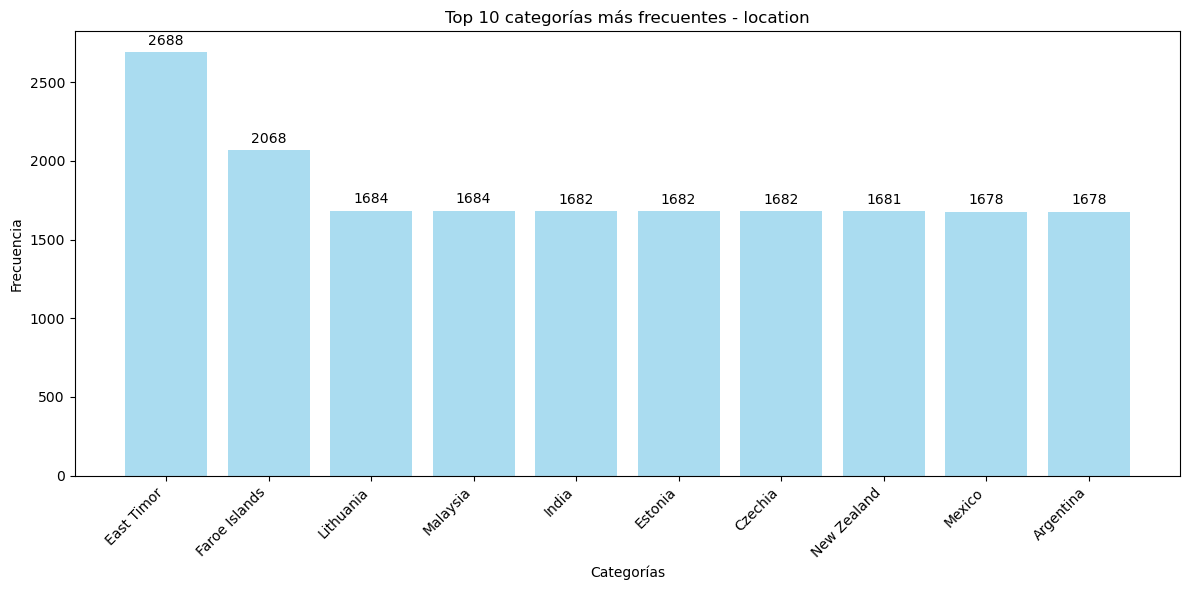

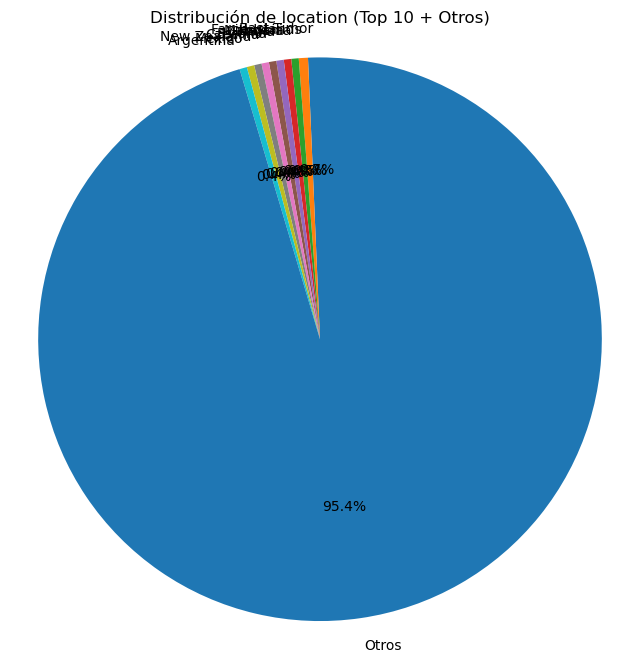

=============== Frecuencia de valores ===============
location
East Timor        2688
Faroe Islands     2068
Lithuania         1684
Malaysia          1684
India             1682
                  ... 
Turkmenistan      1674
Hong Kong         1654
Taiwan            1348
Macao              795
Western Sahara       1
Name: count, Length: 237, dtype: int64
RESUMEN ESTADÍSTICO - location
Total de registros: 395,311
Categorías únicas: 237
Categoría más frecuente: 'East Timor'  (2,688 veces,  0.7%)
Categoría menos frecuente: 'Western Sahara'  (1 veces,  0.0%)
Concentración top 10:  4.6% de los datos


In [189]:
col = 'location'
info = analizar_variable_categorica(df_clean, col)

- daily_millions_cases_ratio

Distribución muy sesgada con un 10% de outliers.

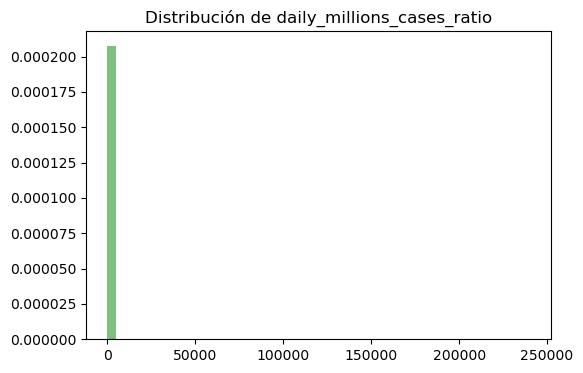

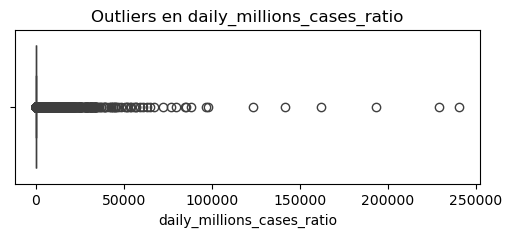

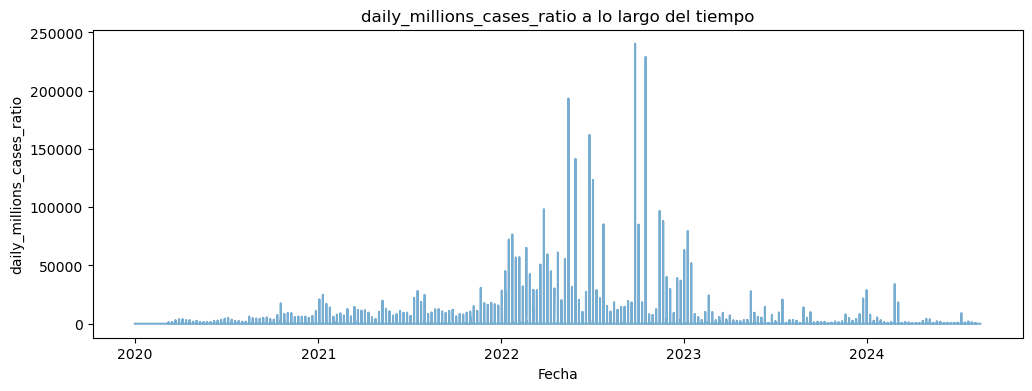

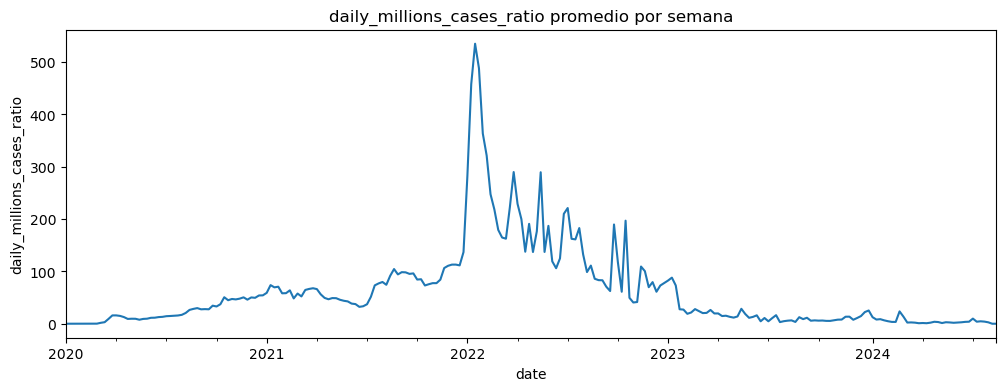

{'skewness': np.float64(94.52722587398249),
 'sesgo': 'muy sesgada',
 'num_outliers': 38743,
 'porcentaje_outliers': 9.800637978705375}

In [190]:
col = 'daily_millions_cases_ratio'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

- daily_thousands_deaths_ratio

Distribución muy sesgada con un 6% de outliers.

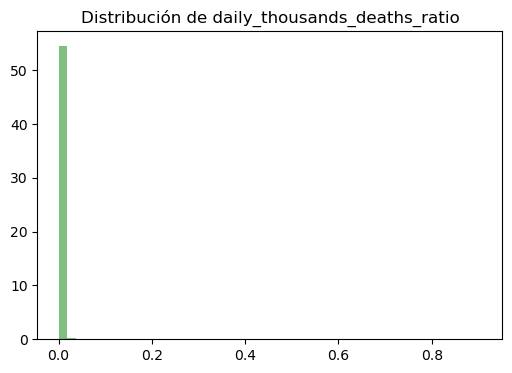

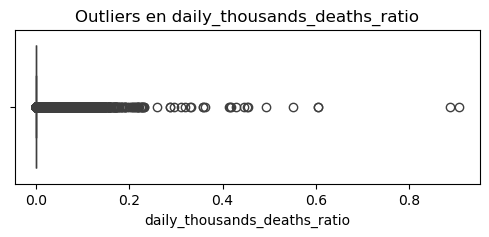

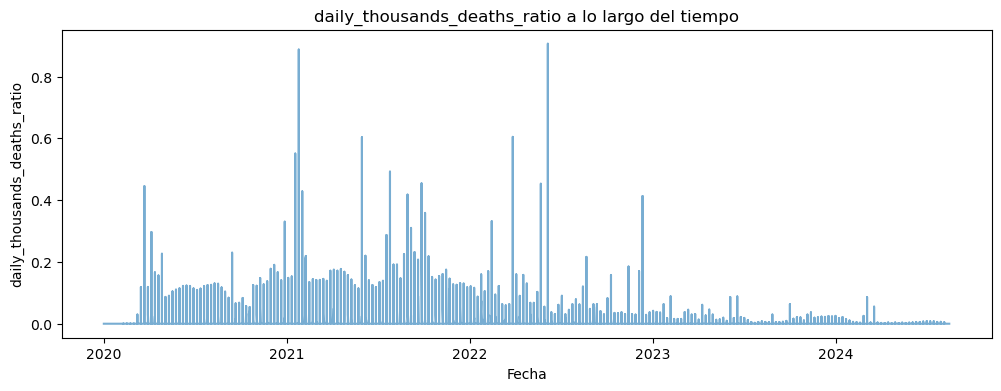

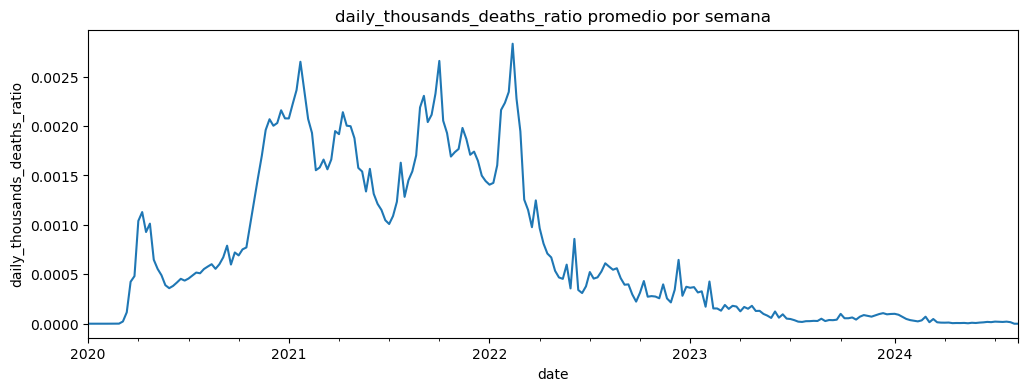

{'skewness': np.float64(31.870380158733983),
 'sesgo': 'muy sesgada',
 'num_outliers': 24808,
 'porcentaje_outliers': 6.275565314398031}

In [191]:
col = 'daily_thousands_deaths_ratio'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

- millions_cases_per_km2

Distribución muy sesgada con un 15% de outliers.

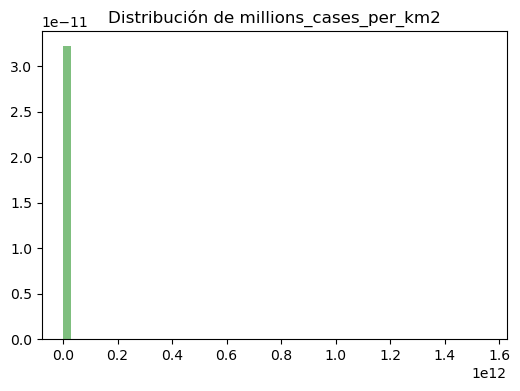

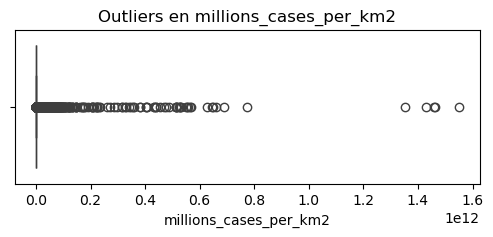

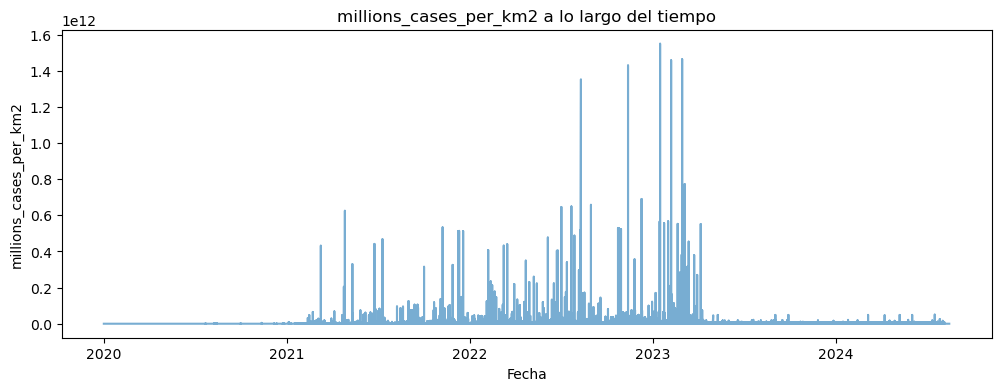

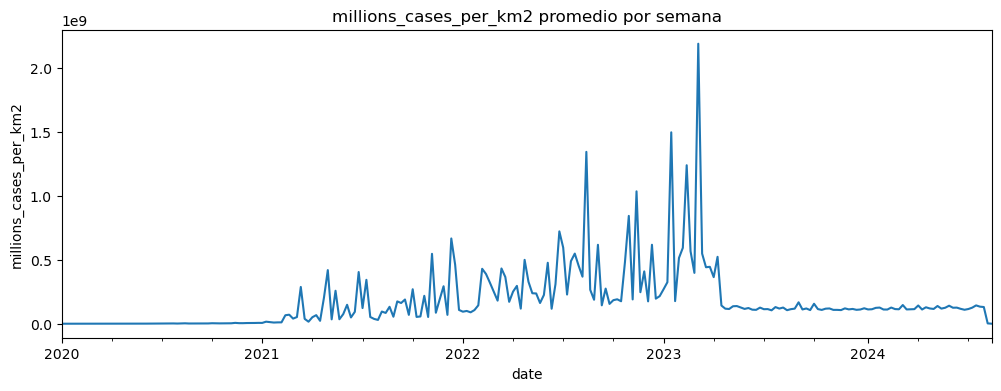

{'skewness': np.float64(123.51995186236597),
 'sesgo': 'muy sesgada',
 'num_outliers': 59450,
 'porcentaje_outliers': 15.03879224205752}

In [192]:
col = 'millions_cases_per_km2'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

- million_deaths_per_km2

Distribución muy sesgada con un 12% de outliers.

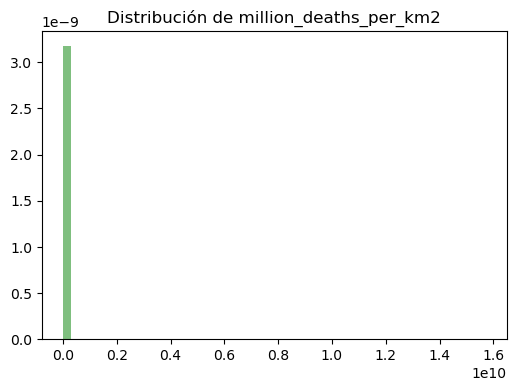

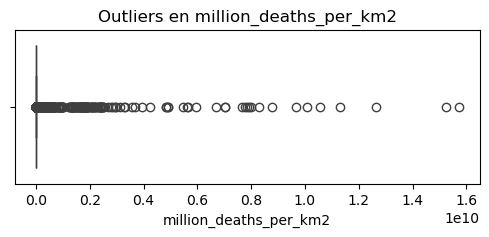

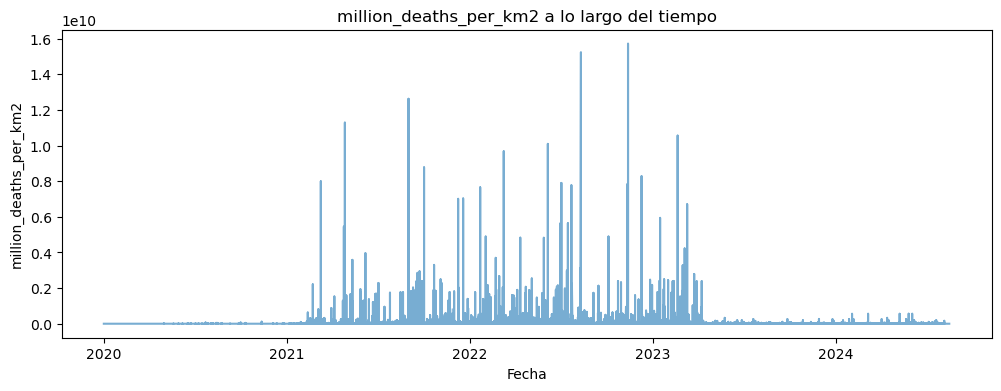

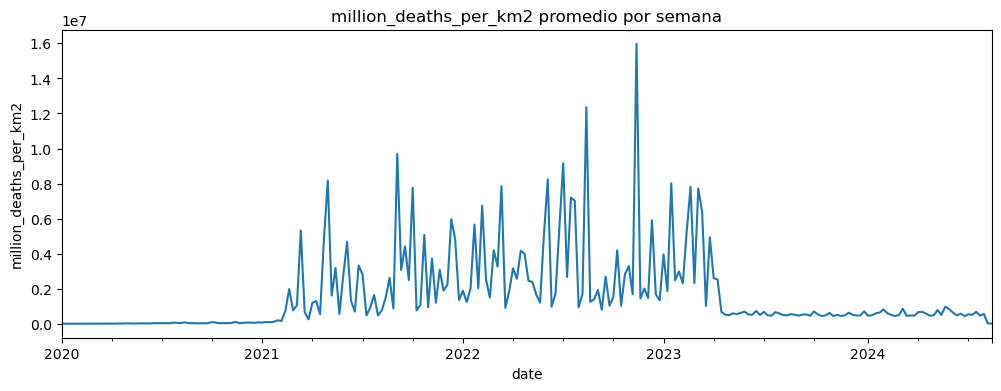

{'skewness': np.float64(112.61704391479307),
 'sesgo': 'muy sesgada',
 'num_outliers': 48842,
 'porcentaje_outliers': 12.355335419454557}

In [193]:
col = 'million_deaths_per_km2'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

- cases_per_65_older

Distribución muy sesgada con un 9% de outliers.

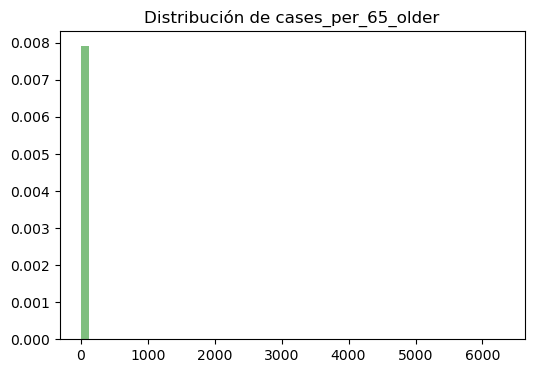

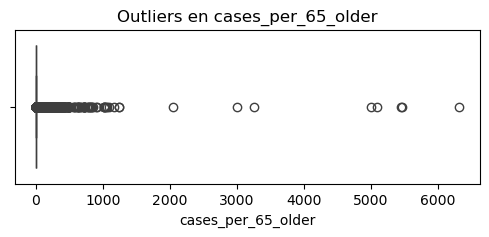

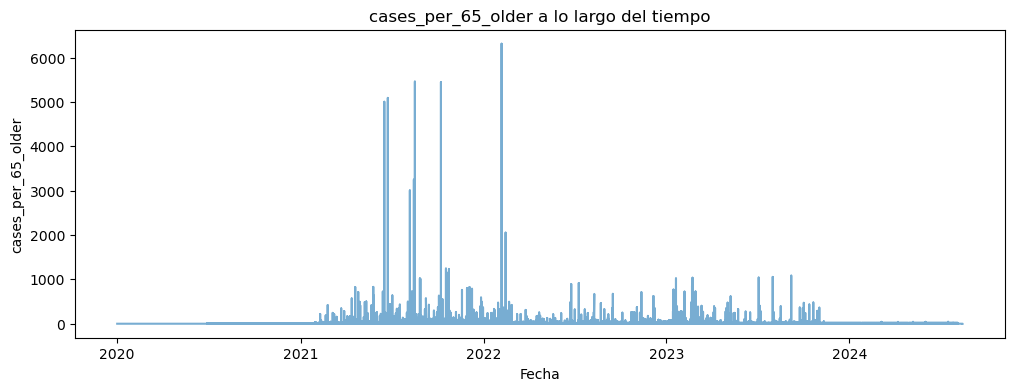

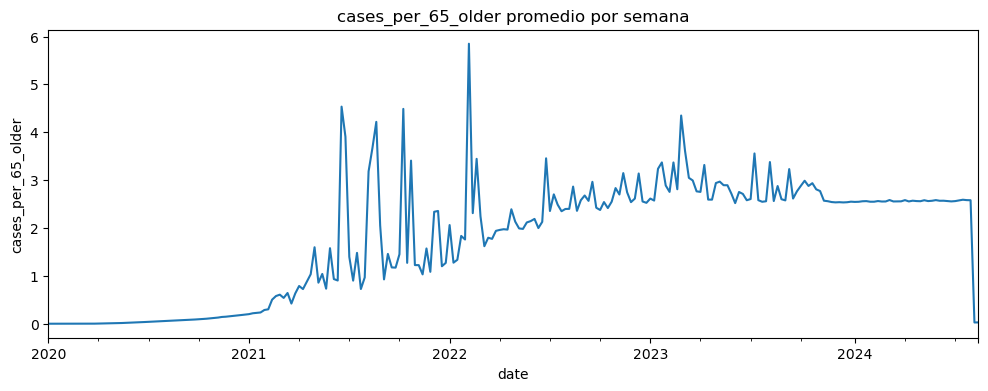

{'skewness': np.float64(178.45064481529394),
 'sesgo': 'muy sesgada',
 'num_outliers': 35806,
 'porcentaje_outliers': 9.057678637831986}

In [194]:
col = 'cases_per_65_older'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

- deaths_per_65_older

Distribución muy sesgada con un 4% de outliers.

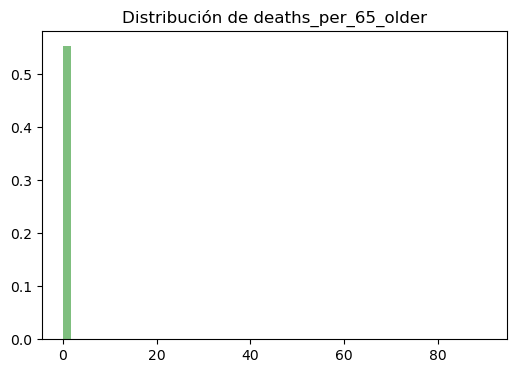

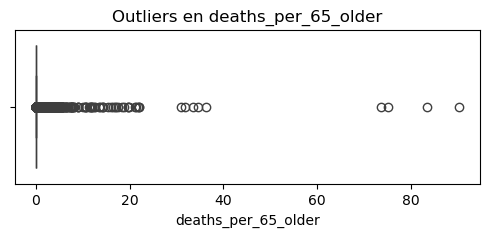

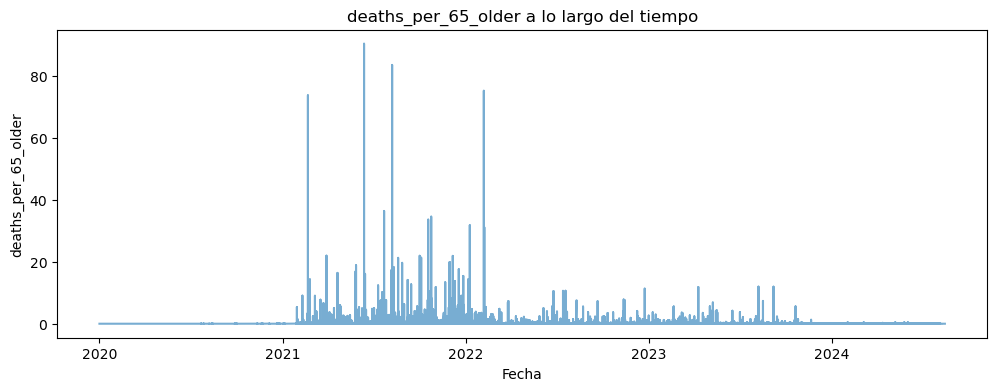

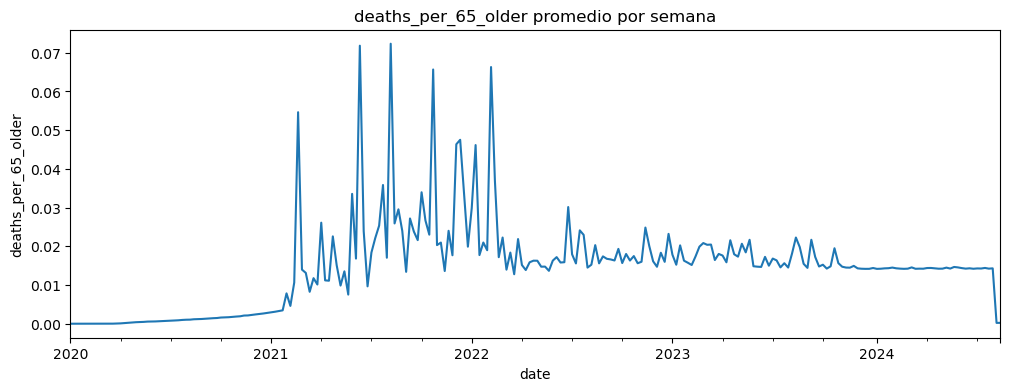

{'skewness': np.float64(170.03387009259265),
 'sesgo': 'muy sesgada',
 'num_outliers': 17093,
 'porcentaje_outliers': 4.323937355651626}

In [195]:
col = 'deaths_per_65_older'
col_fecha = 'date'

info = analizar_variable_numerica(df_clean, col, fecha_col=col_fecha)

display(info)

### Valores extremos

In [196]:
df_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population', 'growth_rate_cases',
       'growth_rate_deaths', 'case_fatality_rate',
       'daily_millions_cases_ratio', 'daily_thousands_deaths_ratio',
       'millions_cases_per_km2', 'million_deaths_per_km2',
       'cases_per_65_older', 'deaths_per_65_older'],
      dtype='object')

Variables en las que hemos encontrado outliers:

total_cases, new_cases, new_cases_smoothed, total_cases_per_million, new_cases_per_million, new_cases_smoothed_per_million, total_deaths, new_deaths, new_deaths_smoothed, total_deaths_per_million, new_deaths_per_million, new_deaths_smoothed_per_million, population_density, median_age, aged_65_older, aged_70_older, life_expentancy, diabetes_prevalence, growth_rate_cases, growth_rate_deaths, case_fatality_rate, daily_millions_cases_ratio, daily_thousands_deaths_ratio, millions_cases_per_km2, million_deaths_per_km2, cases_per_65_older, deaths_per_65_older

Todos los outliers encontrados son por arriba, salvo en life_expectancy, y para todas esas variables es razonable tener valores extremos por arriba, por lo que todos esos valores son válidos y se mantienen en el dataset.

En el caso de life_expectancy los outliers son por debajo, por desgracia es razonable considerar que hay países con una experiencia de vida suficientemente baja como para ser considerado un valor extremo. Por tanto, también vamos a mantener estos valores como válidos.

### 2.2. Codificación y escalado de datos

In [197]:
df_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population', 'growth_rate_cases',
       'growth_rate_deaths', 'case_fatality_rate',
       'daily_millions_cases_ratio', 'daily_thousands_deaths_ratio',
       'millions_cases_per_km2', 'million_deaths_per_km2',
       'cases_per_65_older', 'deaths_per_65_older'],
      dtype='object')

- Variables categóricas: continent, location

- Variables numéricas: total_cases, new_cases, new_cases_smoothed, total_cases_per_million, new_cases_per_million, new_cases_smoothed_per_million, total_deaths, new_deaths, new_deaths_smoothed, total_deaths_per_million, new_deaths_per_million, new_deaths_smoothed_per_million, population, population_density, median_age, aged_65_older, aged_70_older, diabetes_prevalence, life_expectancy, growth_rate_cases, growth_rate_deaths, case_fatality_rate, daily_millions_cases_ratio, daily_thousands_deaths_ratio, millions_cases_per_km2, million_deaths_per_km2, cases_per_70_older, deaths_per_70_older

- Variable de fecha: date

### Codificación de variables categóricas

In [198]:
le_dict = {}
le = LabelEncoder()

In [199]:
df_encoded = df_clean.copy()

<b>location</b>: variable categórica con 237 valores únicos, vamos a codificarla usando LabelEncoder

In [200]:
col = 'location'
print(df_encoded[[col]].nunique())

location    237
dtype: int64


In [201]:
le_dict[col] = apply_codification(df_encoded, col, 'LE')

location_encoded
59     2688
69     2068
120    1684
125    1684
65     1682
       ... 
236    1674
93     1654
207    1348
122     795
233       1
Name: count, Length: 237, dtype: int64


<b>continent</b>: variable categórica con 6 valores únicos, aplicamos LabelEncoder por no añadir 6 variables más al dataset

In [202]:
col = 'continent'
print(df_encoded[[col]].nunique())

continent    6
dtype: int64


In [203]:
le_dict[col] = apply_codification(df_encoded, col, 'LE')

continent_encoded
0    95419
2    84123
1    83508
3    68638
4    40183
5    23440
Name: count, dtype: int64


In [204]:
display(le_dict)

{'location': LabelEncoder(), 'continent': LabelEncoder()}

In [205]:
df_encoded[['continent_encoded', 'location_encoded']]

continent_encoded  location_encoded
0                       3               134
1                       5                 8
2                       3               134
3                       5                 8
4                       3               134
...                   ...               ...
395306                  1               125
395307                  1               125
395308                  2               120
395309                  2               120
395310                  1               125

[395311 rows x 2 columns]

### Escalado de variables numéricas

Ninguna variable numérica tiene distribución gaussiana, por lo que emplearíamos MinMax Scale.<br>
Pero todas las variables numéricas excepto 'median_age', 'aged_65_older' y 'aged_70_older' tienen valores extremos, y Standard Scale es más robusto ante valores extremos.<br>
Como consecuencia, vamos a usar Standard Scale para las variables con muchos outliers, y MinMax Scale para las tres variables indicadas.

In [206]:
scaler_dict = {}

<b>total_cases</b>

In [207]:
col = 'total_cases'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_cases</b>

In [208]:
col = 'new_cases'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_cases_smoothed</b>

In [209]:
col = 'new_cases_smoothed'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>total_cases_per_million</b>

In [210]:
col = 'total_cases_per_million'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_cases_per_million</b>

In [211]:
col = 'new_cases_per_million'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_cases_smoothed_per_million</b>

In [212]:
col = 'new_cases_smoothed_per_million'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>total_deaths</b>

In [213]:
col = 'total_deaths'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_deaths</b>

In [214]:
col = 'new_deaths'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_deaths_smoothed</b>

In [215]:
col = 'new_deaths_smoothed'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>total_deaths_per_million</b>

In [216]:
col = 'total_deaths_per_million'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_deaths_per_million</b>

In [217]:
col = 'new_deaths_per_million'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>new_deaths_smoothed_per_million</b>

In [218]:
col = 'new_deaths_smoothed_per_million'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>population</b>

In [219]:
col = 'population'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>population_density</b>

In [220]:
col = 'population_density'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>median_age</b>: como hemos visto, al no tener outliers vamos a usar MinMax Scale.

In [221]:
col = 'median_age'
scaler_dict[col] = apply_codification(df_encoded, col, 'MM')

<b>aged_65_older</b>: MinMax Scale

In [222]:
col = 'aged_65_older'
scaler_dict[col] = apply_codification(df_encoded, col, 'MM')

<b>aged_70_older</b>: MinMax Scale

In [223]:
col = 'aged_70_older'
scaler_dict[col] = apply_codification(df_encoded, col, 'MM')

<b>diabetes_prevalence</b>

In [224]:
col = 'diabetes_prevalence'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>life_expectancy</b>

In [225]:
col = 'life_expectancy'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>growth_rate_cases</b>

In [226]:
col = 'growth_rate_cases'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>growth_rate_deaths</b>

In [227]:
col = 'growth_rate_deaths'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>case_fatality_rate</b>

In [228]:
col = 'case_fatality_rate'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>daily_millions_cases_ratio</b>

In [229]:
col = 'daily_millions_cases_ratio'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>daily_thousands_deaths_ratio</b>

In [230]:
col = 'daily_thousands_deaths_ratio'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>millions_cases_per_km2</b>

In [231]:
col = 'millions_cases_per_km2'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>million_deaths_per_km2</b>

In [232]:
col = 'million_deaths_per_km2'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>cases_per_65_older</b>

In [233]:
col = 'cases_per_65_older'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

<b>deaths_per_65_older</b>

In [234]:
col = 'deaths_per_65_older'
scaler_dict[col] = apply_codification(df_encoded, col, 'SS')

In [235]:
display(scaler_dict)

{'total_cases': StandardScaler(),
 'new_cases': StandardScaler(),
 'new_cases_smoothed': StandardScaler(),
 'total_cases_per_million': StandardScaler(),
 'new_cases_per_million': StandardScaler(),
 'new_cases_smoothed_per_million': StandardScaler(),
 'total_deaths': StandardScaler(),
 'new_deaths': StandardScaler(),
 'new_deaths_smoothed': StandardScaler(),
 'total_deaths_per_million': StandardScaler(),
 'new_deaths_per_million': StandardScaler(),
 'new_deaths_smoothed_per_million': StandardScaler(),
 'population': StandardScaler(),
 'population_density': StandardScaler(),
 'median_age': MinMaxScaler(),
 'aged_65_older': MinMaxScaler(),
 'aged_70_older': MinMaxScaler(),
 'diabetes_prevalence': StandardScaler(),
 'life_expectancy': StandardScaler(),
 'growth_rate_cases': StandardScaler(),
 'growth_rate_deaths': StandardScaler(),
 'case_fatality_rate': StandardScaler(),
 'daily_millions_cases_ratio': StandardScaler(),
 'daily_thousands_deaths_ratio': StandardScaler(),
 'millions_cases_pe

In [236]:
df_encoded[['total_cases_encoded', 'new_cases_encoded',
            'new_cases_smoothed_encoded', 'total_cases_per_million_encoded',
            'new_cases_per_million_encoded', 'new_cases_smoothed_per_million_encoded', 
            'total_deaths_encoded', 'new_deaths_encoded', 'new_deaths_smoothed_encoded',
            'total_deaths_per_million_encoded', 'new_deaths_per_million_encoded',
            'new_deaths_smoothed_per_million_encoded', 'population_encoded',
            'population_density_encoded', 'median_age_encoded', 'aged_65_older_encoded', 
            'aged_70_older_encoded', 'diabetes_prevalence_encoded', 
            'life_expectancy_encoded', 'growth_rate_cases_encoded', 
            'growth_rate_deaths_encoded', 'case_fatality_rate_encoded', 
            'daily_millions_cases_ratio_encoded', 'daily_thousands_deaths_ratio_encoded',
            'millions_cases_per_km2_encoded', 'million_deaths_per_km2_encoded',
            'cases_per_65_older_encoded', 'deaths_per_65_older_encoded'
           ]]

total_cases_encoded  new_cases_encoded  new_cases_smoothed_encoded  \
0                 -0.233643          -0.023006                   -0.060698   
1                 -0.233643          -0.023006                   -0.060698   
2                 -0.233643          -0.023006                   -0.060698   
3                 -0.233643          -0.023006                   -0.060698   
4                 -0.233643          -0.023006                   -0.060698   
...                     ...                ...                         ...   
395306            -0.230890          -0.023006                   -0.060698   
395307            -0.230890          -0.023006                   -0.060698   
395308            -0.230890          -0.023006                   -0.060698   
395309            -0.230890          -0.023006                   -0.060698   
395310            -0.230890          -0.023006                   -0.060698   

        total_cases_per_million_encoded  new_cases_per_million_encoded  \
0                             -0.689069                      -0.079338   
1                             -0.689069                      -0.079338   
2                             -0.689069                      -0.079338   
3                             -0.689069                      -0.079338   
4                             -0.689069                      -0.079338   
...                                 ...                            ...   
395306                        -0.146444                      -0.079338   
395307                        -0.146444                      -0.079338   
395308                        -0.146444                      -0.079338   
395309                        -0.146444                      -0.079338   
395310                        -0.146444                      -0.079338   

        new_cases_smoothed_per_million_encoded  total_deaths_encoded  \
0                                    -0.209858             -0.248752   
1                                    -0.209858             -0.248752   
2                                    -0.209858             -0.248752   
3                                    -0.209858             -0.248752   
4                                    -0.209858             -0.248752   
...                                        ...                   ...   
395306                               -0.209858             -0.246607   
395307                               -0.209858             -0.246607   
395308                               -0.209858             -0.246607   
395309                               -0.209858             -0.246607   
395310                               -0.209858             -0.246607   

        new_deaths_encoded  new_deaths_smoothed_encoded  \
0                -0.057045                    -0.152407   
1                -0.057045                    -0.152407   
2                -0.057045                    -0.152407   
3                -0.057045                    -0.152407   
4                -0.057045                    -0.152407   
...                    ...                          ...   
395306           -0.057045                    -0.152407   
395307           -0.057045                    -0.152407   
395308           -0.057045                    -0.152407   
395309           -0.057045                    -0.152407   
395310           -0.057045                    -0.152407   

        total_deaths_per_million_encoded  ...  life_expectancy_encoded  \
0                              -0.726517  ...                 0.179813   
1                              -0.726517  ...                 0.400442   
2                              -0.726517  ...                 0.179813   
3                              -0.726517  ...                 0.400442   
4                              -0.726517  ...                 0.179813   
...                                  ...  ...                      ...   
395306                         -0.548487  ...                 0.330985   
395307          

### Codificación de variables de fecha

In [237]:
col = 'date'
apply_codification(df_encoded, col, 'DT')

In [238]:
df_encoded[[
    'date_year', 'date_month', 'date_day', 'date_dayofweek', 'date_week',
       'date_days_since_covid', 'date_month_sin', 'date_month_cos',
       'date_dayofweek_sin', 'date_dayofweek_cos', 'date_is_weekend',
       'date_covid_period'
]]

date_year  date_month  date_day  date_dayofweek  date_week  \
0            2020           1         1               2          1   
1            2020           1         1               2          1   
2            2020           1         2               3          1   
3            2020           1         2               3          1   
4            2020           1         3               4          1   
...           ...         ...       ...             ...        ...   
395306       2024           8        12               0         33   
395307       2024           8        13               1         33   
395308       2024           8        13               1         33   
395309       2024           8        14               2         33   
395310       2024           8        14               2         33   

        date_days_since_covid  date_month_sin  date_month_cos  \
0                           0        0.500000        0.866025   
1                           0        0.500000        0.866025   
2                           1        0.500000        0.866025   
3                           1        0.500000        0.866025   
4                           2        0.500000        0.866025   
...                       ...             ...             ...   
395306                   1685       -0.866025       -0.500000   
395307                   1686       -0.866025       -0.500000   
395308                   1686       -0.866025       -0.500000   
395309                   1687       -0.866025       -0.500000   
395310                   1687       -0.866025       -0.500000   

        date_dayofweek_sin  date_dayofweek_cos  date_is_weekend  \
0                 0.974928           -0.222521            False   
1                 0.974928           -0.222521            False   
2                 0.433884           -0.900969            False   
3                 0.433884           -0.900969            False   
4                -0.433884           -0.900969            False   
...                    ...                 ...              ...   
395306            0.000000            1.000000            False   
395307            0.781831            0.623490            False   
395308            0.781831            0.623490            False   
395309            0.974928           -0.222521            False   
395310            0.974928           -0.222521            False   

       date_covid_period  
0            primera_ola  
1            primera_ola  
2            primera_ola  
3            primera_ola  
4            primera_ola  
...                  ...  
395306          endemica  
395307          endemica  
395308          endemica  
395309          endemica  
395310          endemica  

[395311 rows x 12 columns]

In [239]:
df_encoded.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population', 'growth_rate_cases',
       'growth_rate_deaths', 'case_fatality_rate',
       'daily_millions_cases_ratio', 'daily_thousands_deaths_ratio',
       'millions_cases_per_km2', 'million_deaths_per_km2',
       'cases_per_65_older', 'deaths_per_65_older', 'location_encoded',
       'continent_encoded', 'total_cases_encoded', 'new_cases_encoded',
       'new_cases_smoothed_encoded', 'total_cases_per_million_encoded',
       'new_cases_per_million_encoded',
       'new_cases_smoothed_per_million_encoded', 't

In [240]:
df_encoded.head()

date      continent   location  total_cases  new_cases  \
0 2020-01-01  North America     Mexico          0.0          0   
1 2020-01-01  South America  Argentina          0.0          0   
2 2020-01-02  North America     Mexico          0.0          0   
3 2020-01-02  South America  Argentina          0.0          0   
4 2020-01-03  North America     Mexico          0.0          0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                8.71           0.0           0                  0.0   
1                8.71           0.0           0                  0.0   
2                8.71           0.0           0                  0.0   
3                8.71           0.0           0                  0.0   
4                8.71           0.0           0                  0.0   

   total_cases_per_million  ...  date_day  date_dayofweek  date_week  \
0                      0.0  ...         1               2          1   
1                      0.0  ...         1               2          1   
2                      0.0  ...         2               3          1   
3                      0.0  ...         2               3          1   
4                      0.0  ...         3               4          1   

   date_days_since_covid  date_month_sin  date_month_cos  date_dayofweek_sin  \
0                      0             0.5        0.866025            0.974928   
1                      0             0.5        0.866025            0.974928   
2                      1             0.5        0.866025            0.433884   
3                      1             0.5        0.866025            0.433884   
4                      2             0.5        0.866025           -0.433884   

   date_dayofweek_cos  date_is_weekend  date_covid_period  
0           -0.222521            False        primera_ola  
1           -0.222521            False        primera_ola  
2           -0.900969            False        primera_ola  
3           -0.900969            False        primera_ola  
4           -0.900969            False        primera_ola  

[5 rows x 73 columns]

### 2.3. Mapa de correlaciones

<b>1. Eliminación de variables</b>

Vamos a eliminar del dataset todas las variables que no nos sirvan para calcular las correlaciones.

In [241]:
df_encoded.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'diabetes_prevalence',
       'life_expectancy', 'population', 'growth_rate_cases',
       'growth_rate_deaths', 'case_fatality_rate',
       'daily_millions_cases_ratio', 'daily_thousands_deaths_ratio',
       'millions_cases_per_km2', 'million_deaths_per_km2',
       'cases_per_65_older', 'deaths_per_65_older', 'location_encoded',
       'continent_encoded', 'total_cases_encoded', 'new_cases_encoded',
       'new_cases_smoothed_encoded', 'total_cases_per_million_encoded',
       'new_cases_per_million_encoded',
       'new_cases_smoothed_per_million_encoded', 't

In [242]:
corr_matrix = df_encoded.copy()
corr_matrix.drop(['date', 'continent', 'location', 'total_cases', 'new_cases', 
                  'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 
                  'new_cases_smoothed_per_million', 'total_deaths', 'new_deaths',
                  'new_deaths_smoothed', 'total_deaths_per_million', 
                  'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'population',
                  'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 
                  'diabetes_prevalence', 'life_expectancy', 'growth_rate_cases',
                  'growth_rate_deaths', 'case_fatality_rate', 'daily_millions_cases_ratio',
                  'daily_thousands_deaths_ratio', 'millions_cases_per_km2', 
                  'million_deaths_per_km2', 'cases_per_65_older', 'deaths_per_65_older', 
                  'date_covid_period'], 
                 axis='columns', inplace=True)

corr_matrix.columns

Index(['location_encoded', 'continent_encoded', 'total_cases_encoded',
       'new_cases_encoded', 'new_cases_smoothed_encoded',
       'total_cases_per_million_encoded', 'new_cases_per_million_encoded',
       'new_cases_smoothed_per_million_encoded', 'total_deaths_encoded',
       'new_deaths_encoded', 'new_deaths_smoothed_encoded',
       'total_deaths_per_million_encoded', 'new_deaths_per_million_encoded',
       'new_deaths_smoothed_per_million_encoded', 'population_encoded',
       'population_density_encoded', 'median_age_encoded',
       'aged_65_older_encoded', 'aged_70_older_encoded',
       'diabetes_prevalence_encoded', 'life_expectancy_encoded',
       'growth_rate_cases_encoded', 'growth_rate_deaths_encoded',
       'case_fatality_rate_encoded', 'daily_millions_cases_ratio_encoded',
       'daily_thousands_deaths_ratio_encoded',
       'millions_cases_per_km2_encoded', 'million_deaths_per_km2_encoded',
       'cases_per_65_older_encoded', 'deaths_per_65_older_encoded',
  

<b>2. Matriz de correlación</b>

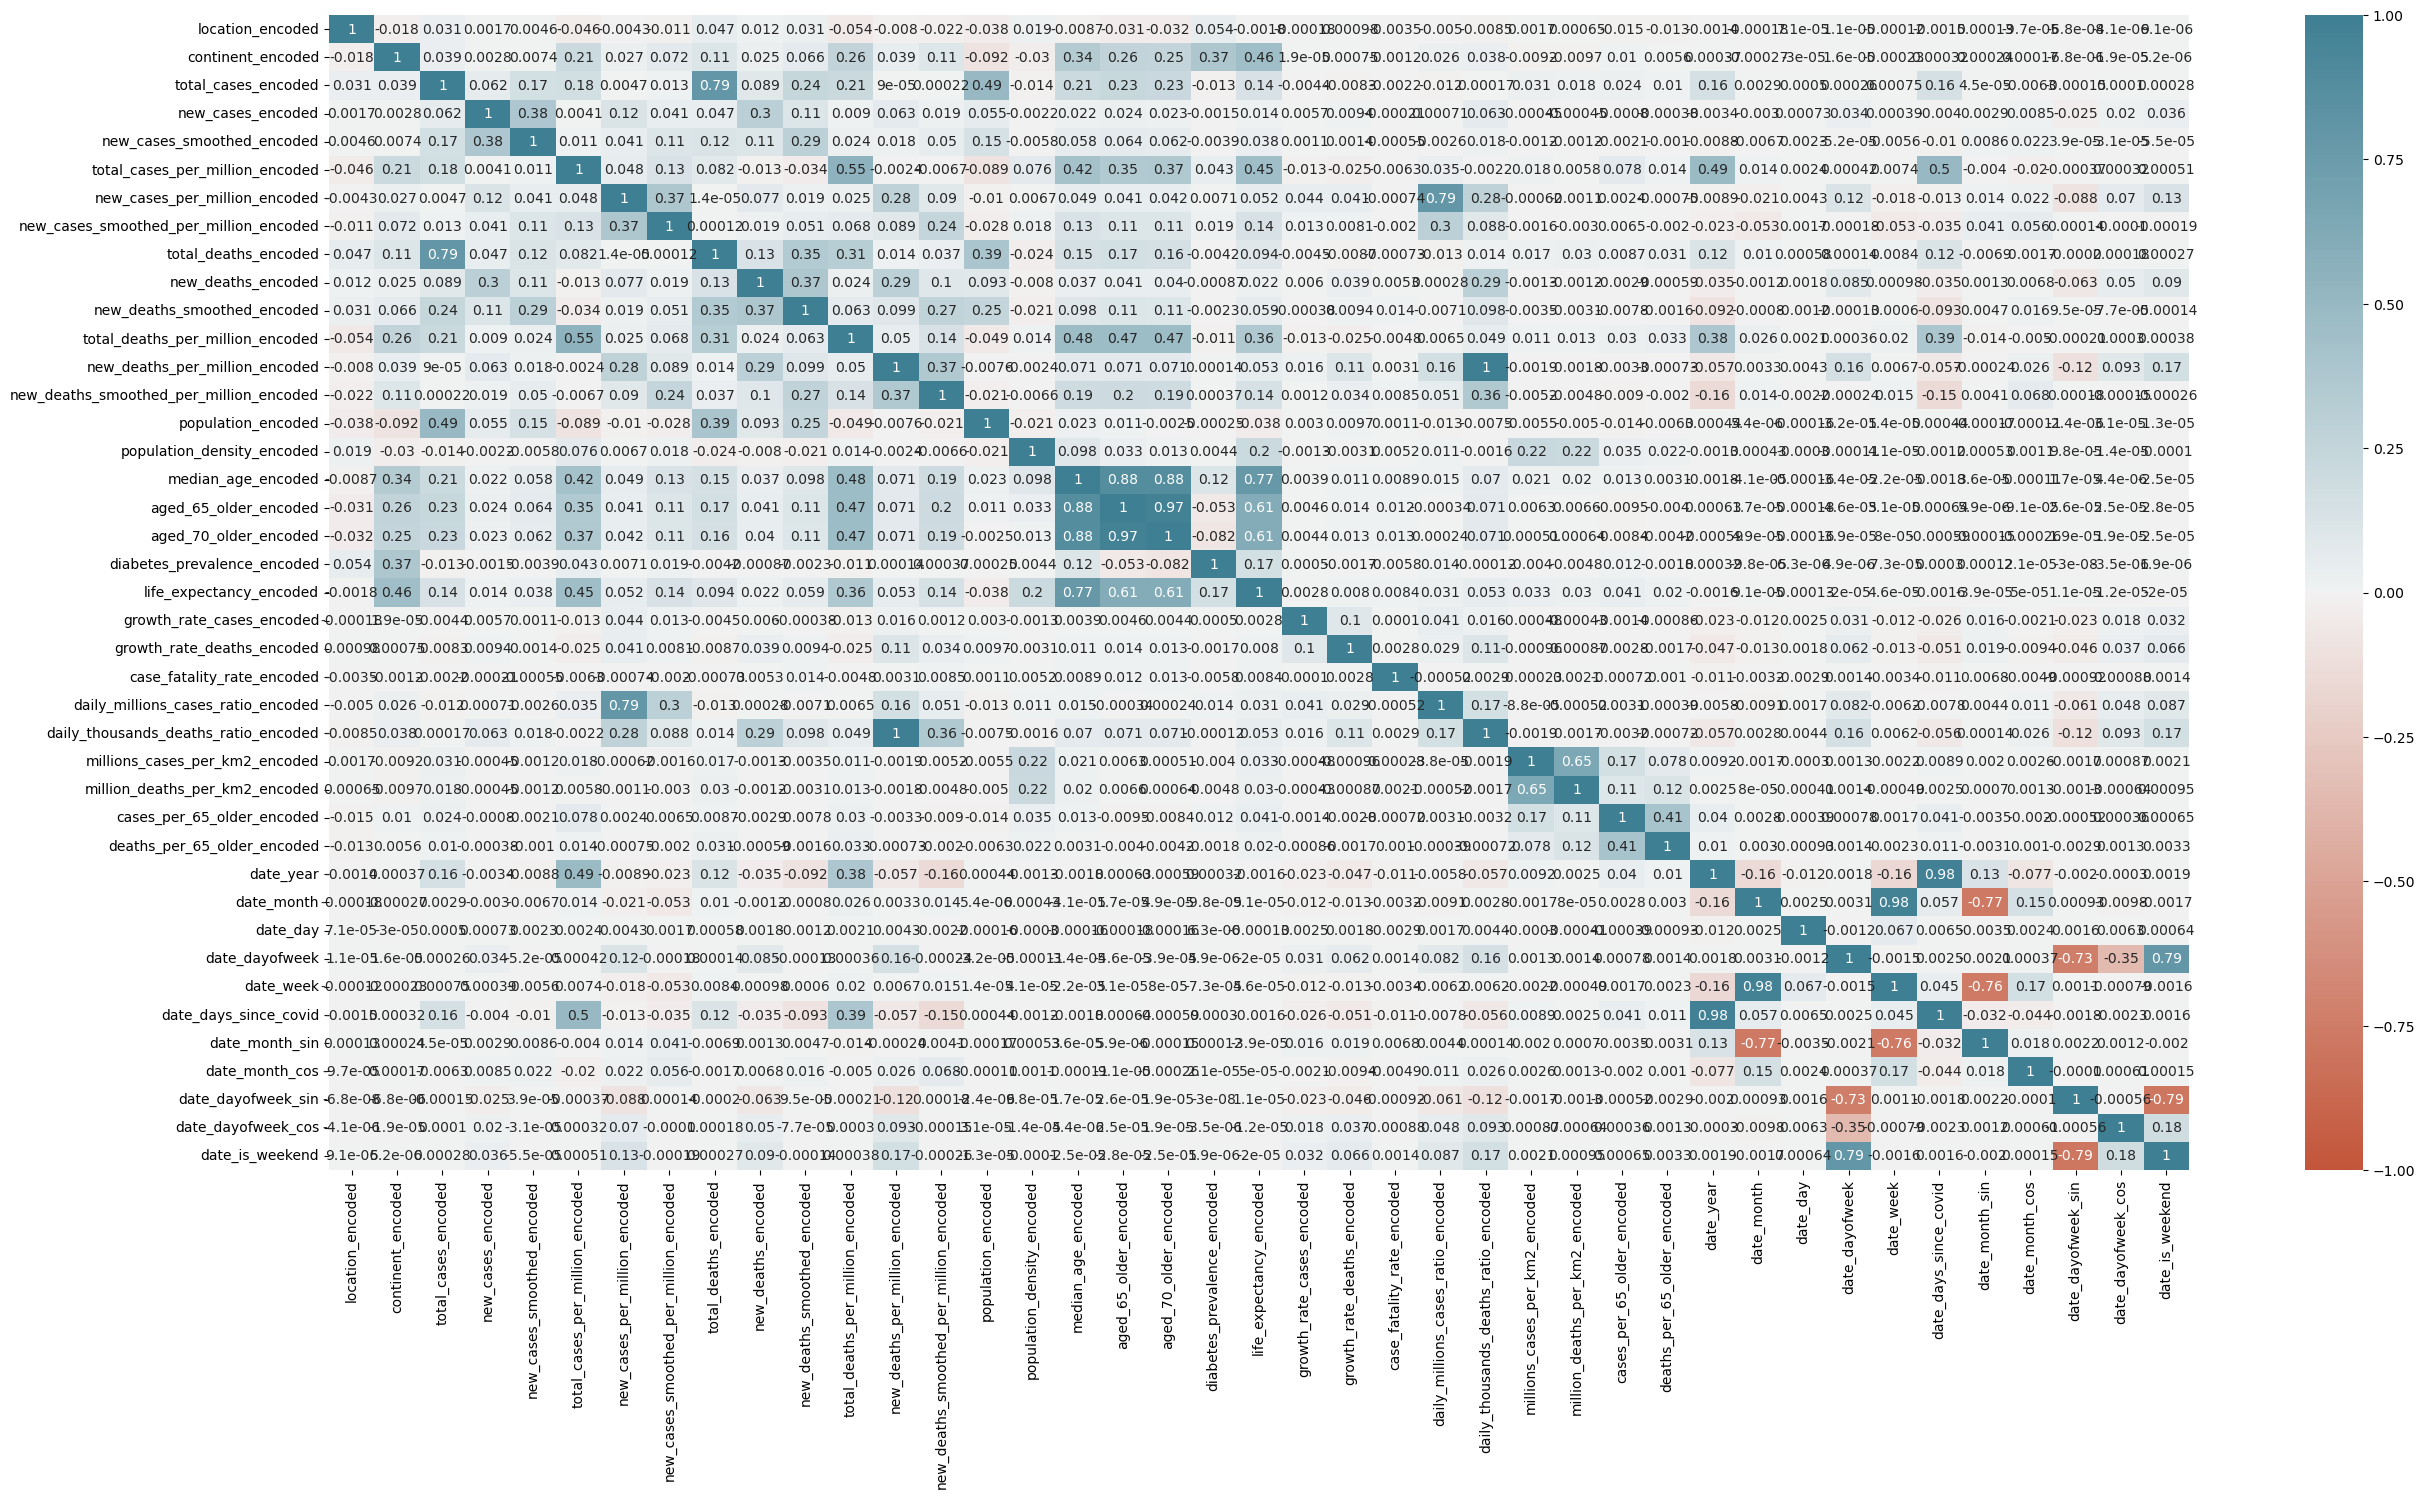

In [243]:
plt.figure(figsize=(30, 15))
sns.heatmap(
    corr_matrix.corr(), annot=True, cmap=sns.diverging_palette(20, 220, n=256), 
    vmin=-1, vmax=1
)
plt.show()

Al ser una matriz muy grande, vamos a dividirla en partes para estudiarla mejor.

In [244]:
'''
funciona, pero no me convence el resultado
'''
'''
def plot_correlation_blocks(corr_matrix, block_size=10, figsize=(12, 10)):
    """
    Divide una matriz de correlación en bloques cuadrados más pequeños
    
    Parameters:
    - corr_matrix: DataFrame con la matriz de correlación
    - block_size: tamaño de cada bloque (por defecto 10x10)
    - figsize: tamaño de cada figura
    """
    n_vars = len(corr_matrix.columns)
    n_blocks = ceil(n_vars / block_size)
    
    for i in range(n_blocks):
        for j in range(n_blocks):
            # Definir los límites del bloque
            start_row = i * block_size
            end_row = min((i + 1) * block_size, n_vars)
            start_col = j * block_size
            end_col = min((j + 1) * block_size, n_vars)
            
            # Extraer el bloque
            block = corr_matrix.iloc[start_row:end_row, start_col:end_col]
            
            # Solo mostrar si el bloque no está vacío
            if block.shape[0] > 0 and block.shape[1] > 0:
                plt.figure(figsize=figsize)
                sns.heatmap(
                    block, 
                    annot=True, 
                    cmap=sns.diverging_palette(20, 220, n=256),
                    vmin=-1, 
                    vmax=1,
                    fmt='.2f',
                    square=True
                )
                plt.title(f'Bloque de Correlación [{start_row}:{end_row}, {start_col}:{end_col}]')
                plt.tight_layout()
                plt.show()

# Dividir en bloques de 10x10 (tendrás aproximadamente 16 gráficos más manejables)
split_correlation_matrix(corr_matrix, method='blocks', block_size=10)
'''
print()

In [245]:
def plot_correlation_strips(corr_matrix, strip_height=10, figsize=(20, 8)):
    """
    Divide una matriz de correlación en franjas horizontales
    
    Args:
        corr_matrix: DataFrame con la matriz de correlación
        strip_height: altura de cada franja
        figsize: tamaño de cada figura
    """
    # asegura que tengamos una matriz de correlación
    correlation_data = corr_matrix.corr() if hasattr(corr_matrix, 'corr') else corr_matrix
    
    n_vars = len(correlation_data.columns)
    n_strips = ceil(n_vars / strip_height)
    
    for i in range(n_strips):
        start_row = i * strip_height
        end_row = min((i + 1) * strip_height, n_vars)
        
        # Extraer la franja (todas las columnas, algunas filas)
        strip = correlation_data.iloc[start_row:end_row, :]
        
        plt.figure(figsize=figsize)
        sns.heatmap(
            strip, 
            annot=True, 
            cmap=sns.diverging_palette(20, 220, n=256),
            vmin=-1, 
            vmax=1,
            fmt='.2f'
        )
        plt.title(f'Franja de Correlación - Filas {start_row} a {end_row-1}')
        plt.tight_layout()
        plt.show()

In [246]:
# Función para mostrar correlaciones más altas por grupos
'''
funciona pero no me convence el resultado
'''
'''
def plot_top_correlations_by_groups(corr_matrix, n_groups=4, top_n=15, figsize=(12, 8)):
    """
    Divide las variables en grupos y muestra las correlaciones más altas de cada grupo
    
    Parameters:
    - corr_matrix: DataFrame con la matriz de correlación
    - n_groups: número de grupos a crear
    - top_n: número de correlaciones más altas a mostrar por grupo
    - figsize: tamaño de cada figura
    """
    n_vars = len(corr_matrix.columns)
    group_size = ceil(n_vars / n_groups)
    
    for group in range(n_groups):
        start_idx = group * group_size
        end_idx = min((group + 1) * group_size, n_vars)
        
        # Seleccionar variables del grupo
        group_vars = corr_matrix.columns[start_idx:end_idx]
        group_corr = corr_matrix.loc[group_vars, group_vars]
        
        # Obtener triángulo superior de la matriz (sin diagonal)
        mask = np.triu(np.ones_like(group_corr), k=1).astype(bool)
        group_corr_upper = group_corr.where(mask)
        
        # Convertir a formato largo y obtener top correlaciones
        corr_pairs = group_corr_upper.stack().reset_index()
        corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
        corr_pairs = corr_pairs.reindex(corr_pairs['Correlation'].abs().sort_values(ascending=False).index)
        top_corr = corr_pairs.head(top_n)
        
        if len(top_corr) > 0:
            plt.figure(figsize=figsize)
            sns.heatmap(
                group_corr, 
                annot=True, 
                cmap=sns.diverging_palette(20, 220, n=256),
                vmin=-1, 
                vmax=1,
                fmt='.2f',
                square=True
            )
            plt.title(f'Grupo {group + 1}: Variables {start_idx} a {end_idx-1}\n'
                     f'Top correlaciones: {top_corr.iloc[0]["Correlation"]:.3f}')
            plt.tight_layout()
            plt.show()

# 4 grupos enfocados en las correlaciones más importantes
split_correlation_matrix(corr_matrix, method='top_groups', n_groups=4)
'''
print()

In [247]:
# Función principal para usar con tu código
'''
funciona, pero sólo voy a usar uno de los métodos
'''
'''
def split_correlation_matrix(corr_matrix, method='blocks', **kwargs):
    """
    Función principal para dividir matriz de correlación
    
    Parameters:
    - corr_matrix: tu matriz de correlación (corr_matrix.corr())
    - method: 'blocks', 'strips', o 'top_groups'
    - **kwargs: argumentos adicionales para cada método
    """
    correlation_data = corr_matrix.corr() if hasattr(corr_matrix, 'corr') else corr_matrix
    
    if method == 'blocks':
        plot_correlation_blocks(correlation_data, **kwargs)
    elif method == 'strips':
        plot_correlation_strips(correlation_data, **kwargs)
    elif method == 'top_groups':
        plot_top_correlations_by_groups(correlation_data, **kwargs)
    else:
        print("Método no reconocido. Usa 'blocks', 'strips', o 'top_groups'")

# Franjas horizontales de 8 variables (5 gráficos largos)
split_correlation_matrix(corr_matrix, method='strips', strip_height=8)
'''
print()

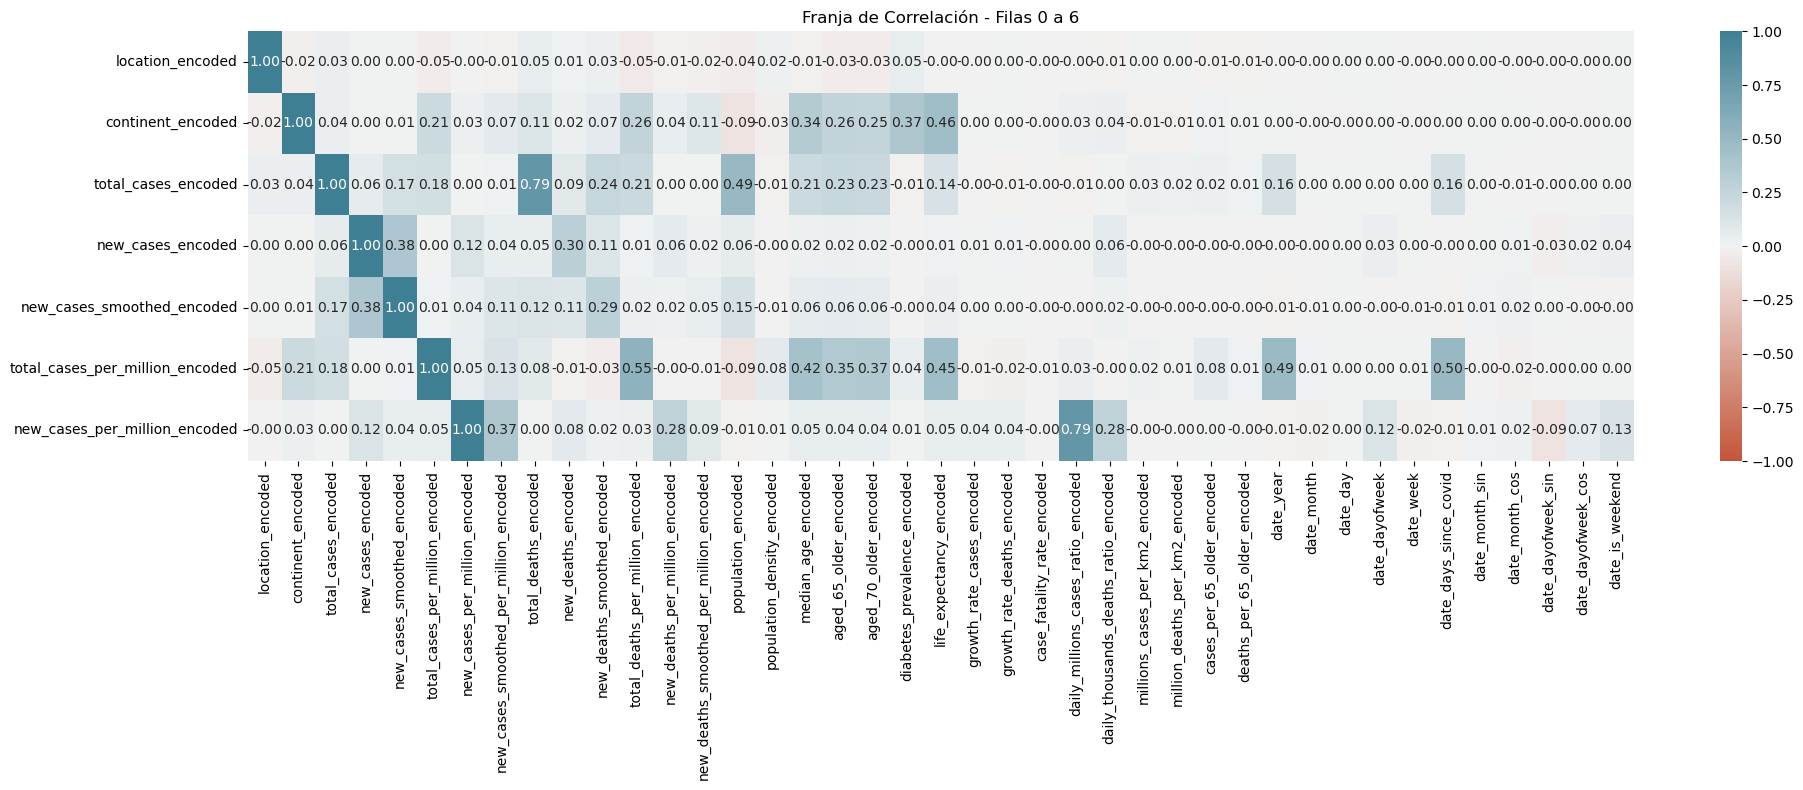

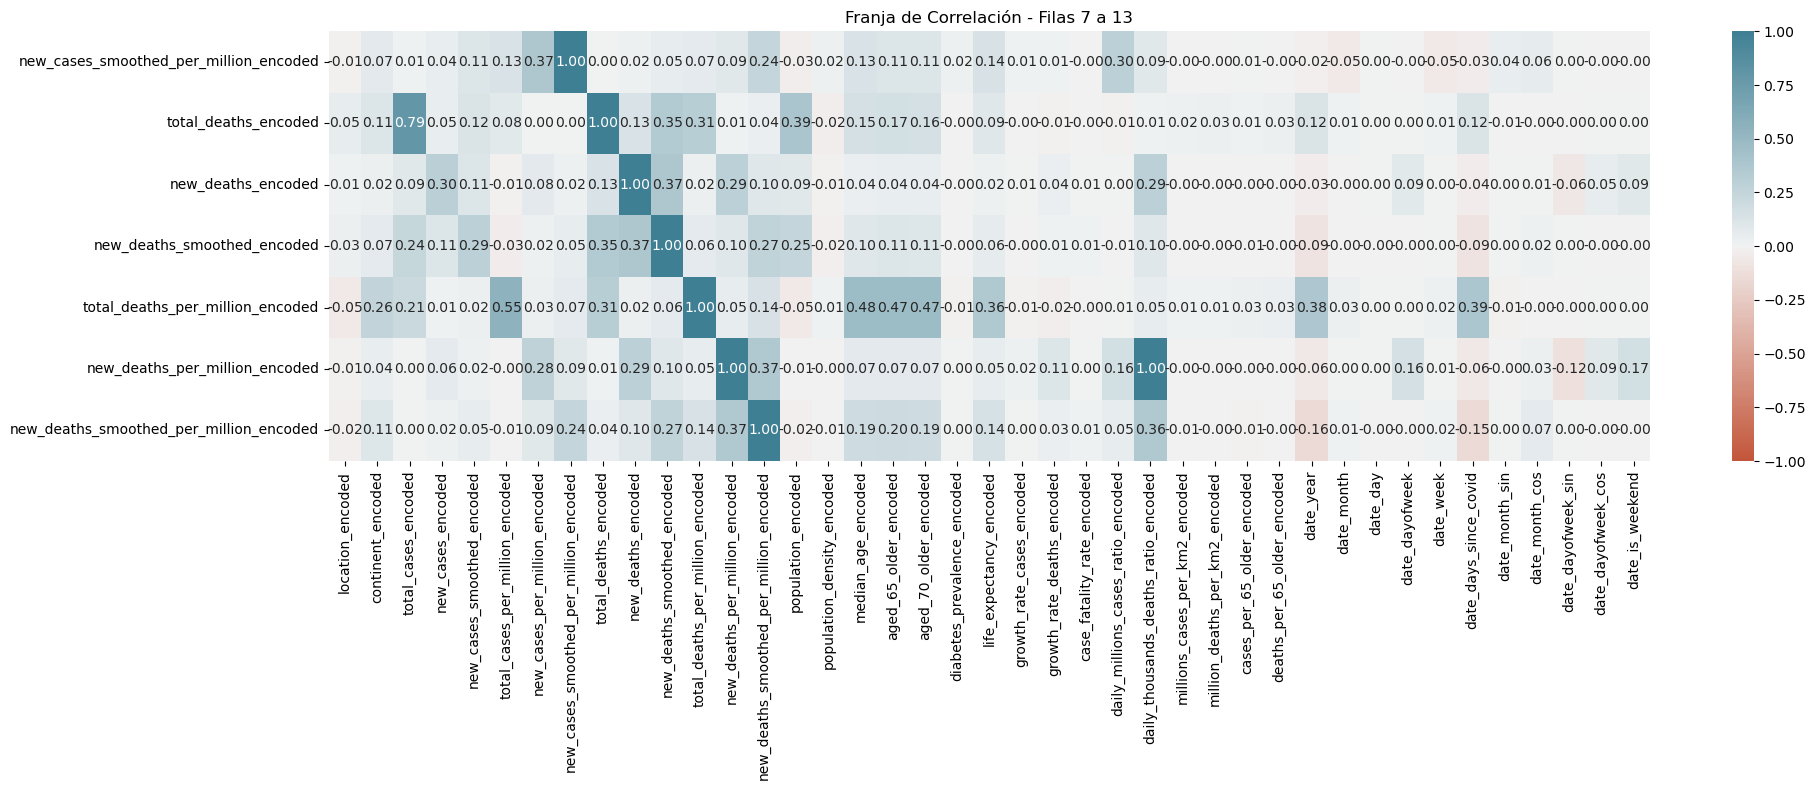

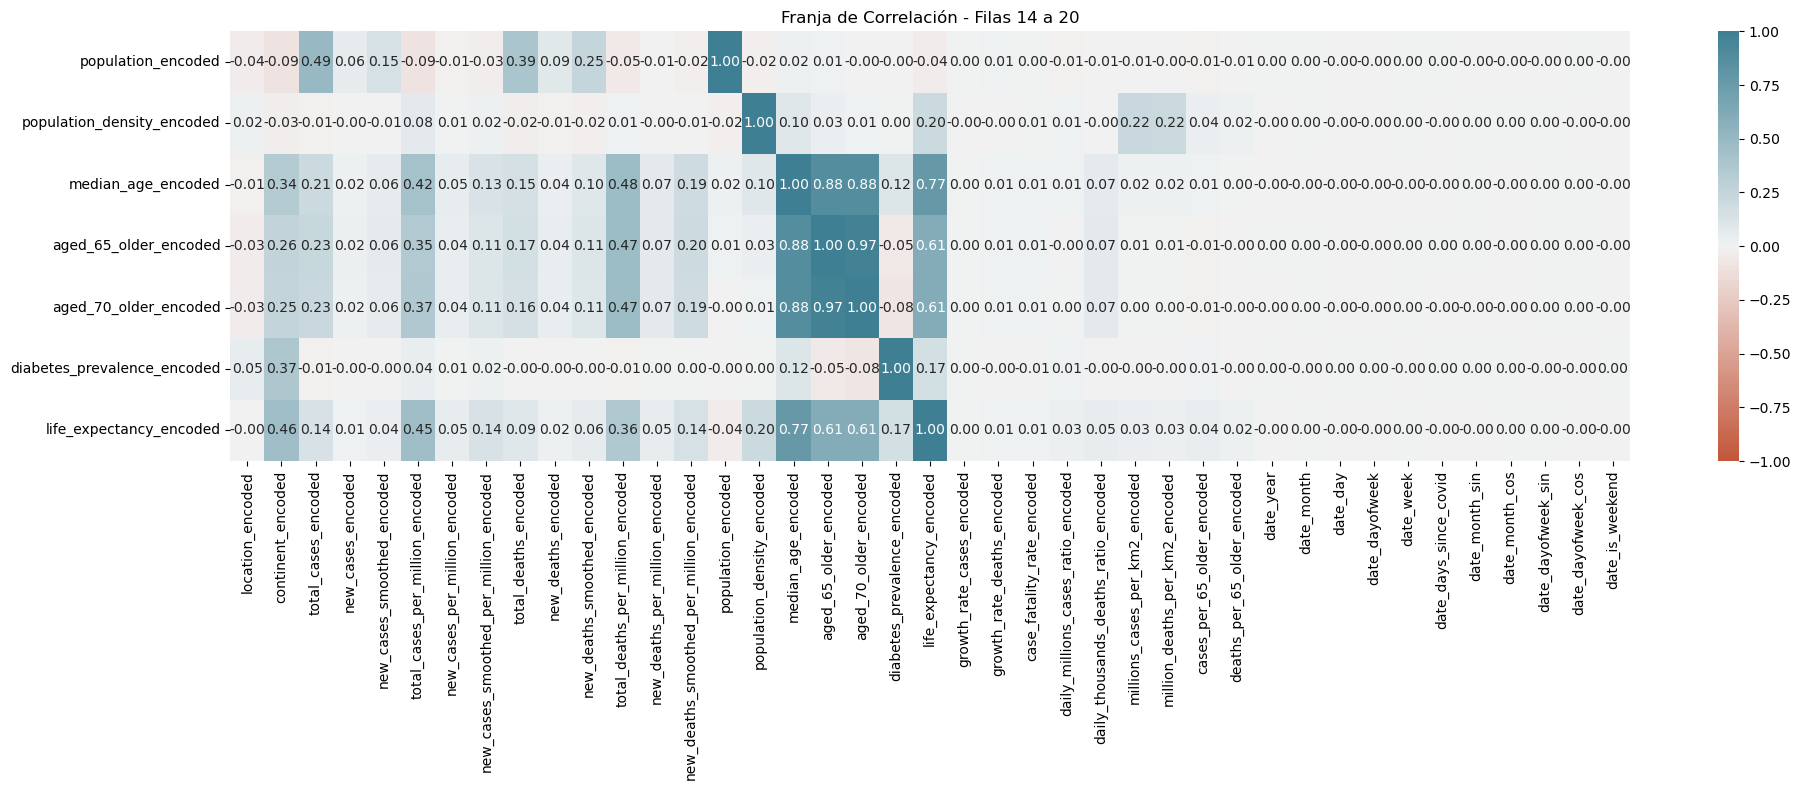

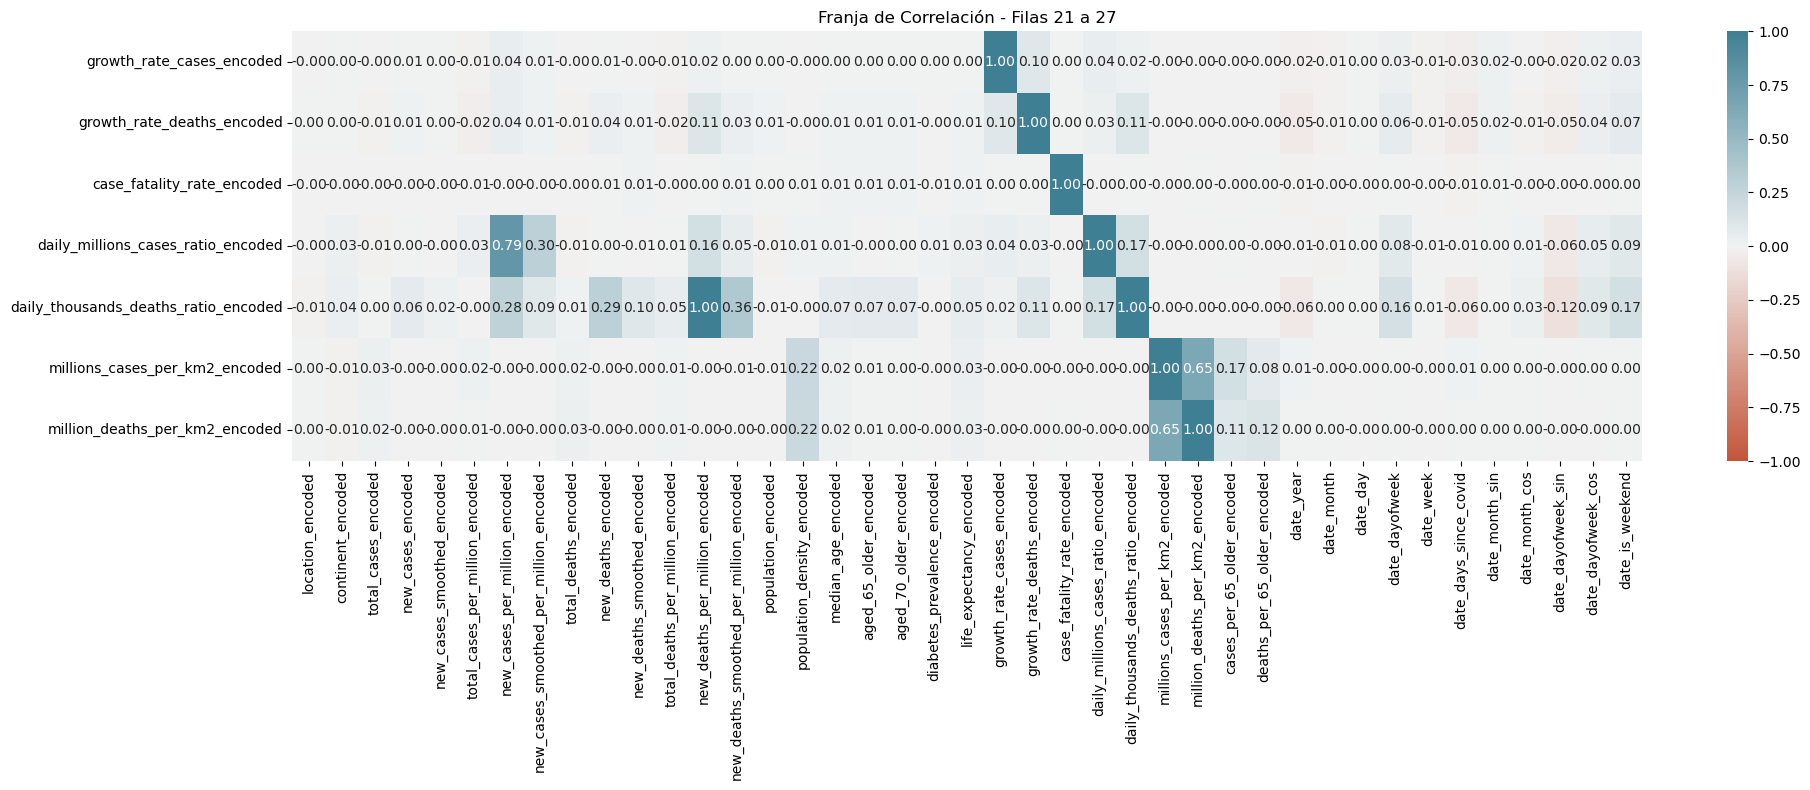

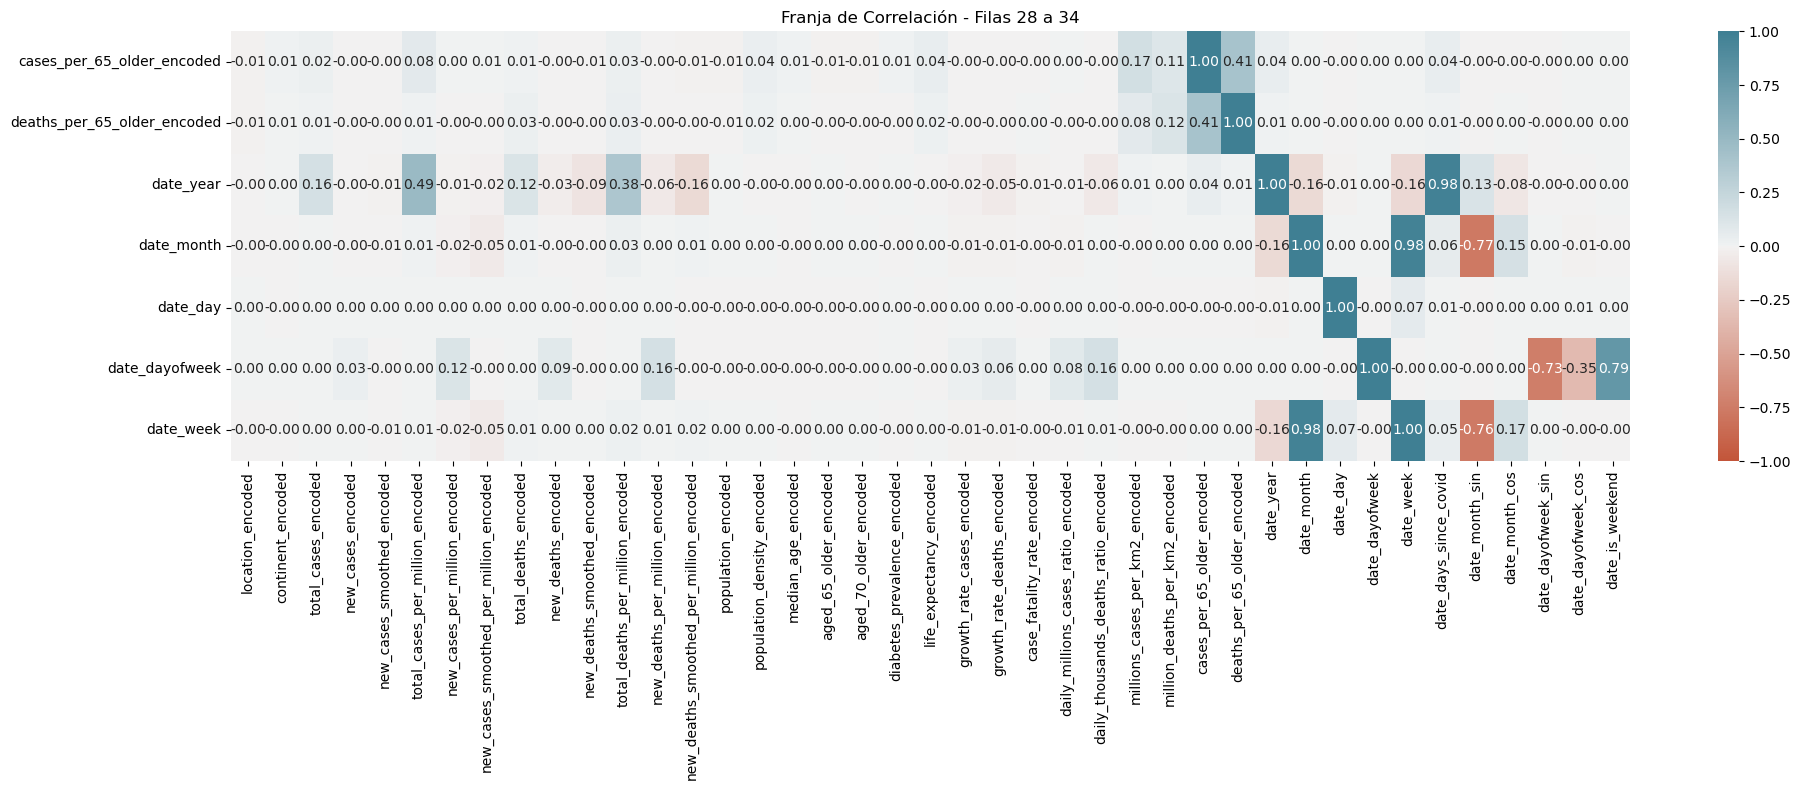

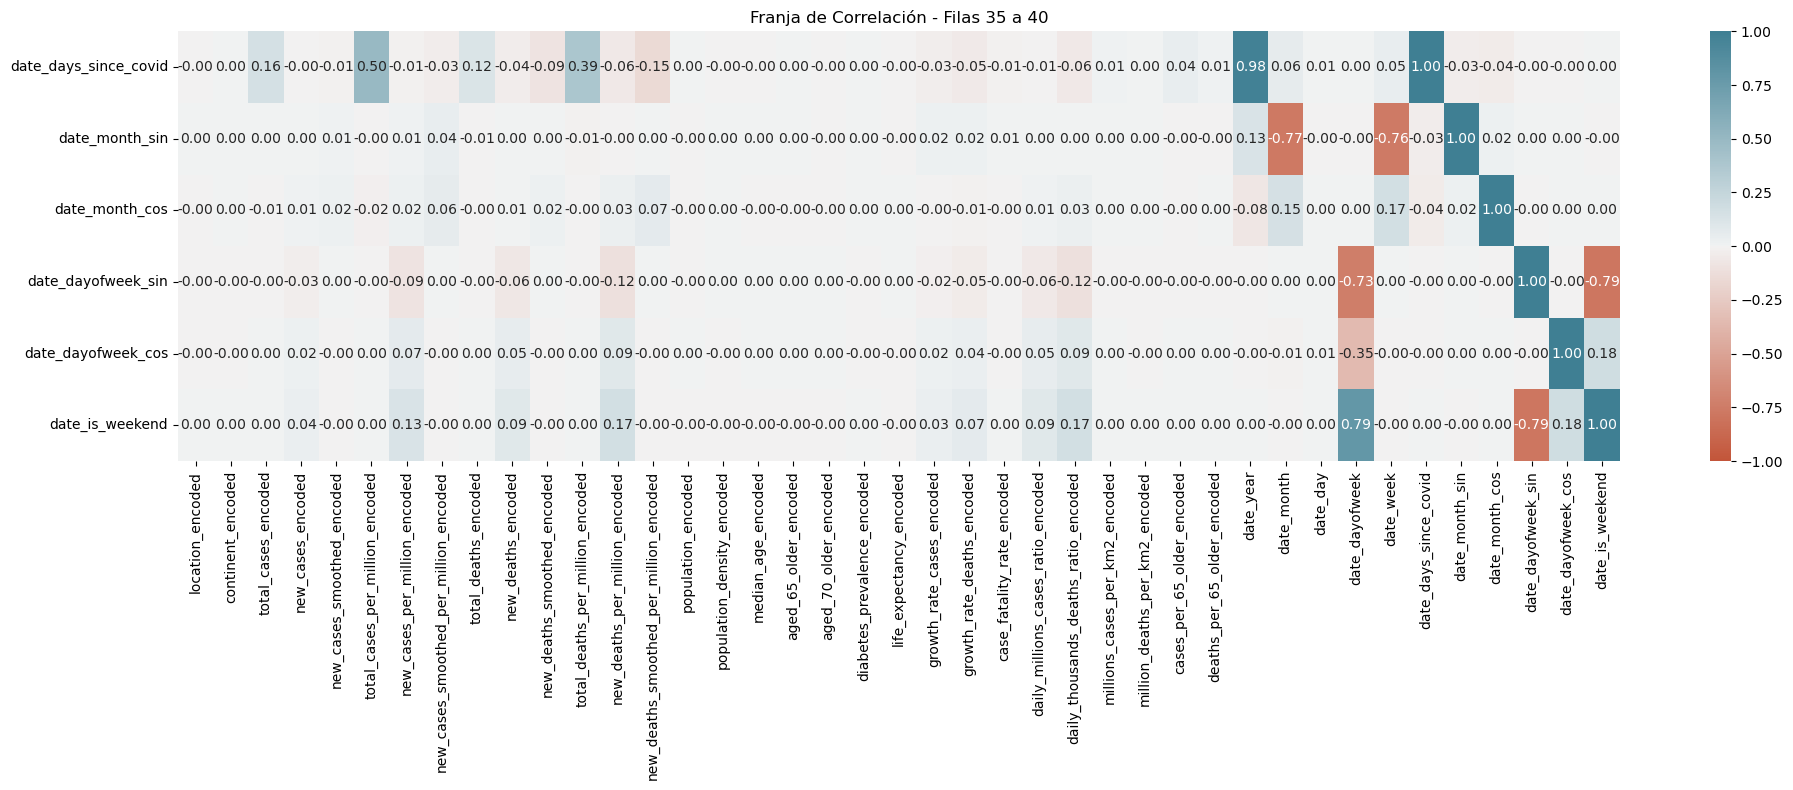

In [248]:
plot_correlation_strips(corr_matrix, strip_height=7)

En esta matriz podemos observar estas correlaciones entre variables:

- correlación muy alta (más del 90%):
  - new_deaths_per_million y daily_thousands_deaths_ratio
  - aged_65_older y aged_70_older
  - date_year y date_days_since_covid
  - date_month y date_week

- correlación alta (más del 80%):
  - median_age y aged_65_older
  - median_age y aged_70_older

- correlación elevada (más del 70%):
  - total_cases y total_deaths
  - new_cases_per_million y daily_millions_cases_ratio
  - median_age y life_expectancy
  - date_month y date_month_sin
  - date_dayofweek y date_dayofweek_sin
  - date_dayofweek y date_is_weekend
  - date_week y date_month_sin
  - date_dayofweek_sin y date_is_weekend

En este momento es importante tener en cuenta que el objetivo de este estudio es crear gráficos y mapas a partir de estos datos. Vamos a ver caso por caso las relaciones entre estas variables, y decidir si eliminar o no una de las variables correlacionadas.

<b>1. Correlación muy alta (más del 90%)</b>:

- new_deaths_per_million y daily_thousands_deaths_ratio: ambas miden la mortalidad diaria normalizada; para los gráficos estimo que new_deaths_per_million será más clara, por lo que la mantengo y elimino daily_thousands_deaths_ratio.

- aged_65_older y aged_70_older: se solapan mucho; para mapas demográficos aged_65_older abarca más población, por lo que vamos a mantenerla y a eliminar aged_70_older.

- date_year y date_days_since_covid: para series temporales nos aportará más valor date_days_since_covid, mientras que date_year sólo abarca unos pocos años; aún así, date_year puede ser más intuitivo para visualizaciones temporales; mantenemos ambas variables.

- date_month y date_week: entre tendencias mensuales y tendencias semanales, puede ser suficiente con las mensuales para detectar estacionalidad; eliminamos date_week.

<b>2. Correlación alta (más del 80%)</b>:

- median_age y aged_65_older: representan conceptos diferentes, edad promedio y proporción de mayores; mantenemos ambas.

- median_age y aged_70_older: al estudiar la correlación muy alta decidimos eliminar aged_70_older.

<b>3. Correlación elevada (más del 70%)</b>:

- total_cases y total_deaths: distinto significado epidemiológico, casos (propagación) frente a muertes (severidad), por lo que aunque estén correlacionadas vamos a mantener ambas variables.

- new_cases_per_million y daily_millions_cases_ratio: similar a new_deaths_per_million y daily_thousands_deaths_ratio, vamos a mantener new_cases_per_million y a eliminar daily_millions_cases_ratio.

- median_age y life_expectancy: representan diferentes aspectos demográficos, mediana de edad (estructura demográfica) y condiciones de salud y desarrollo; mantenemos ambas.

- date_month y date_month_sin: date_month_sin es la codificación cíclica del mes y es útil para análisis de patroes estacionales; date_month es útil para etiquetas legibles en gráficos; mantenemos ambas.

- date_dayofweek y date_dayofweek_sin: similar al caso anterior, pero vamos a centrar el estudio en tendencias mensuales, no semanales; eliminamos ambas variables.

- date_dayofweek y date_is_weekend: eliminamos ambas variables, no vamos a estudiar tendencias semanales.

- date_week y date_month_sin: ya hemos decidido eliminar date_week.

- date_dayofweek_sin y date_is_weekend: ya hemos decidido eliminar ambas.

Variables a eliminar:

- daily_thousands_deaths_ratio
- aged_70_older
- date_week
- daily_millions_cases_ratio
- date_dayofweek
- date_dayofweek_sin
- date_is_weekend

In [249]:
df_encoded_clean = df_encoded.copy()

In [250]:
df_encoded_clean.drop(['daily_thousands_deaths_ratio', 'aged_70_older', 'date_week',
                       'daily_millions_cases_ratio', 'date_dayofweek',
                       'date_dayofweek_sin', 'date_is_weekend'], 
                      axis='columns', inplace=True)

df_encoded_clean.columns

Index(['date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'population_density', 'median_age',
       'aged_65_older', 'diabetes_prevalence', 'life_expectancy', 'population',
       'growth_rate_cases', 'growth_rate_deaths', 'case_fatality_rate',
       'millions_cases_per_km2', 'million_deaths_per_km2',
       'cases_per_65_older', 'deaths_per_65_older', 'location_encoded',
       'continent_encoded', 'total_cases_encoded', 'new_cases_encoded',
       'new_cases_smoothed_encoded', 'total_cases_per_million_encoded',
       'new_cases_per_million_encoded',
       'new_cases_smoothed_per_million_encoded', 'total_deaths_encoded',
       'new_deaths_encoded', 'new_deaths_smoothed_encoded',
       'tot

## 3. Guardar los datos

In [251]:
# fecha actual en formato yyyy-mm-dd
current_date = datetime.now().strftime("%Y-%m-%d")

# nombre de fichero
file_name = dataframe_path + "//" + dataframe_file + f"_encoded_{current_date}.pkl"

# crea fichero
with open(file_name, "wb") as f:
    pickle.dump(df_encoded_clean, f)
    print(f"Guardado: {file_name}")

Guardado: ..//data//dataframes//covid__covid_2025-07-01_encoded_2025-07-01.pkl
